<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON1_Trading_Strategy_Functions_v12_Markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [670]:
!pip3 install pyfolio
!pip install datetime
!pip install scipy
from scipy.optimize import minimize

# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [671]:
import os
import pandas_datareader.data as web
from datetime import datetime
from pprint import pprint
import pandas as pd

import datetime
import pyfolio as pyf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


# ------------------------------
#     SIMULATION PARAMETERS
# ------------------------------
currency        = "TL"
CURRENT_T2 = 100000
STEP = 0
CHART = 0
P_BOUND_HI = 1   # 0.19416                           # << 1 disinda bir degere sinirlayinca getiri azaliyor
P_BOUND_LO = 0   # 0.19416                           # << SIFIR KALMASI GEREKIYOR OPTIMIZASYON CONVERGE EDEMIYOR
LENGTH     = 100                                         # << INPUT for seperator length
CASES      = 10000                                       # << INPUT for $ of cases in the Montecarlo simulation
START_DAYS_AGO  = 140    # calibrated for 28.04.2022 on 7.09.22                           # << INPUT for forward testing period
BACKTEST_PERIOD = 140 # calibrated for 28.04.2022 on 7.09.22                          # << INPUT for backward testing period
FW_TEST_PERIOD  = 0  # calibrated for 28.04.2022 on 7.09.22
FW_TEST_LIMIT = 0
exchange = "BIST100"
#risk_free_rate = 0.235
risk_free_rate = 0.3
look_back = START_DAYS_AGO
Rfr_g = risk_free_rate / 365 # << INPUT calculate daily rfr
Rfr = Rfr_g * START_DAYS_AGO

SHARPE_LIMIT   = -2   # typical 3
STD_LIMIT      = 5    # typical 3.5
CORR_FILTER    = 1 # ayni sektor hisselerini 0.75-0.8 yaparak ele ! Bankalar 0.83 civari alakali, havacilik 0.75 civari

# ------------------------------
#     FLOATING POINT CONVENTION
# ------------------------------

pd.options.display.float_format = "{:,.3f}".format  # << INPUT




pd.set_option('display.max_rows', None)

current_date = datetime.datetime.now()

delta = 1
day = current_date.day
month = current_date.month
year = current_date.year - delta

COMISSION_PERCENT = 0.0004

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

TARGET_RETURN = 0.00
VOLATILITY_FACTOR = 0.45

WINNER_LIMIT_TR = 0.53
WINNER_LIMIT_US = 0.54
R_WINDOW = 32
REVERSED = False

LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker + ".IS"

TR_Tickers = ["EREGL", "CANTE", "GARAN", "KCHOL", "EUPWR"]
US_Tickers = ["TSLA", "AAPL", "GOOGL", "BA", "V"]
DOW30 = ["AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","JNJ","KO","JPM",
         "MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM","VZ","V","WBA","WMT","DIS","DOW"]

BIST30 = ["XU100","AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK","EUPWR"]

BIST100 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TCELL","THYAO","TOASO","TUPRS","YKBNK",
          "AEFES","AGHOL","AHGAZ","AKCNS","AKFGY","AKSA","AKSEN",
           "ALBRK","ASUZU","AYDEM","BAGFS","BERA",
           "BRSAN","BRYAT","BUCIM","CANTE","CCOLA","CEMTS","CIMSA",
           "DOAS","DOHOL","ECILC","ECZYT","EGEEN","ENJSA",
           "GENIL","GESAN","GLYHO","GSDHO","GWIND","HALKB","IPEKE",
           "ISDMR","ISGYO","ISMEN","IZMDC","KARSN","KMPUR",
           "KONTR","KONYA","KORDS","KZBGY","MAVI","OTKAR","OYAKC",
           "PENTA","QUAGR","SELEC","SKBNK","SMRTG",
           "SNGYO","SOKM","TAVHL","TKFEN","TKNSA","TOASO","TSKB",
           "TTKOM","TTRAK","TUKAS","ULKER","VAKBN","VESBE","ZOREN",
           "EUPWR"]


sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

sp500_constituents = pd.read_html(sp_url, header=0)[0]
sp500_constituents = sp500_constituents[sp500_constituents.Symbol != "BRK.B"]
sp500_constituents = sp500_constituents[sp500_constituents.Symbol != "BF.B"]


sp500_constituents.Symbol;

In [672]:
def ConvertToUSD(ticker, start, end, exchange):

  try:
      adjclose = yf.download(ticker,start,end)['Adj Close']
      adjclose_usd = adjclose
      close = yf.download(ticker,start,end)['Close']
      open = yf.download(ticker,start,end)['Open']
      usdtry = yf.download('TRY=X',start,end)['Adj Close']
  except Exception as e:
      print(e)

  adjusted_factor = adjclose / close
  adjopen = adjusted_factor * open
  adjopen_usd = adjopen


  if ( exchange != "SP500" or exchange != "DOW30"):
    for i in np.arange(0,len(close)):
        adjclose_usd[i] = adjclose[i]/usdtry[i]
        adjopen_usd[i] = adjopen[i]/usdtry[i]

  rets = adjclose_usd.pct_change()

  return adjclose_usd, adjopen_usd, rets

In [673]:
def UpdateData(TickerIS, START, END, exchange):

  # For data manupulations

  # VF    LB    PEAK_CUM  CUM_LAST    REVERSED
  # 0.25  45    6.11       4.29 OK    True
  # 0.35  45    7.42       5.02 OK    True
  # 0.40  45    7.64       5.17 OK    True
  # 0.45  45    8.99       6.16 OK    True
  # 0.45  45    1.22       1.05 OK    False
  # 0.45  55    7.97       5.39 OK    True
  # 0.45  40    9.35       6.31 OK    True
  # 0.45  35    9.65       7.14 OK    True
  # 0.45  33    9.78       7.24 OK    True  ***
  # 0.45  32    10.02      7.42 OK    True  ****
  # 0.45  30    9.16       6.78 OK    True
  # 0.45  25    8.19       5.98 OK    True
  # -   -       5.17       4.82 OK    True / original Gap up buy side.

  # Read data from Yahoo finance
  data = pd.DataFrame()

  if ( exchange != "SP500" or exchange != "DOW30"):
    # In Turkish exchange
      data['Adj Close'], data['Adj Open'], data['rets'] = ConvertToUSD(TickerIS, START, END, "BIST")

  else:
    # In US exchange
      data['Adj Close'], data['Adj Open'], data['rets'] = ConvertToUSD(TickerIS, START, END, "DOW30")

  data.index = pd.to_datetime(data.index,format="%d-%m-%Y")
  # Buy at Close - Sell at Open (BACSAO) Strategy
  data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1) - COMISSION_PERCENT*2
  data['BAC_SAO_str_returns'] = (data.returns+1).cumprod()

 # Improved Gap-up Strategy
  data['std'] = data['returns'].rolling(R_WINDOW).std()
  data['positions'] = np.nan
  data['close']= data['Adj Close']
  data["log_returns"] = data['close'].pct_change().apply(lambda x: np.log(1+x))
  data["rel"]= data['Adj Close'] / data['Adj Close'][0]

  # Long entry condition
  if REVERSED:
      long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
      short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
      long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
      short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']

  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1
  data.loc[short_entry, 'positions'] = 0

  data = data.dropna()

  data['positions'].fillna(method='ffill', inplace=True)

  # BAOSAC STRATEGY: Buy at open, sell at Close
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()

  #print(data.tail(10))

  return data

In [674]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [675]:
# IMPROVED STRATEGY
def Strategy(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  # data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  return data



In [676]:
# IMPROVED STRATEGY
def Volatility_Strategy_USD_TR(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true

  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  #data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)


  return data



In [677]:


# Drop NaN values
#data = data.dropna()

In [678]:
def CalculateStrReturns(data):
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  return data

In [679]:
def PlotUSDTROpenClosePerformance(Ticker,data):
  print(f"Plotting Open-Close Performance for {Ticker}")
  # Plot cumulative returns
  global LEFT, RIGHT
  import datetime

  fig = plt.gcf()
  fig.set_size_inches(16, 10)

  # ----------------------------------------------------------------------------------
  plt.subplot(1, 1, 1)
  plt.xlim(LEFT, RIGHT)
  plt.plot((data['rel']), color='b', label="price USD")
  plt.plot((data['BAC_SAO_str_returns']/data['BAC_SAO_str_returns'][0]), color='r', label="Open-Close")
  plt.plot((data['cumulative_strategy_returns']/data['cumulative_strategy_returns'][0]), color='g', label="Improved Gap")
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} Normalized price, open-close, improved gap strategies", fontsize=12)
  plt.xlabel('Date', fontsize=12)
  plt.legend()
  plt.ylabel('Normalized price', fontsize=12)

  # ----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 2)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['BAC_SAO_str_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} data['BAC_SAO_str_returns'] ", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Open-Close Trade Returns', fontsize=12)


  # # ----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 3)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['cumulative_strategy_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} data['cumulative_strategy_returns'] ", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Volatility Strategy Returns', fontsize=12)

 #----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 3)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['close'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} TL price", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Price TL', fontsize=12)

  # #----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 4)
  # plt.xlim(LEFT, RIGHT)
  # plt.plot(data['BAC_SAO_str_returns'])
  # plt.grid(True)
  # plt.xticks(fontsize=12)
  # plt.yticks(fontsize=12)
  # plt.title(f"{Ticker} TL Open-Close Strategy", fontsize=12)
  # #plt.xlabel('Date', fontsize=12)
  # plt.ylabel('Open-Close Strategy TL Returns', fontsize=12)

  #----------------------------------------------------------------------------------
  # plt.subplot(2, 1, 2)
  # plt.xlim(LEFT, RIGHT)
  # plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  # plt.xlabel('Date', fontsize=14)
  # plt.ylabel(f'{Ticker} volatility', fontsize=14)
  # plt.grid()
  # plt.xticks(fontsize=12)
  # plt.plot(data['std']*252**0.5)

  plt.show()

In [680]:
def ShowDataTable(data):
  global year, day, month
  return(data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna())




In [681]:
def CreateTearSheetForData(data):
  # if we buy and hold performance would be:
  print("\nIf we buy and hold performance would be:")
  print("\n======================================")
  pyf.create_simple_tear_sheet(data['rets'].dropna())

  # if we apply open-close strategy, performance would be:
  print("\nIf we apply open-close strategy, performance would be:")
  print("\n====================================================")
  pyf.create_simple_tear_sheet(data['returns'].dropna())


In [682]:
def EvaluateFeasibility(data):
  Max_Cum_Norm_Ret = np.max(data.BAC_SAO_str_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.BAC_SAO_str_returns.iloc[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns.iloc[-1]

  Latest_Rel = data['rel'].iloc[-1]
  Latest_Cum_Norm_Ret = data.BAC_SAO_str_returns.iloc[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible

In [683]:
def PredictNextState(datareturns, Rtarget):
    state_bins = [-np.inf, Rtarget, np.inf]
    datastate = pd.cut(datareturns, bins=state_bins)
    transition_matrix = pd.crosstab(datastate, datastate.shift(-1), normalize='index')
    #print(transition_matrix)
    current_state = datastate.iloc[-1]
    #print(f'Current state: {current_state}')
    next_state = np.random.choice(transition_matrix.columns, p=transition_matrix.loc[current_state].values)
    #print(f'Predicted next state: {next_state}')
    # Print the probabilities of all states
    state_probabilities = datastate.value_counts(sort=True, normalize=True)
    #print("State probabilities:")
    #print(state_probabilities)
    return next_state, np.round(transition_matrix[1][1],3)


In [684]:
def ConvertTimeSeriesToReturns(pf_data):
    log_returns = np.log(pf_data/pf_data.shift(1))
    return log_returns

In [685]:
def ShowTRMarket(Tickers, target_return):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[], 'PWin_OC':[], 'PWin':[]};

  timeseries = pd.DataFrame() # my real timeseries dataframe
  rets = pd.DataFrame()
  names = []
  count = len(Tickers)

  for ticker in Tickers:
      ticker = ticker + ".IS"
      print(f"Downloading {ticker}...")
      d = UpdateData(ticker, START, END, "BIST");
      #d = Volatility_Strategy_USD_TR(d)
      timeseries = pd.concat([timeseries,d['Adj Close']],axis=1)
      # st_name = ticker.split('.',maxsplit = 1)
      # names.append(st_name[0])
      names.append(ticker)

      opc,clo,fb = EvaluateFeasibility(d);

      ns0, tm0 = PredictNextState(d['rets'], target_return)
      print("\n====================================================")
      print(f"Next State Probabilities for {ticker} Buy-Hold: {ns0}, {tm0}")
      print("\n====================================================")

      ns1, tm1 = PredictNextState(d['returns'], target_return)
      print("\n====================================================")
      print(f"Next State Probabilities for {ticker} Open-Close {ns1}, {tm1}")
      print("\n====================================================")

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)
      my_dict['PWin_OC'].append(tm1)
      my_dict['PWin'].append(tm0)


  df = pd.DataFrame(my_dict)

  df_oc = df[ (df['PWin_OC']> WINNER_LIMIT_TR) & (df['PWin']> WINNER_LIMIT_TR) & (df['Eff']> 1)].sort_values(by=['Open-Close'], ascending=False).reset_index(drop=True)
  df_long = df[ (df['PWin_OC']> WINNER_LIMIT_TR) & (df['PWin']> WINNER_LIMIT_TR) & (df['Eff']> 1)].sort_values(by=['Close'], ascending=False).reset_index(drop=True)


  print("\n====================================================")
  print(f"Forming dataframe: sorted_timeseries for best probability assets")
  print("\n====================================================")


  timeseries.columns = names
  timeseries = timeseries.rename_axis(index="Date")


  sorted_timeseries = timeseries.sort_values(by=['Date'], ascending=[True])
  print(sorted_timeseries)
  sorted_timeseries.to_csv(f"BIST_AdjClose.csv")

  print("\n====================================================")
  print(f"Forming dataframe: sorted_returns")
  print("\n====================================================")
  sorted_returns = ConvertTimeSeriesToReturns(sorted_timeseries)

  print("\n====================================================")
  print(f"\nList for Open-Close:")
  print(df_oc)

  print("\n====================================================")
  print(f"\nList for Long:")
  print(df_long)
  return df_oc, df_long, sorted_returns



In [686]:
def ShowUSMarket(Tickers,target_return):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[], 'PWin_OC':[], 'PWin':[]};

  for ticker in Tickers:
    print(f"Downloading {ticker}...")
    d = UpdateData(ticker, START, END, "DOW30");
    opc,clo,fb = EvaluateFeasibility(d);

    # print("\n====================================================")
    # print(f"Next State Probabilities for {ticker} Buy-Hold")
    # print("\n====================================================")
    ns0, tm0 = PredictNextState(d['rets'], target_return)

    # print("\n====================================================")
    # print(f"Next State Probabilities for {ticker} Open-Close")
    # print("\n====================================================")
    ns1, tm1 = PredictNextState(d['returns'], target_return)

    my_dict['Ticker'].append(ticker)
    my_dict['Eff'].append(fb)
    my_dict['Open-Close'].append(opc)
    my_dict['Close'].append(clo)
    my_dict['PWin_OC'].append(tm1)
    my_dict['PWin'].append(tm0)

  df = pd.DataFrame(my_dict)

  df_oc = df[ (df['PWin_OC']> WINNER_LIMIT_US) & (df['PWin']> WINNER_LIMIT_US) & (df['Eff']> 1)].sort_values(by=['Open-Close'], ascending=False).reset_index(drop=True)
  df_long = df[ (df['PWin_OC']> WINNER_LIMIT_US) & (df['PWin']> WINNER_LIMIT_US) & (df['Eff']> 1)].sort_values(by=['Close'], ascending=False).reset_index(drop=True)

  print("\n====================================================")
  print(f"\nList for Open-Close:")
  print(df_oc)

  print("\n====================================================")
  print(f"\nList for Long:")
  print(df_long)


  return df_oc, df_long

In [687]:
def ShowTickerStats(ticker, exchange):

  print("\n====================================================")
  print(f"\nUpdating data for {ticker}")
  print("\n====================================================")
  d = UpdateData(ticker, START, END, exchange)

  print("\n====================================================")
  print(f"\nPlotting for {ticker}")
  print("\n====================================================")
  PlotUSDTROpenClosePerformance(ticker, d)

  print("\n====================================================")
  print(f"Creating Tear Sheet for {ticker}")
  print("\n====================================================")
  CreateTearSheetForData(d)



  return d

In [688]:
def EmpyrialPortfolioPerformance():
  !pip install Scikit-learn
  !pip install empyrial

  from empyrial import empyrial, Engine

  pf2 = Engine(
                    start_date= START, #start date for the backtesting
                    portfolio = ["ODAS.IS", "ALARK.IS", "KOZAA.IS", "ENKAI.IS","KRDMD.IS", "ISCTR.IS", "PETKM.IS", "TAVHL.IS", "EREGL.IS"],
                    optimizer = "MEANVAR", # defines Mean-Variance as the optimizer
                    max_vol = 40, #maximize the return for this level of volatility (25%)
                    benchmark = ["TRY=X"], #NIFTY50 is set by default
                    #rebalance = "1Y" #rebalance every year
                    #risk_manager = {"Take Profit" : 1} #Stop the investment when the profit becomes superior to 25%
  )
  empyrial(pf2)
  empyrial.orderbook


In [689]:


# A function for generating a numpy array containing random weights that add upto 1
def RandWeights(size):
    weight = np.random.dirichlet(np.ones(size))
    return weight




# A function to generate the avg return, risk and the sharpe ratio of the portfolio
# correponding to the weight array passed
def portfolio_stats(weight, log_returns):

    # Convert to array in case list was passed instead.
    weight = np.array(weight)
    port_return = np.sum(log_returns.mean() * weight) * 250
    port_risk = np.sqrt(np.dot(weight.T, np.dot(log_returns.cov() * 250, weight)))
    sharpe = (port_return - risk_free_rate)/port_risk

    return {'return': port_return, 'risk': port_risk, 'sharpe': sharpe}



def Monte_Carlo(iterations):
    portfolio_returns = []
    portfolio_risks = []
    for x in range (iterations):
        weight = RandWeights(length)
        pf_stats = portfolio_stats(weight)
        portfolio_returns.append(pf_stats['return'])
        portfolio_risks.append(pf_stats['risk'])

    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    return portfolio_returns, portfolio_risks


In [690]:
def NextStep():
    global STEP
    STEP+=1
    print(70*'_')
    print(f"\nPerforming STEP-{STEP}:")

def NextChart():
    global CHART
    CHART+=1

In [691]:
def CalculateSharpeAndVol(log_returns):
    NextStep()
    yearly_rets = np.round(log_returns.mean() * 252,2) # Mean returns annualized for year
    yearly_rets
    vol = np.round(log_returns.std()*np.sqrt(252),3) # annualized version of std deviation
    vol
    sharpe = (yearly_rets - risk_free_rate)/vol
    sharpe
    max_sr_vol = vol[sharpe.argmax()] # risk corresponding to maximum sharpe ratio
    max_sr_ret = yearly_rets[sharpe.argmax()] # return corresponding to maximum sharpe ratio

    plt.figure(figsize=(10,10))
    plt.scatter(vol, log_returns.mean()*100, c=sharpe, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.title('Some BIST assets')
    plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot

    #plt.text(vol, log_returns.mean()*100, s=log_returns.mean().index)
    ASSETS = log_returns.mean().index

    #plt.text(vol, log_returns.mean()*100, ASSETS)

    # labels = ['Variable {0}'.format(i+1) for i in np.arange(len(ASSETS))]
    # for i in np.arange (0,len(ASSETS)):

    print(f"Sharpe Ratio = {sharpe[1]}")
    print(f"Max Sharpe Ratio = {sharpe.max()}")
    print(f"Max Sharpe Ratio Return = {max_sr_ret}")
    print(f"Max Sharpe Ratio Volatility = {max_sr_vol}")
    return vol, ASSETS, sharpe


In [692]:
def PlotRRMap(per_rets, vol, ASSETS, sharpe):
    NextStep()
    coord = list(zip(vol, per_rets))
    labels = ASSETS
    aa = plot_with_labels(coord, labels, sharpe, per_rets)
    from IPython.display import Image
    Image(url=aa)

In [693]:
def CalculateRandomWeights(log_returns):
    dimension = len(log_returns.columns)
    weight = RandWeights(dimension)
    print (weight)
    return dimension, weight


In [694]:
def EvaluatePortfolio(weight, log_returns):
    NextStep()
    print(f"Evaluating Random Portfolio Stats...")
    print(70*'=')
    pf_stats = portfolio_stats(weight, log_returns)
    pf_return = pf_stats['return']
    pf_risk = pf_stats['risk']
    pf_sharpe = pf_stats['sharpe']
    print(pf_stats)
    return pf_stats

In [695]:
def Monte_Carlo(iterations,dimension, log_returns):
    portfolio_returns = []
    portfolio_risks = []
    for x in range (iterations):
        weight = RandWeights(dimension)
        pf_stats = portfolio_stats(weight, log_returns)
        portfolio_returns.append(pf_stats['return'])
        portfolio_risks.append(pf_stats['risk'])

    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    return portfolio_returns, portfolio_risks

def MonteCarloAnalysis(dimension, log_returns):
    NextStep()
    NextChart()
    print(f"Montecarlo Analysis for {CASES} cases of {exchange} assets")
    print(70*'=')
    portfolio_returns, portfolio_risks = Monte_Carlo(CASES,dimension, log_returns)
    sharpe = (portfolio_returns - Rfr) / portfolio_risks
    max_sr_ret = portfolio_returns[sharpe.argmax()] # return corresponding to maximum sharpe ratio
    max_sr_vol = portfolio_risks[sharpe.argmax()] # risk corresponding to maximum sharpe ratio
    plt.figure(figsize=(18,10))
    plt.scatter(portfolio_risks, portfolio_returns, c=sharpe, cmap='viridis')
    plt.colorbar(label='Sharpe Ratio')
    plt.title(f"Montecarlo Analysis for {CASES} cases of {exchange} assets")
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50) # red dot
    plt.grid(True)
    plt.savefig(f"Chart_{CHART}_Montecarlo.jpg", format='jpg', dpi=300)
    plt.show()

    from IPython.display import Image
    Image(url=f"Chart_{CHART}_Montecarlo.jpg")

    print(f"max Sharpe Ratio = {sharpe.max()}")
    print(f"max Sharpe Ratio return = {max_sr_ret}")
    print(f"max Sharpe Ratio volatility = {max_sr_vol}")
    return portfolio_returns, portfolio_risks, sharpe


In [696]:
def OptimizationForAGivenReturn(target_return, dimension, log_returns):

    def fun(weight):
        pf_stats = portfolio_stats(weight, log_returns)
        _risk = pf_stats['risk']
        return _risk

    res = minimize(
      fun,
      RandWeights(dimension),
      method = 'SLSQP',
      constraints=[{'type':'eq','fun': lambda x: portfolio_stats(x, log_returns)['return']-target_return},
                   {'type':'eq','fun': lambda x: np.sum(x)-1}],
      bounds=[(P_BOUND_LO, P_BOUND_HI) for i in range(dimension)]
    )

    return res


In [697]:

def OptimizingWithMinRisk(dimension, log_returns):

    def fun(weight):
        pf_stats = portfolio_stats(weight, log_returns)
        _risk = pf_stats['risk']
        return _risk

    res = minimize(
      fun,
      RandWeights(dimension),
      method = 'SLSQP',
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(P_BOUND_LO, P_BOUND_HI) for i in range(dimension)]
    )

    return res

In [698]:
def PlotandOptimizeWeightsForReturns(portfolio_returns, portfolio_risks, sharpe, dimension, log_returns):
    NextStep()
    NextChart()
    print(f"Plotting possible R-R of Portfolios...")
    print(70*'=')
    plt.figure(figsize=(18,10))
    plt.scatter(portfolio_risks, portfolio_returns,
                c = ( portfolio_returns / portfolio_risks),
                marker = 'o', cmap='viridis')



    # # Plotting the efficient frontier
    # plt.scatter(minimal_risks,
    #             target_returns,
    #             c = (target_returns / minimal_risks),
    #             marker = 'x')


    # Plotting the portfolio that has highest Sharpe Ratio
    Optimal_weights_For_Highest_Sharpe_Ratio = OptimizationWithSharpeRatio(dimension, log_returns).x
    print(f"Optimal_weights_For_Highest_Sharpe_Ratio = {Optimal_weights_For_Highest_Sharpe_Ratio}")
    plt.plot(portfolio_stats(Optimal_weights_For_Highest_Sharpe_Ratio, log_returns)['risk'],
             portfolio_stats(Optimal_weights_For_Highest_Sharpe_Ratio, log_returns)['return'],
             'r*',
             markersize = 25.0, label = "Portfolio corresponding to max sharpe")



    # # Plotting the optimal portfolio that has lowest risk
    Optimal_weights_For_Lowest_Risk = OptimizingWithMinRisk(dimension, log_returns).x
    print(f"Optimal_weights_For_Lowest_Risk = {Optimal_weights_For_Lowest_Risk}")

    plt.plot(portfolio_stats(Optimal_weights_For_Lowest_Risk, log_returns)['risk'],
             portfolio_stats(Optimal_weights_For_Lowest_Risk, log_returns)['return'],
             'g*',
             markersize = 25.0, label = "Portfolio corresponding to lowest risk")

    #Plotting the optimal portfolio for 250% annual returns
    Optimal_weights_for_Percent_Returns = OptimizationForAGivenReturn(3, dimension, log_returns).x
    Optimal_weights_for_twenty_five_percent_returns = OptimizationForAGivenReturn(1,dimension, log_returns).x

    plt.plot(portfolio_stats(Optimal_weights_for_twenty_five_percent_returns, log_returns)['risk'],
             portfolio_stats(Optimal_weights_for_twenty_five_percent_returns, log_returns)['return'],
             'b*',
             markersize = 25.0, label = "Optimal Portfolio corresponding to 100% return")


    # Plotting the optimal portfolio for 150% annual returns
    Optimal_weights_for_thirty_five_percent_returns = OptimizationForAGivenReturn(1.5,dimension, log_returns).x

    plt.plot(portfolio_stats(Optimal_weights_for_thirty_five_percent_returns, log_returns)['risk'],
             portfolio_stats(Optimal_weights_for_thirty_five_percent_returns, log_returns)['return'],
             'm*',
             markersize = 25.0, label = "Optimal Portfolio corresponding to 150% return")

    plt.title("Risk Return Map",fontsize = 25)
    plt.grid(True)
    plt.xlabel('Portfolio Risk',fontsize = 20)
    plt.ylabel('Portfolio Return', fontsize = 20)
    plt.legend(prop={'size': 10})
    plt.colorbar(label='Sharpe ratio')
    plt.savefig(f"Chart_{CHART}_RRMAP.jpg", format='jpg', dpi=300)

    from IPython.display import Image
    Image(url=f"Chart_{CHART}_RRMAP.jpg")
    plt.show()
    return Optimal_weights_For_Highest_Sharpe_Ratio



In [699]:
def FindMaxSharpePFStats(log_returns,Optimal_weights_For_Highest_Sharpe_Ratio):
    NextStep()
    print(f"Calculating Portfolio Stats...")
    print(70*'=')
    WEIGHT_HSR = portfolio_stats(Optimal_weights_For_Highest_Sharpe_Ratio, log_returns)['return']
    STDDEV_HSR = portfolio_stats(Optimal_weights_For_Highest_Sharpe_Ratio, log_returns)['risk']/np.sqrt(252)
    print(portfolio_stats(Optimal_weights_For_Highest_Sharpe_Ratio, log_returns))

In [700]:


def DistributeAmounts(w,stock_list):
    NextStep()
    print(f"Distribute Amounts in TL...")
    print(70*'=')
    BEST_PF = pd.Series(w*100, stock_list)
    print("% weights of BEST PF")
    index = w>=0.01
    a = pd.DataFrame(BEST_PF[index].round(3),  columns=['%'] )
    Portfolio_Weights = w[index].round(4)
    Portfolio_Assets = BEST_PF[index]
    Portfolio_Amounts = Portfolio_Weights*CURRENT_T2
    a[f"Amount in {CURRENT_T2} {currency}"] = np.round(Portfolio_Amounts,2)
    a.sort_values(by=['%'], ascending=[False], inplace = True)
    print(a[f"Amount in {CURRENT_T2} {currency}"])
    return a



In [701]:
def OptimizationWithSharpeRatio(dimension, log_returns):

    def FindNegSharpe(weight):
        return (-1)*portfolio_stats(weight, log_returns)['sharpe']

    res = minimize(
          FindNegSharpe,
          RandWeights(dimension),
          method = 'SLSQP',
          constraints=[
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
          ],
          bounds=[(P_BOUND_LO, P_BOUND_HI) for i in range(dimension)]
        )

    return res


In [702]:
def FormMarkowitzPortfolio(df, log_returns_USD, mode= "MAX_SHARPE"):

  vol, ASSETS,sharpe = CalculateSharpeAndVol(log_returns_USD)
  #PlotRRMap(period_rets_USD, vol, ASSETS, sharpe)
  dimension, weight = CalculateRandomWeights(log_returns_USD)

  pf_stats = EvaluatePortfolio(weight, log_returns_USD)
  portfolio_returns, portfolio_risks, sharpe = MonteCarloAnalysis(dimension, log_returns_USD)
  Optimal_weights_For_Highest_Sharpe_Ratio = PlotandOptimizeWeightsForReturns(portfolio_returns, portfolio_risks, sharpe, dimension, log_returns_USD)
  FindMaxSharpePFStats(log_returns_USD, Optimal_weights_For_Highest_Sharpe_Ratio)

  IdealPF = DistributeAmounts(Optimal_weights_For_Highest_Sharpe_Ratio, ASSETS)
  IdealPF['sharpe']=np.round(pf_stats['sharpe'],2)
  IdealPF['Std Dev %']=pf_stats['risk']/np.sqrt(252)*100
  print(f"Ideal Portfolio Suggested Today: {IdealPF}")
  display(IdealPF)



In [703]:
def ShowDateAndTime():
  from datetime import datetime

  # datetime object containing current date and time
  now = datetime.now()

  print("now =", now)

  # dd/mm/YY H:M:S
  dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
  print("date and time =", dt_string)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Next State Probabilities for XU100.IS Buy-Hold: (0.0, inf], 0.639


Next State Probabilities for XU100.IS Open-Close (0.0, inf], 0.608

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Next State Probabilities for AKBNK.IS Buy-Hold: (0.0, inf], 0.515


Next State Probabilities for AKBNK.IS Open-Close (0.0, inf], 0.611

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*********

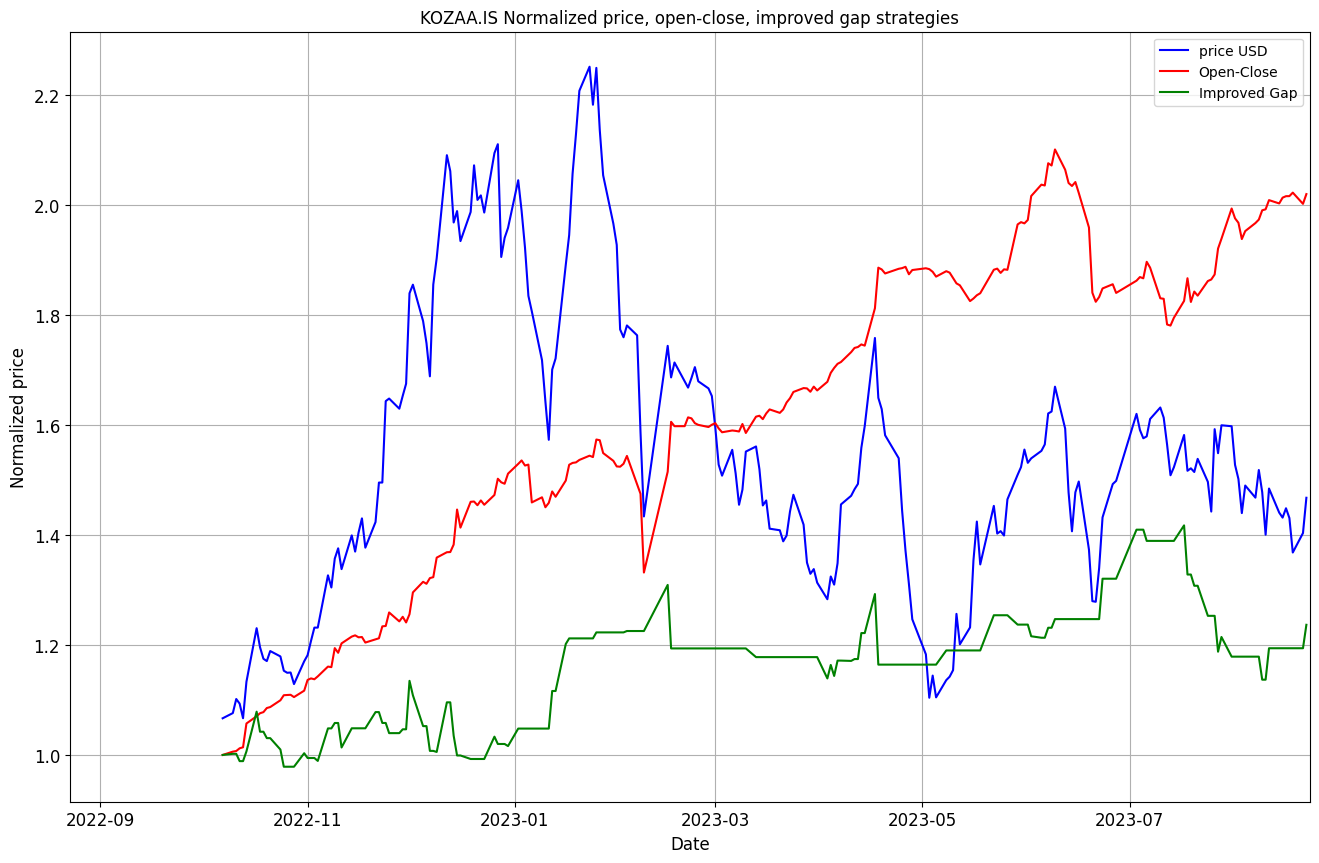


Creating Tear Sheet for KOZAA.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ALARK.IS : 



Updating data for ALARK.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for ALARK.IS

Plotting Open-Close Performance for ALARK.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


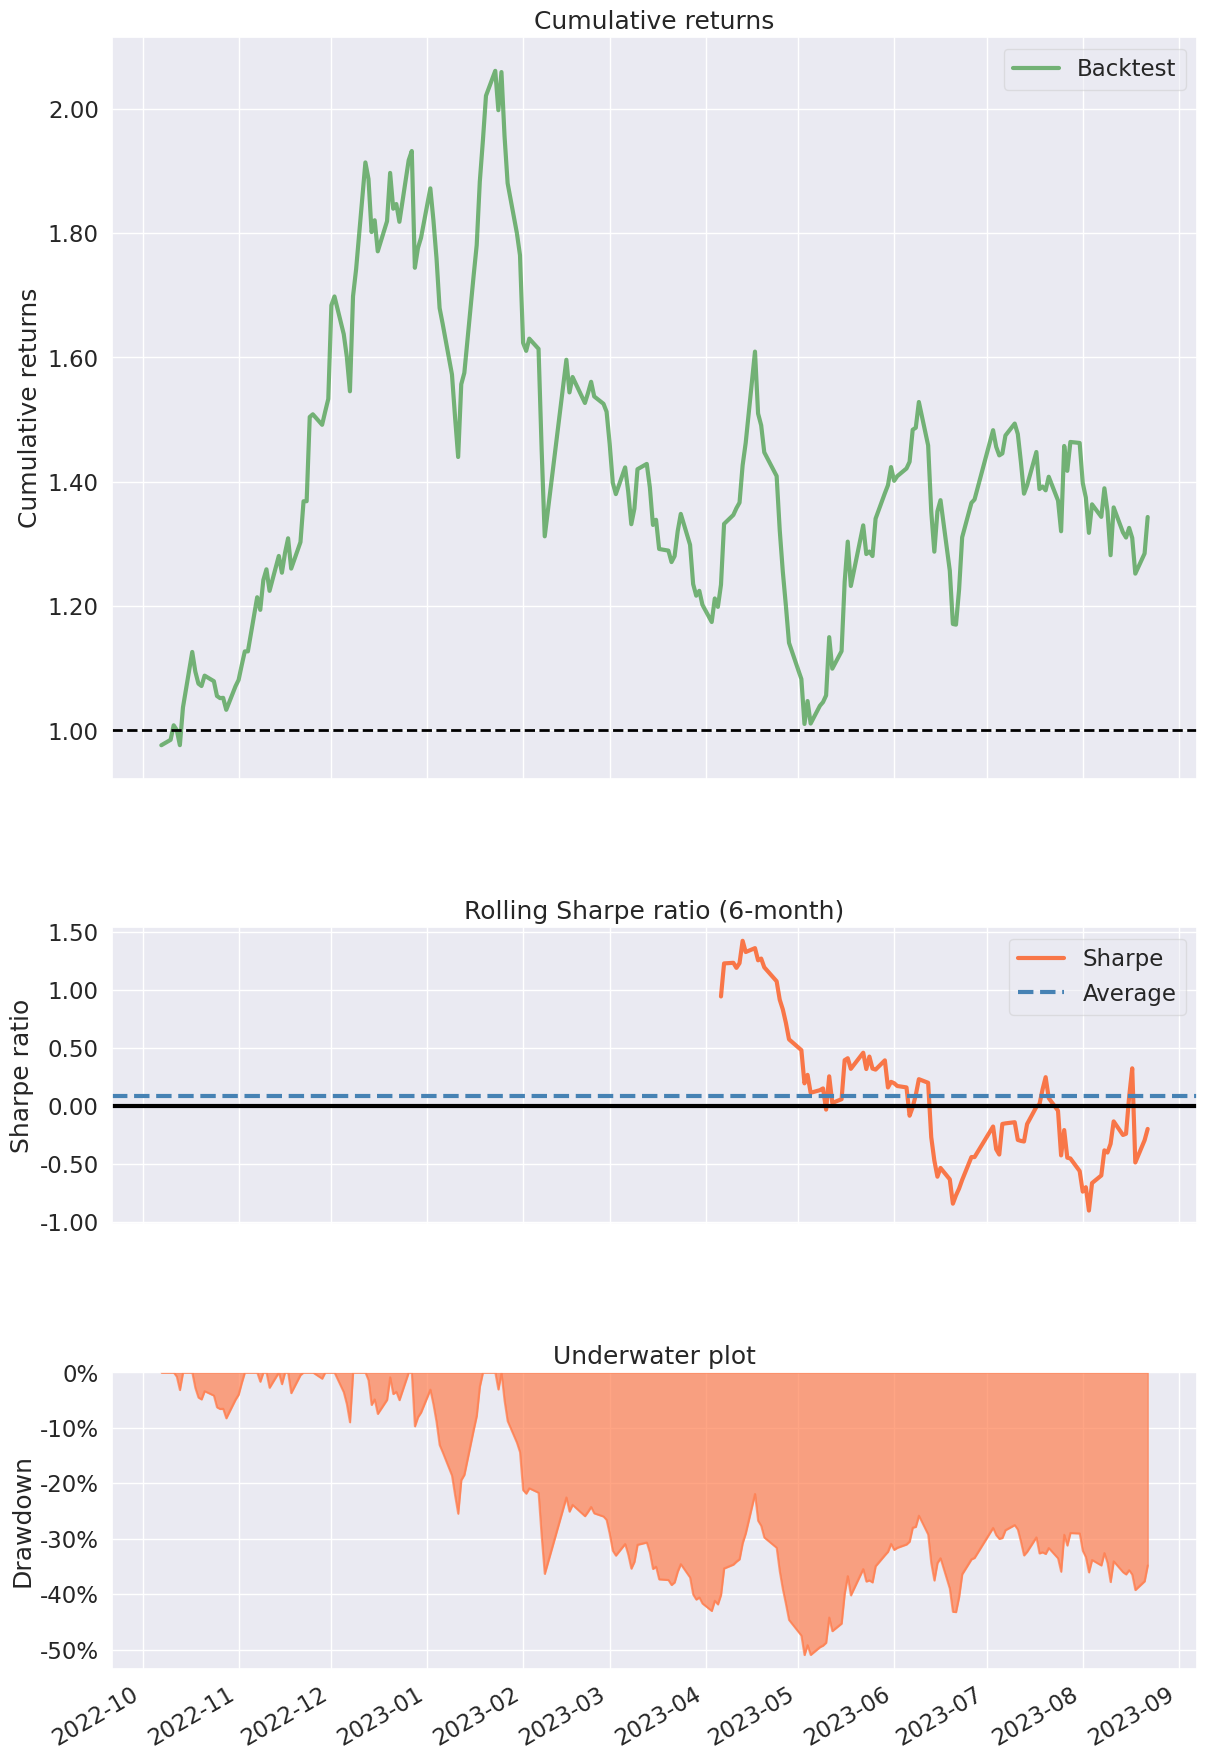

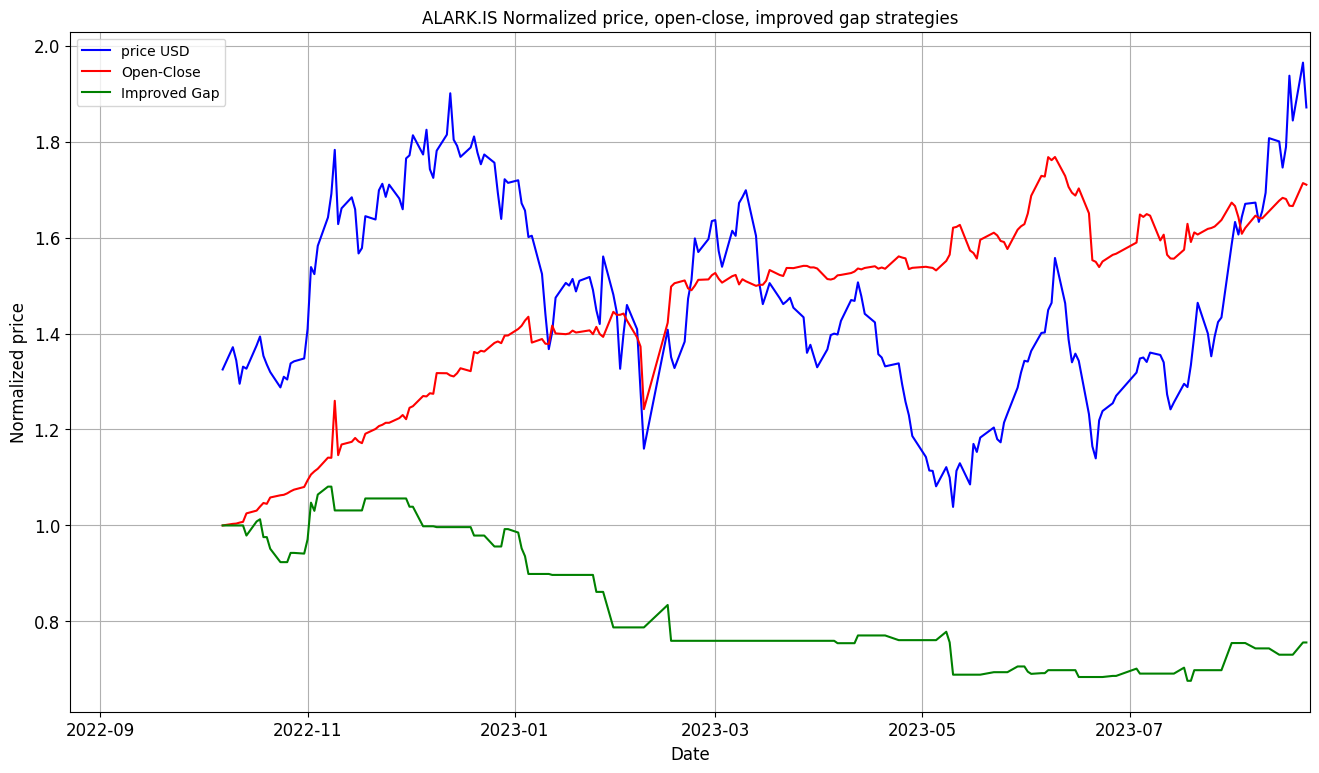


Creating Tear Sheet for ALARK.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ENKAI.IS : 



Updating data for ENKAI.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for ENKAI.IS

Plotting Open-Close Performance for ENKAI.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


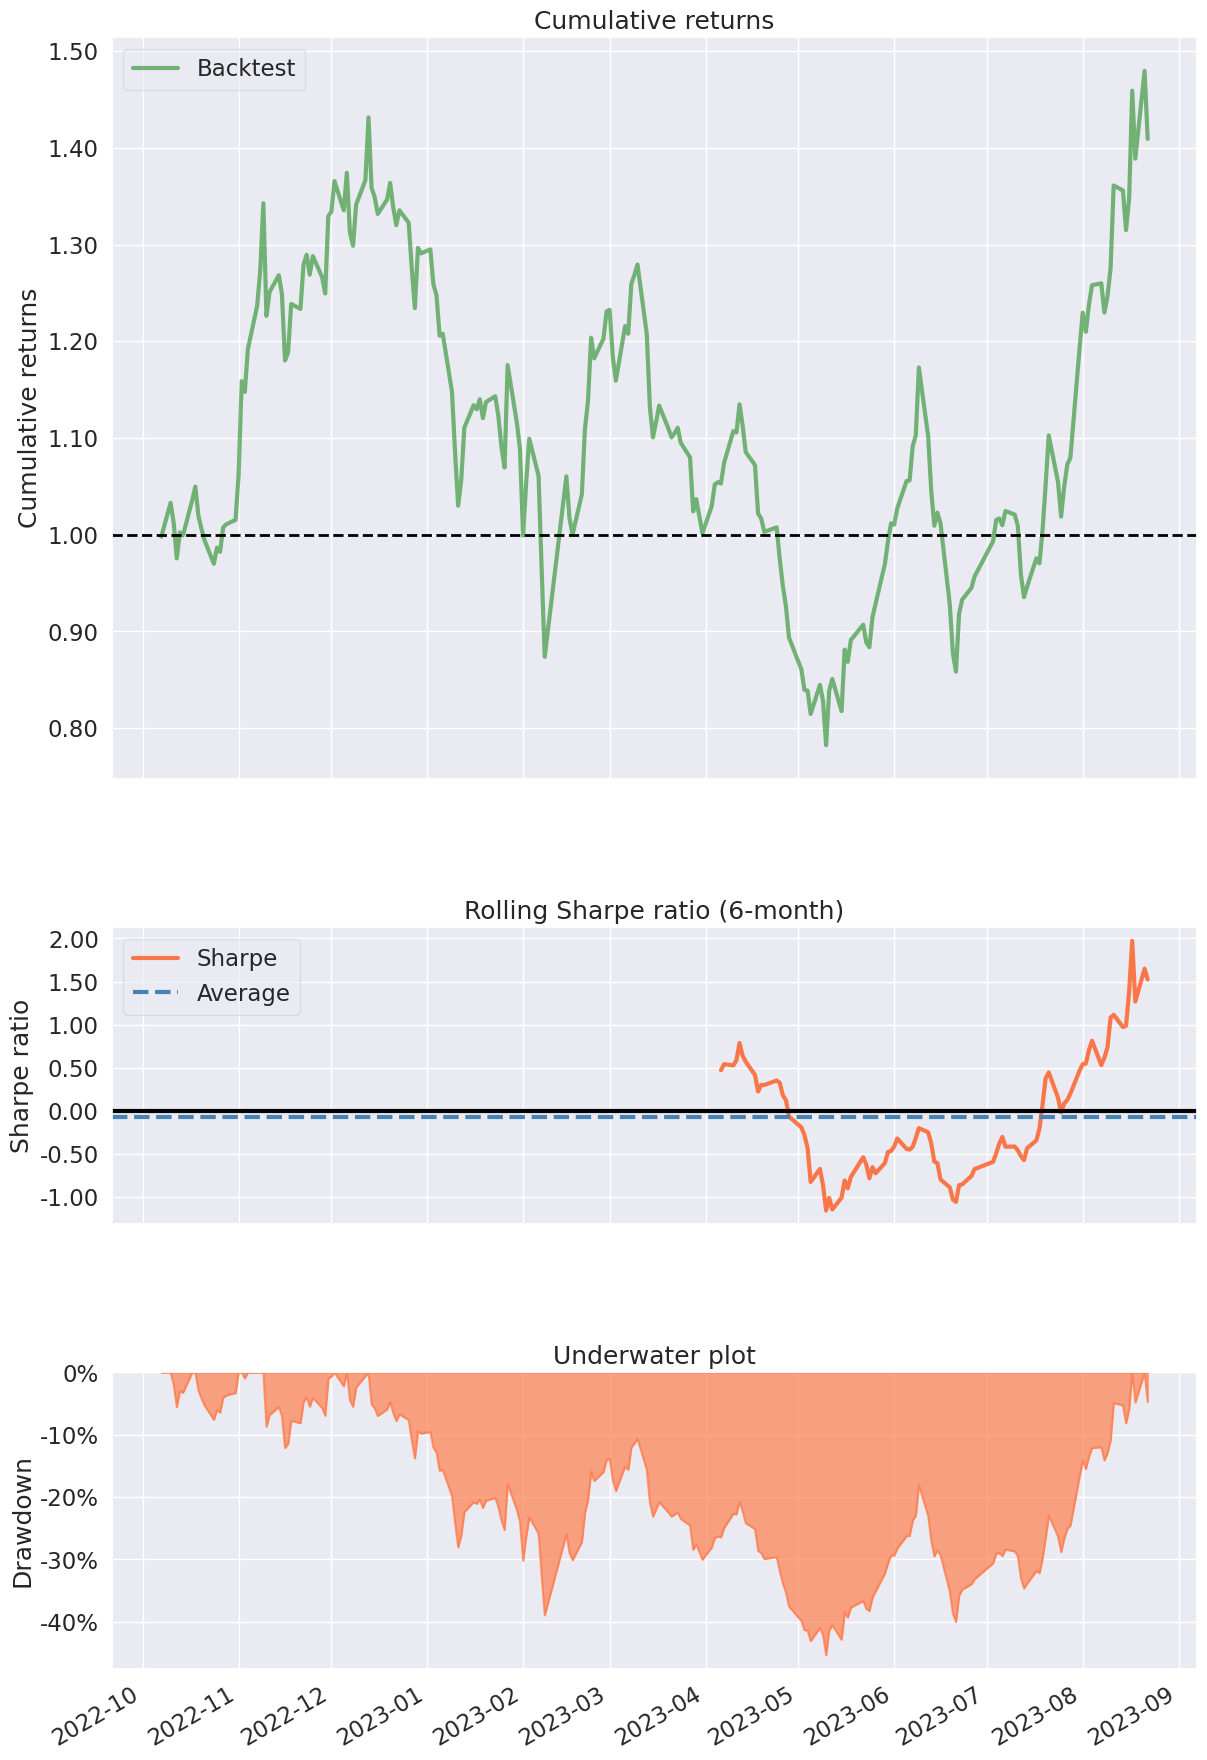

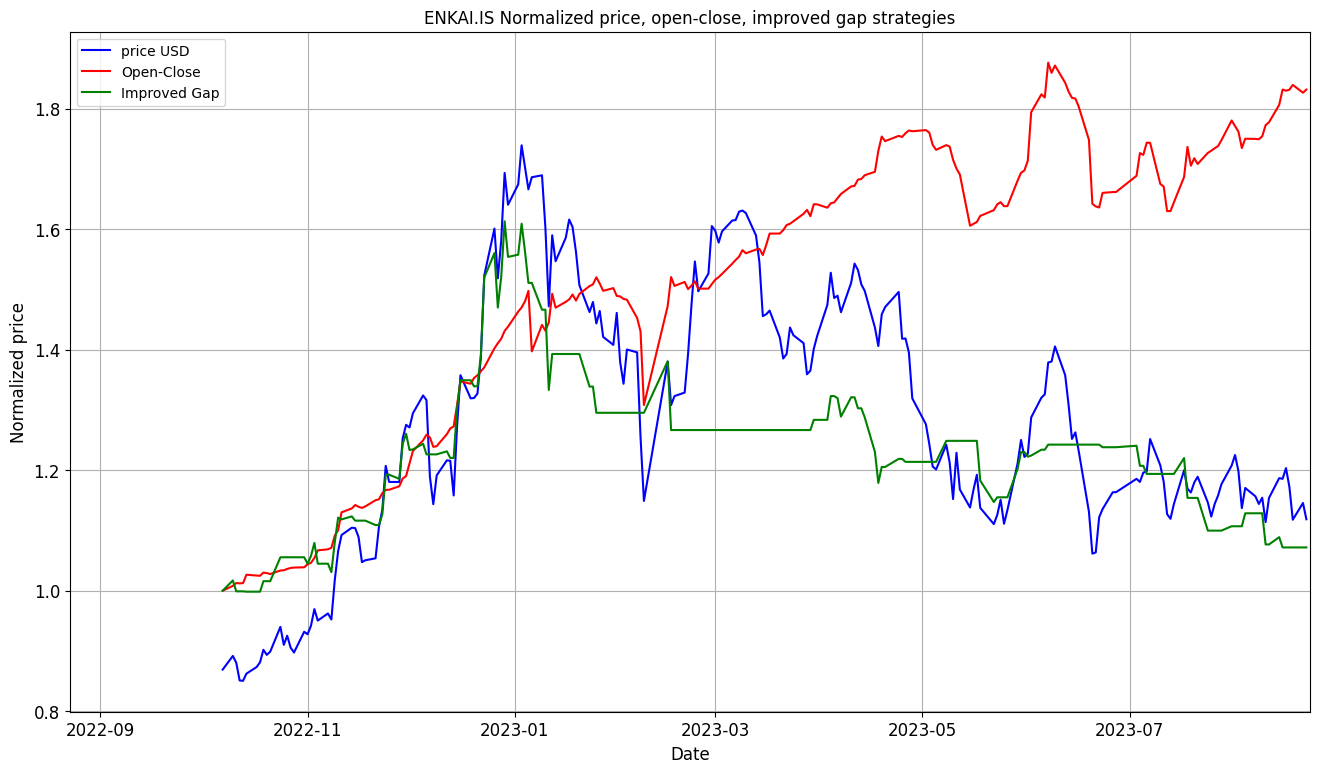


Creating Tear Sheet for ENKAI.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for TCELL.IS : 



Updating data for TCELL.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for TCELL.IS

Plotting Open-Close Performance for TCELL.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


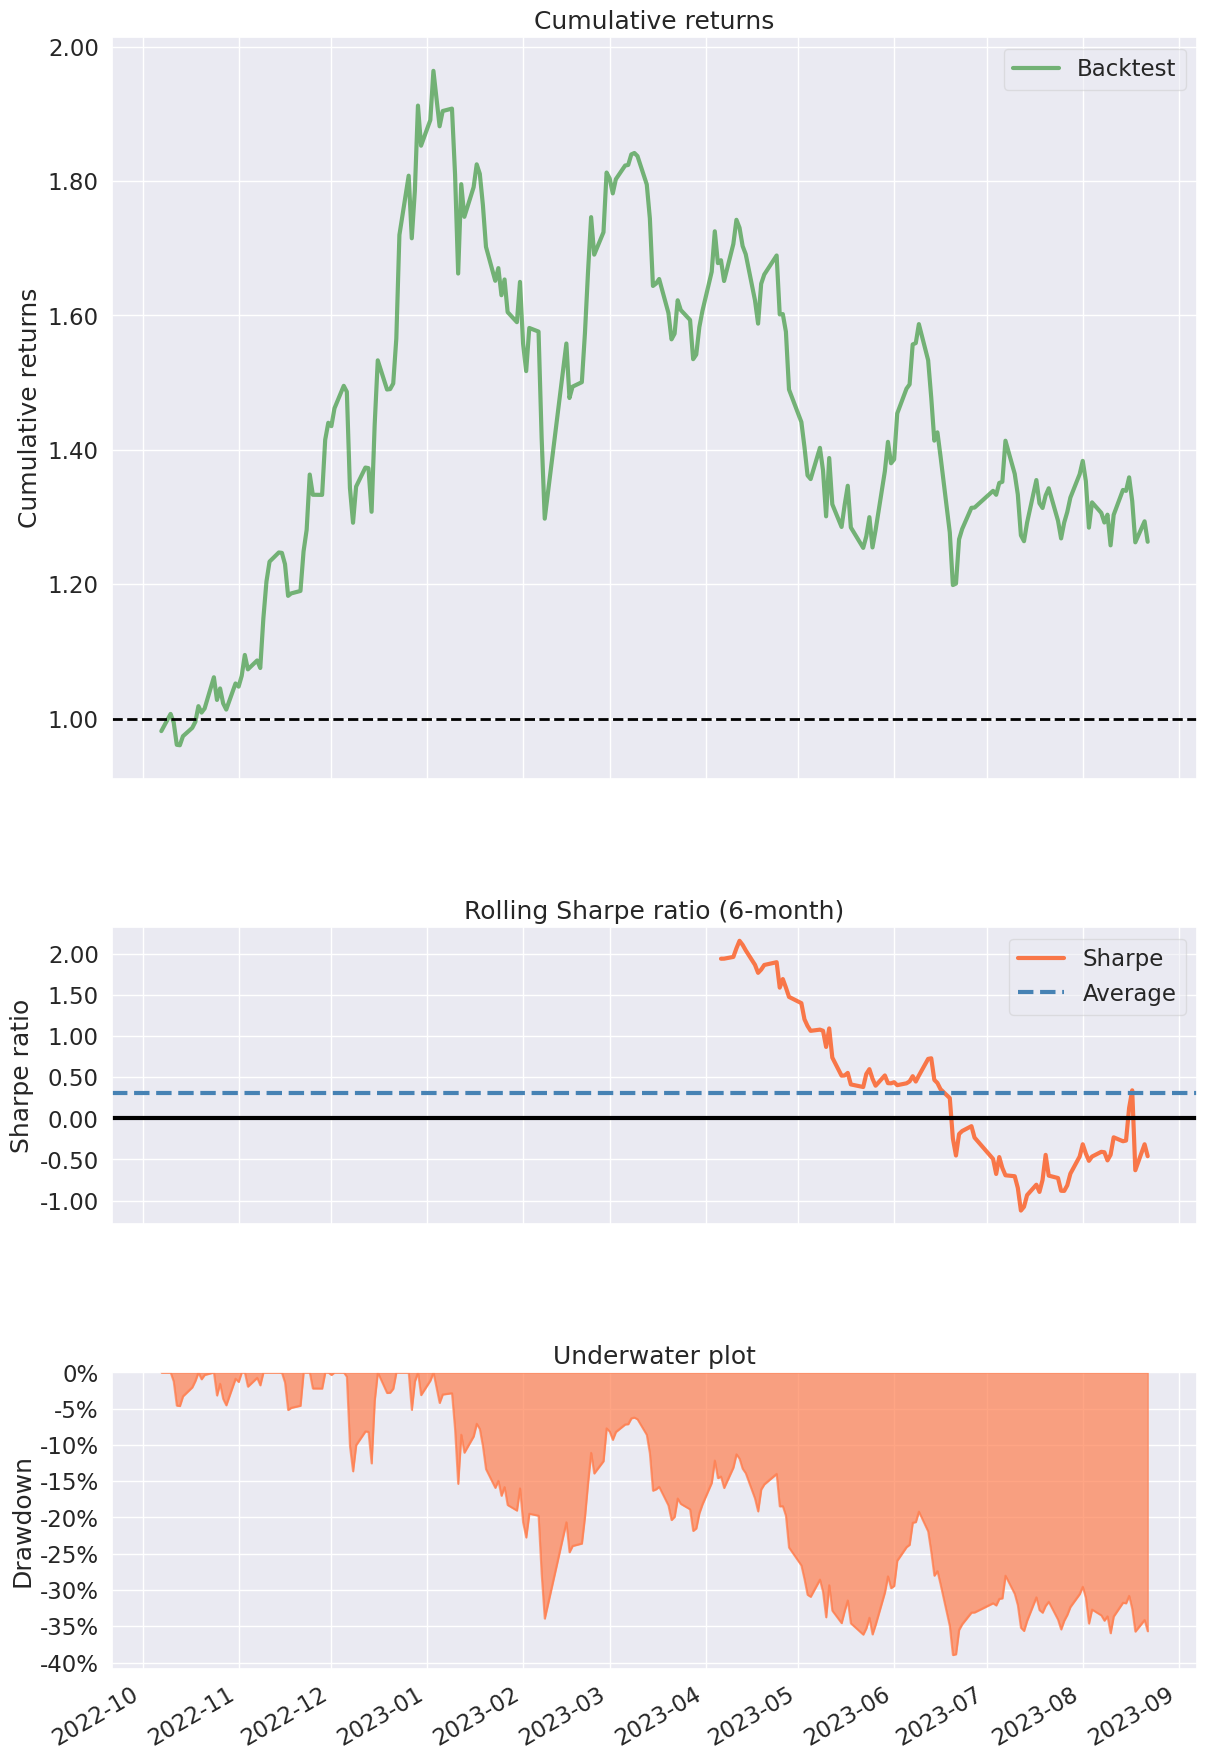

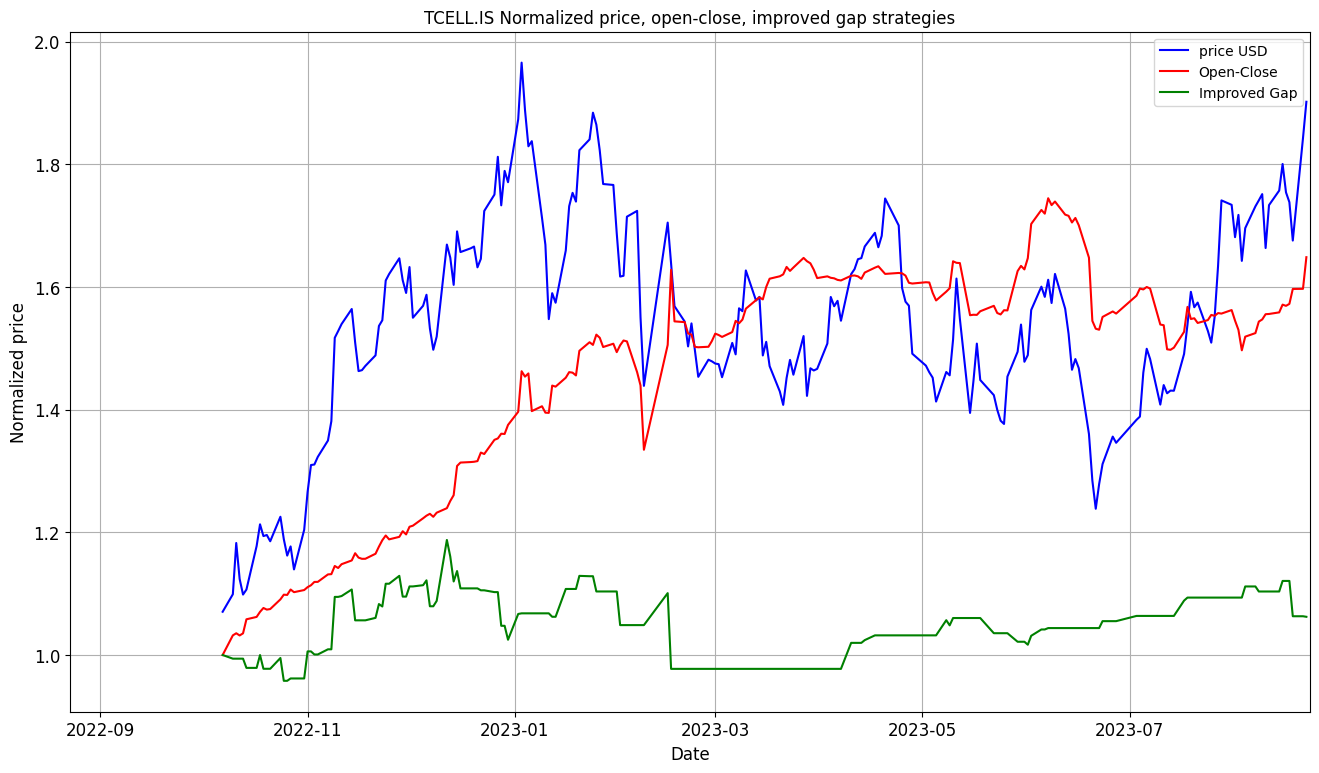


Creating Tear Sheet for TCELL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for TAVHL.IS : 



Updating data for TAVHL.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for TAVHL.IS

Plotting Open-Close Performance for TAVHL.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


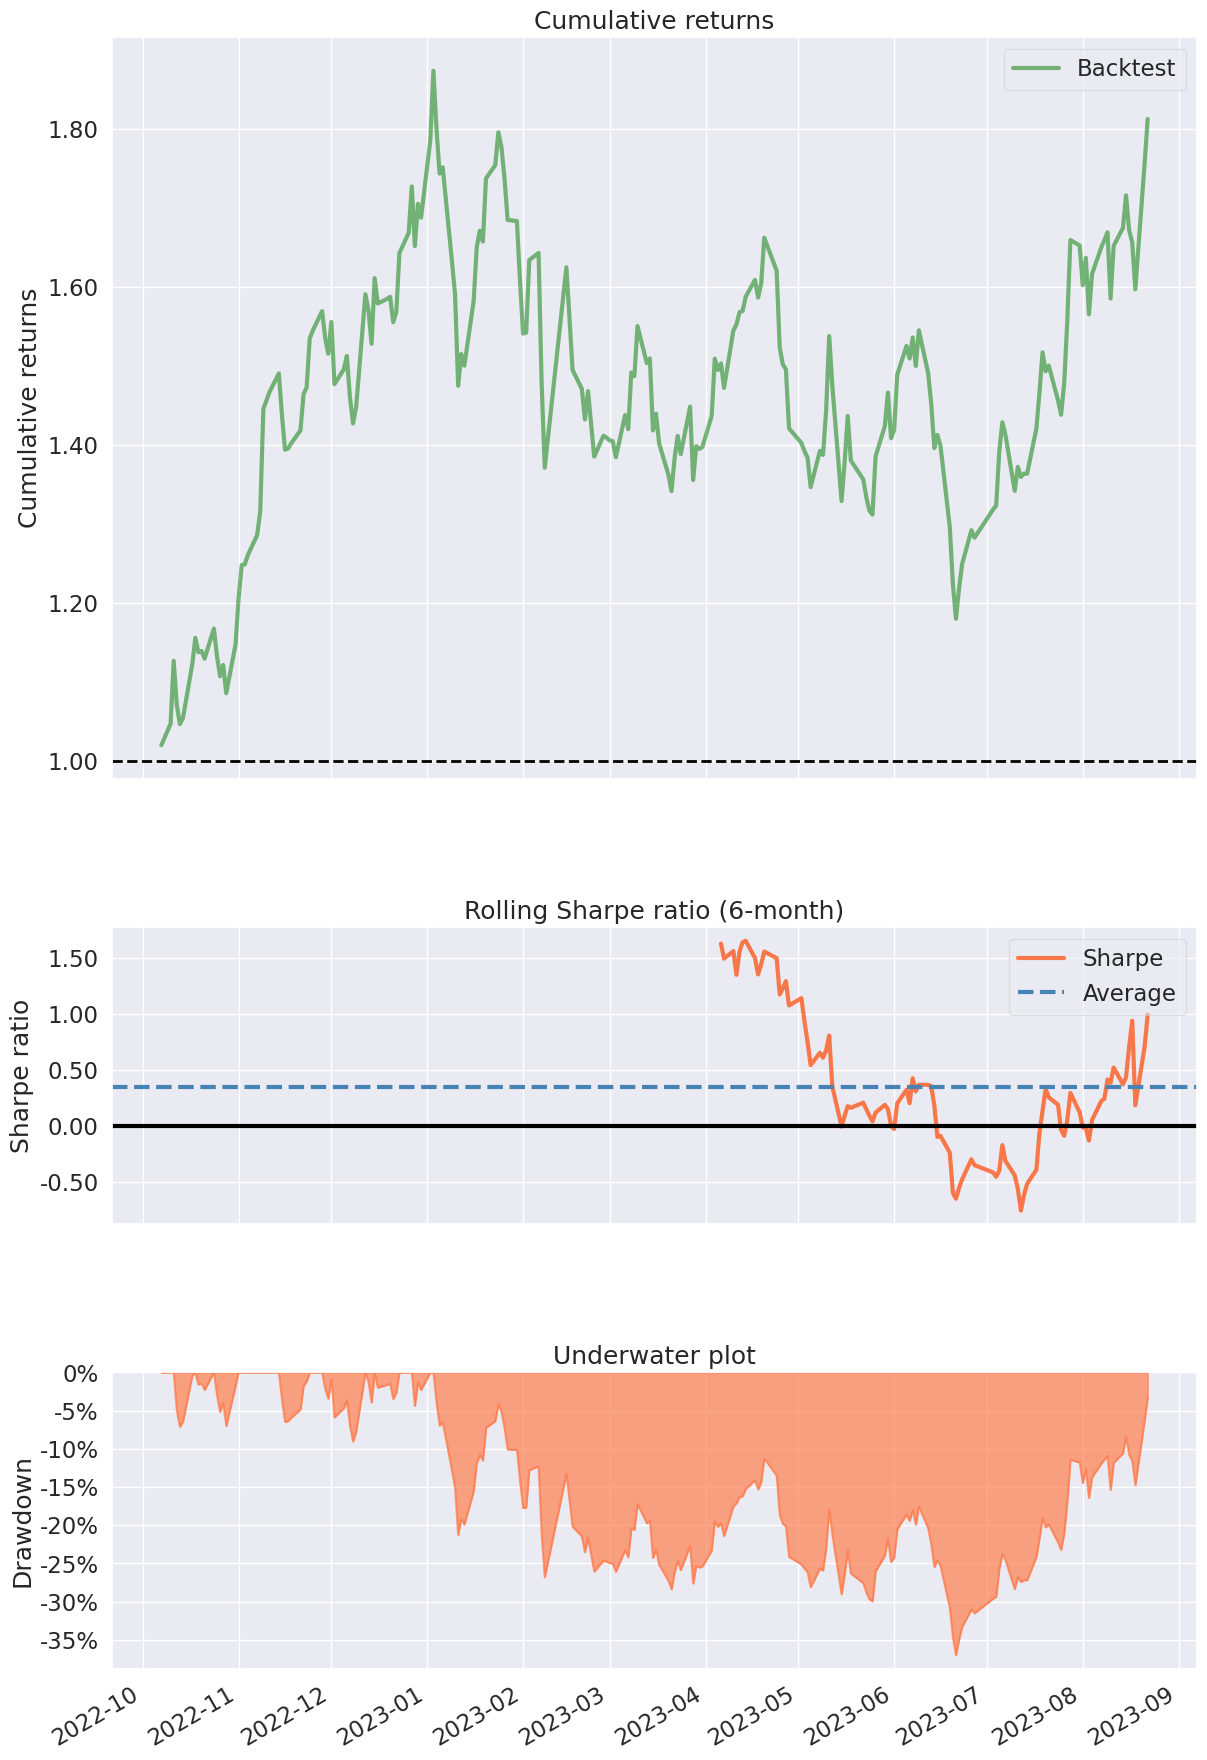

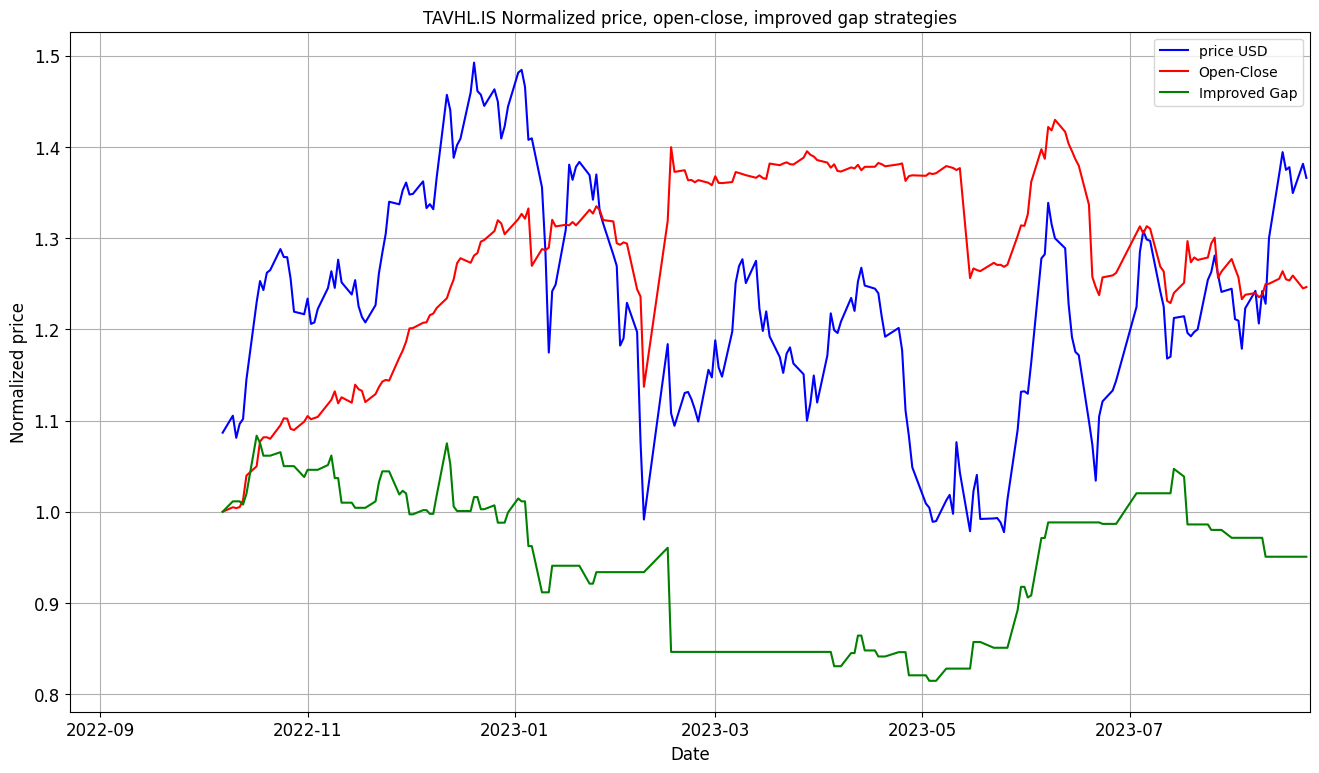


Creating Tear Sheet for TAVHL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


Streaming output truncated to the last 5000 lines.
Next State Probabilities for CCOLA.IS Buy-Hold: (-inf, 0.0], 0.555


Next State Probabilities for CCOLA.IS Open-Close (0.0, inf], 0.527

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Next State Probabilities for CEMTS.IS Buy-Hold: (-inf, 0.0], 0.509


Next State Probabilities for CEMTS.IS Open-Close (0.0, inf], 0.607

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Next State Probabilities for CIMSA.IS Buy-Hold: (0.0, inf], 0.56


Next State Probabilities for CIMSA.IS Open-Close (-inf

<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


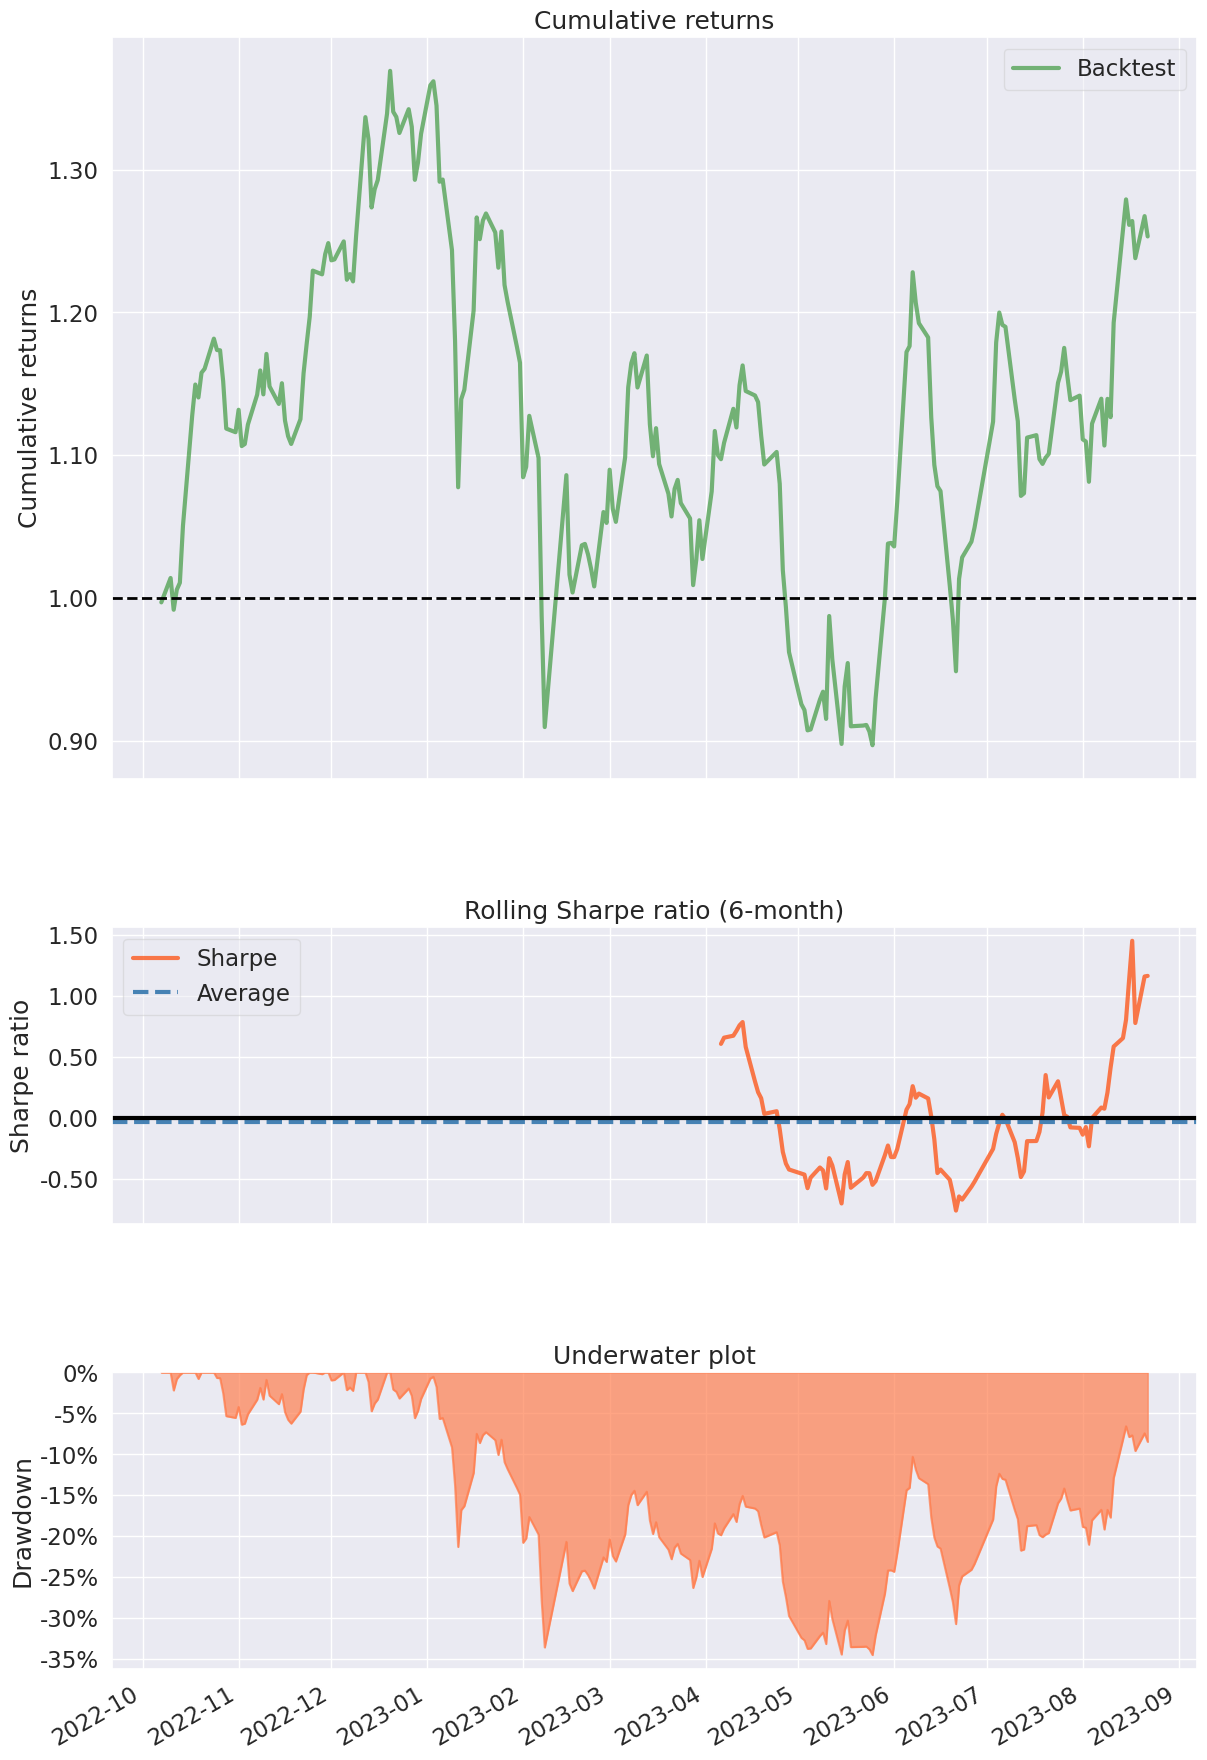

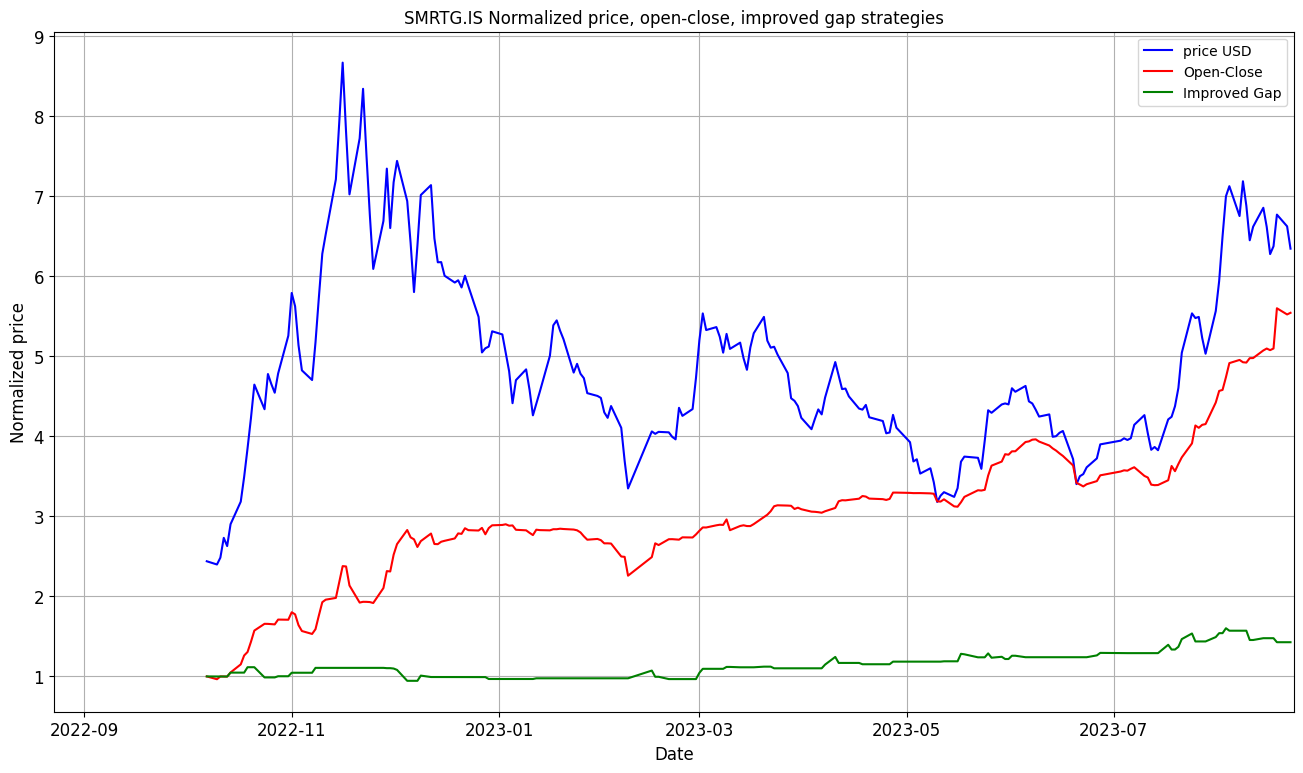


Creating Tear Sheet for SMRTG.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for KONYA.IS : 



Updating data for KONYA.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for KONYA.IS

Plotting Open-Close Performance for KONYA.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


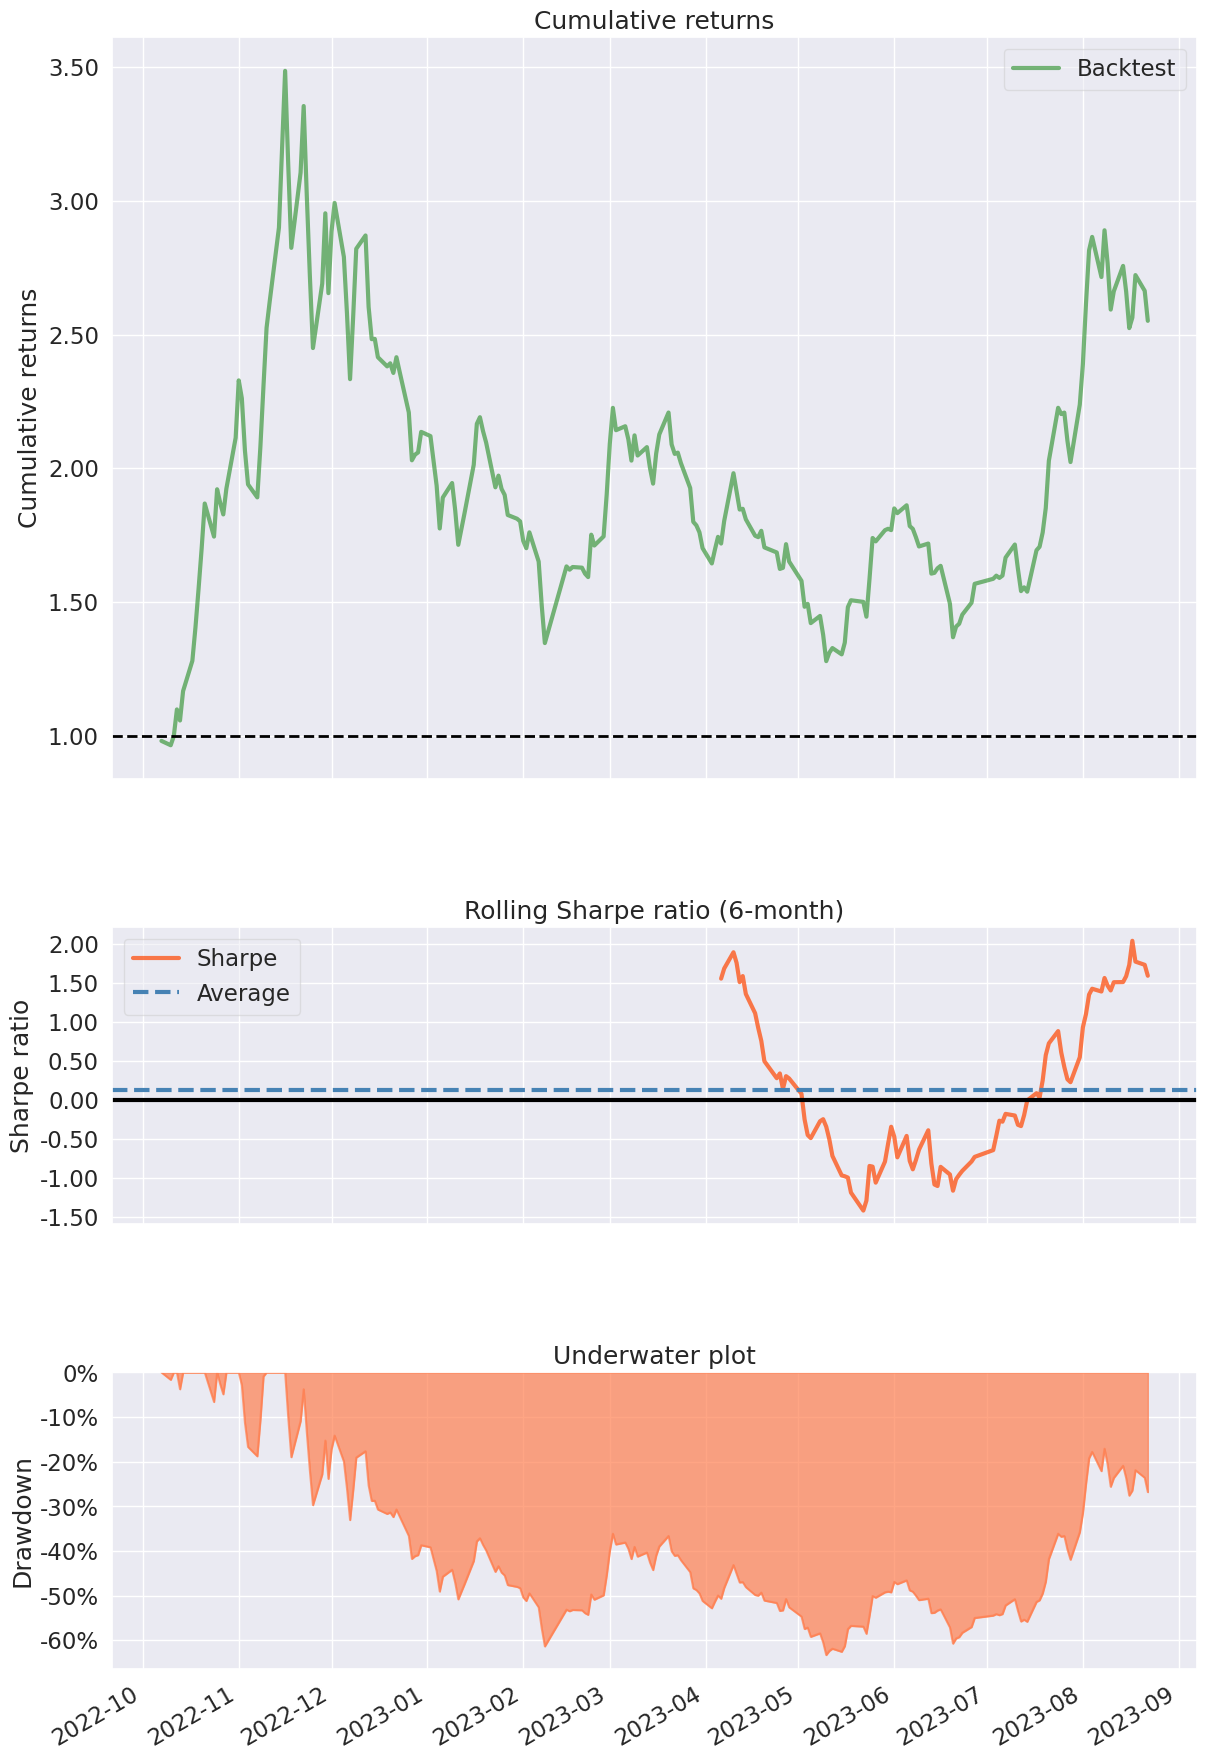

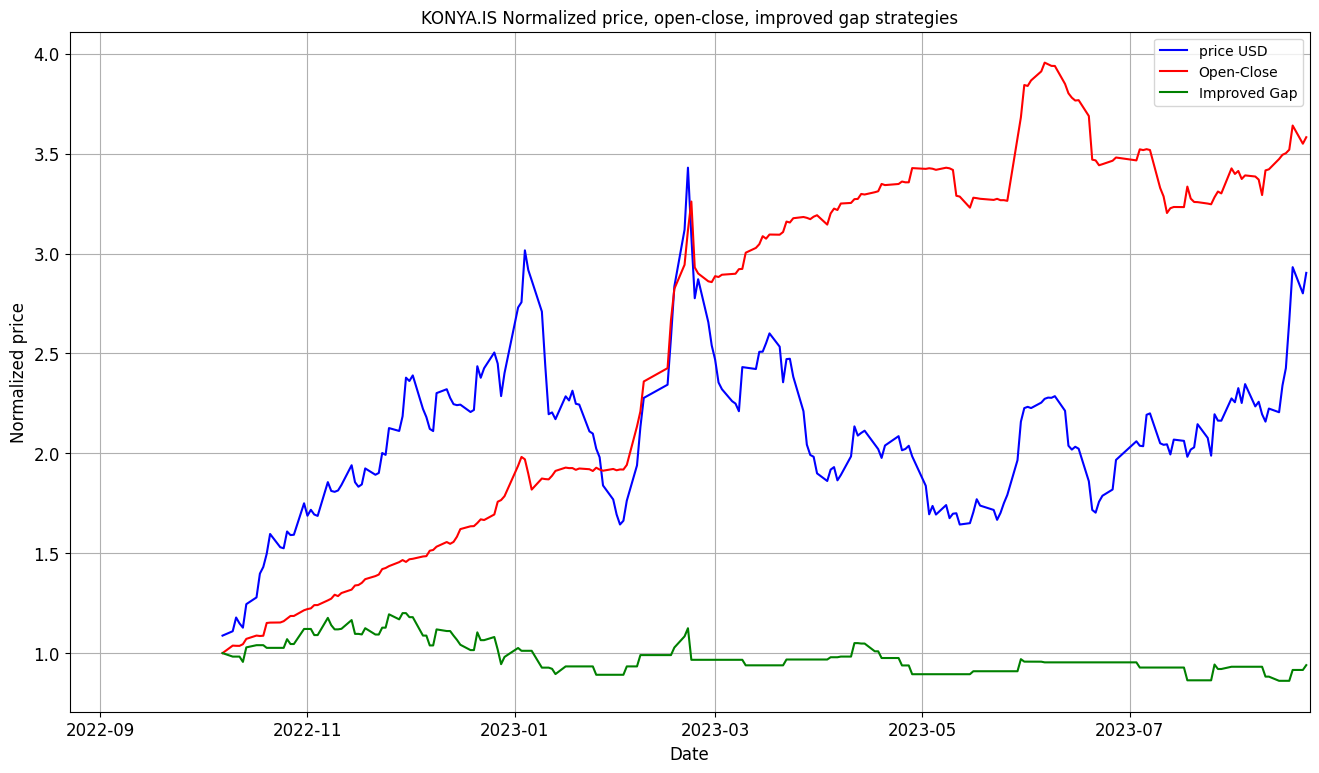


Creating Tear Sheet for KONYA.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for KOZAA.IS : 



Updating data for KOZAA.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for KOZAA.IS

Plotting Open-Close Performance for KOZAA.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


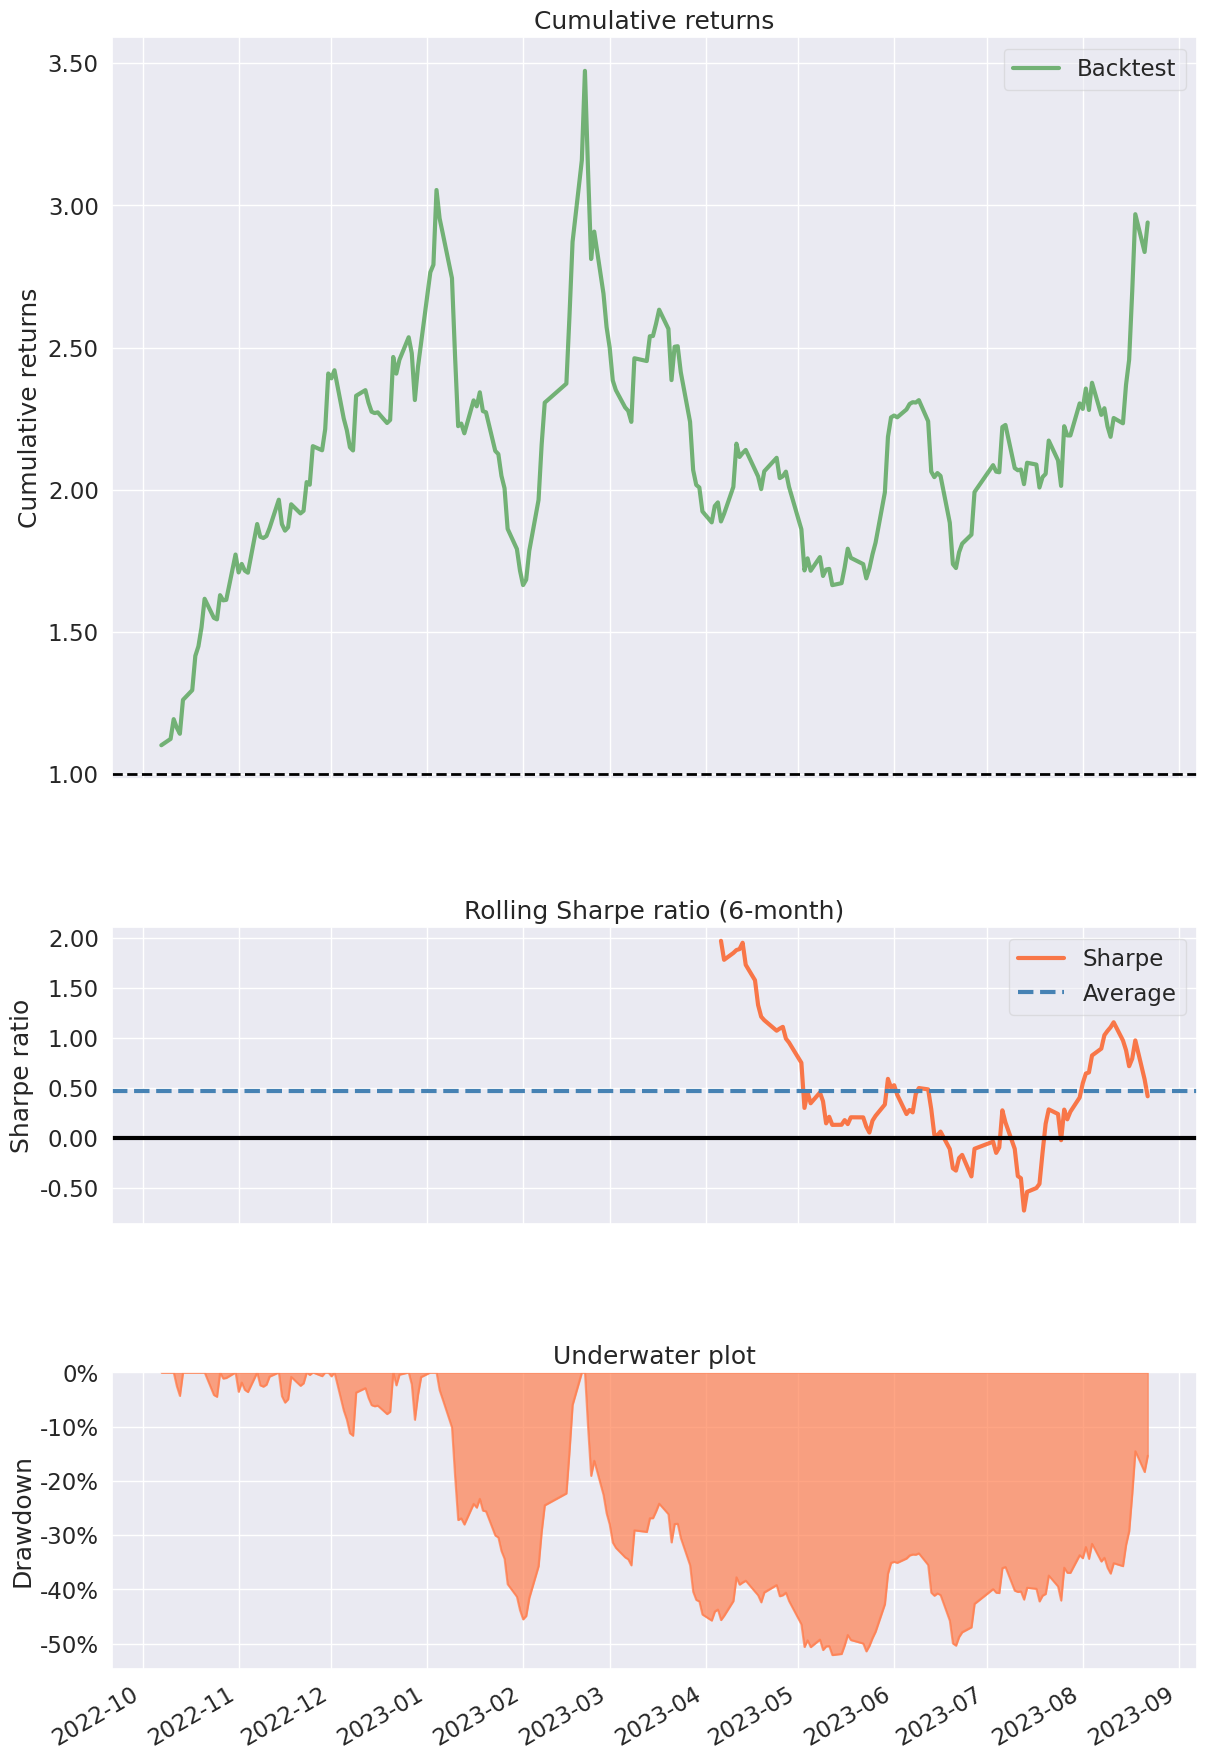

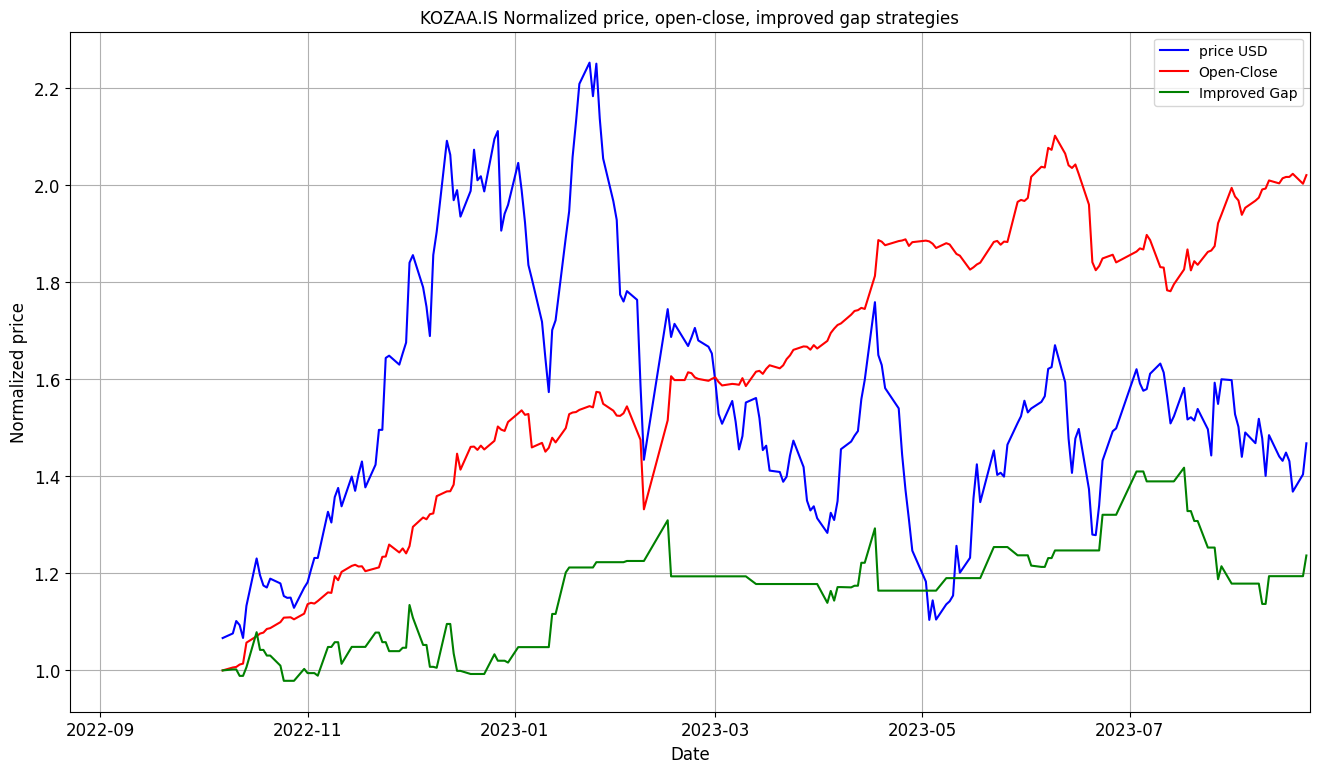


Creating Tear Sheet for KOZAA.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ECZYT.IS : 



Updating data for ECZYT.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for ECZYT.IS

Plotting Open-Close Performance for ECZYT.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


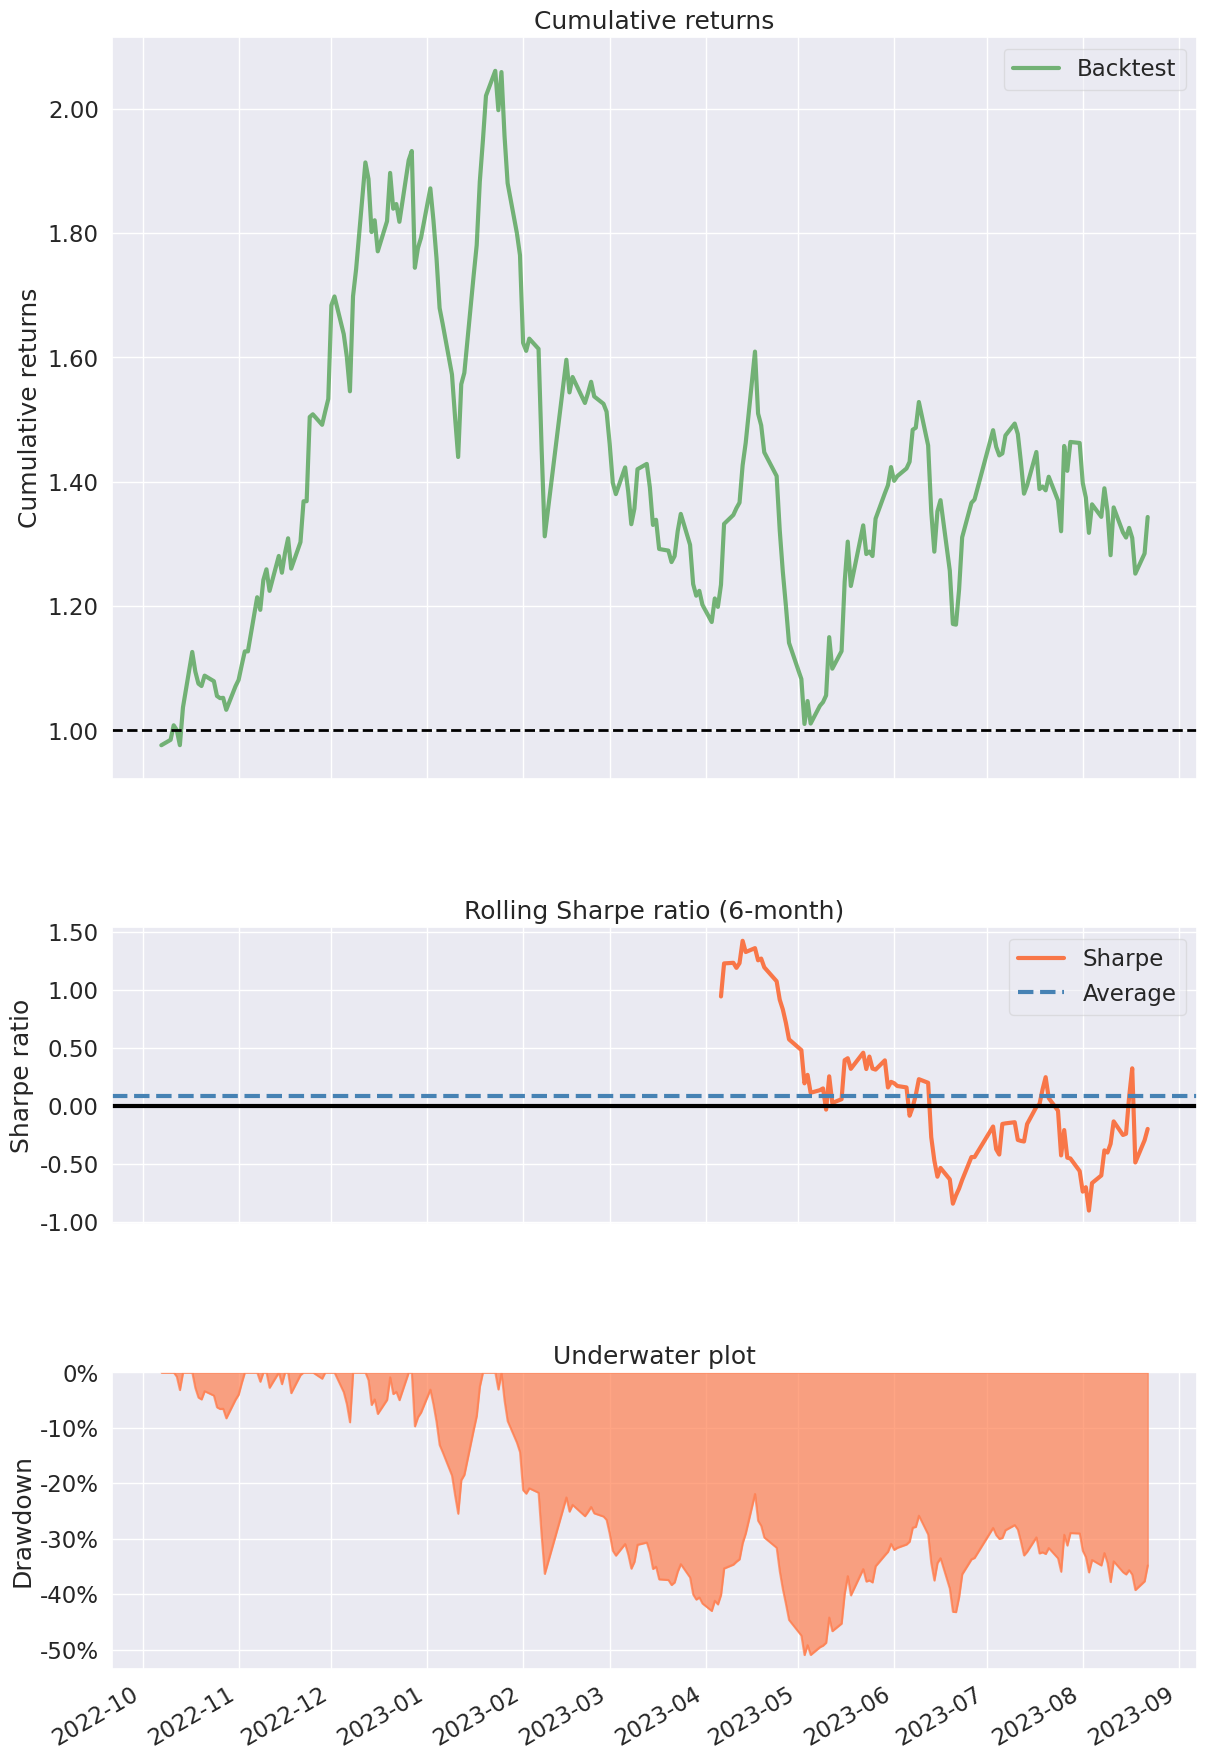

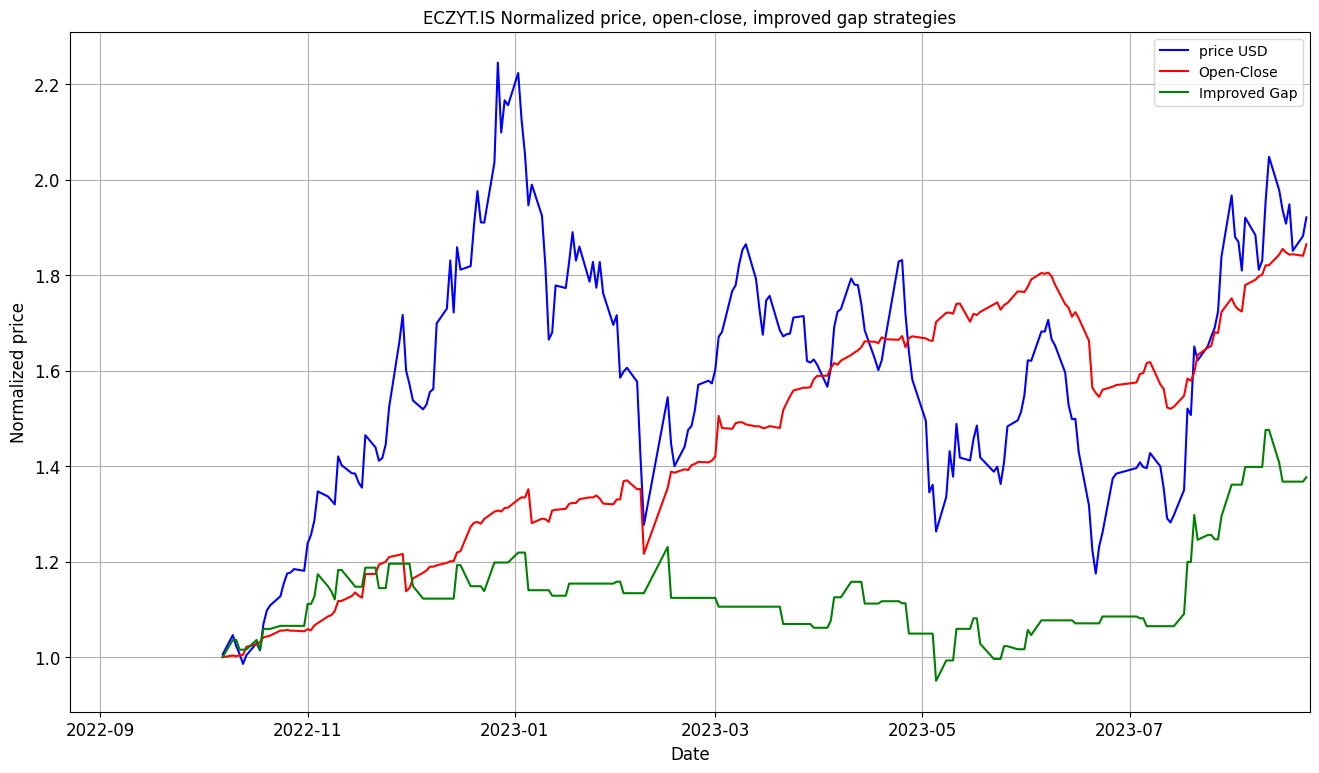


Creating Tear Sheet for ECZYT.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ALARK.IS : 



Updating data for ALARK.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for ALARK.IS

Plotting Open-Close Performance for ALARK.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


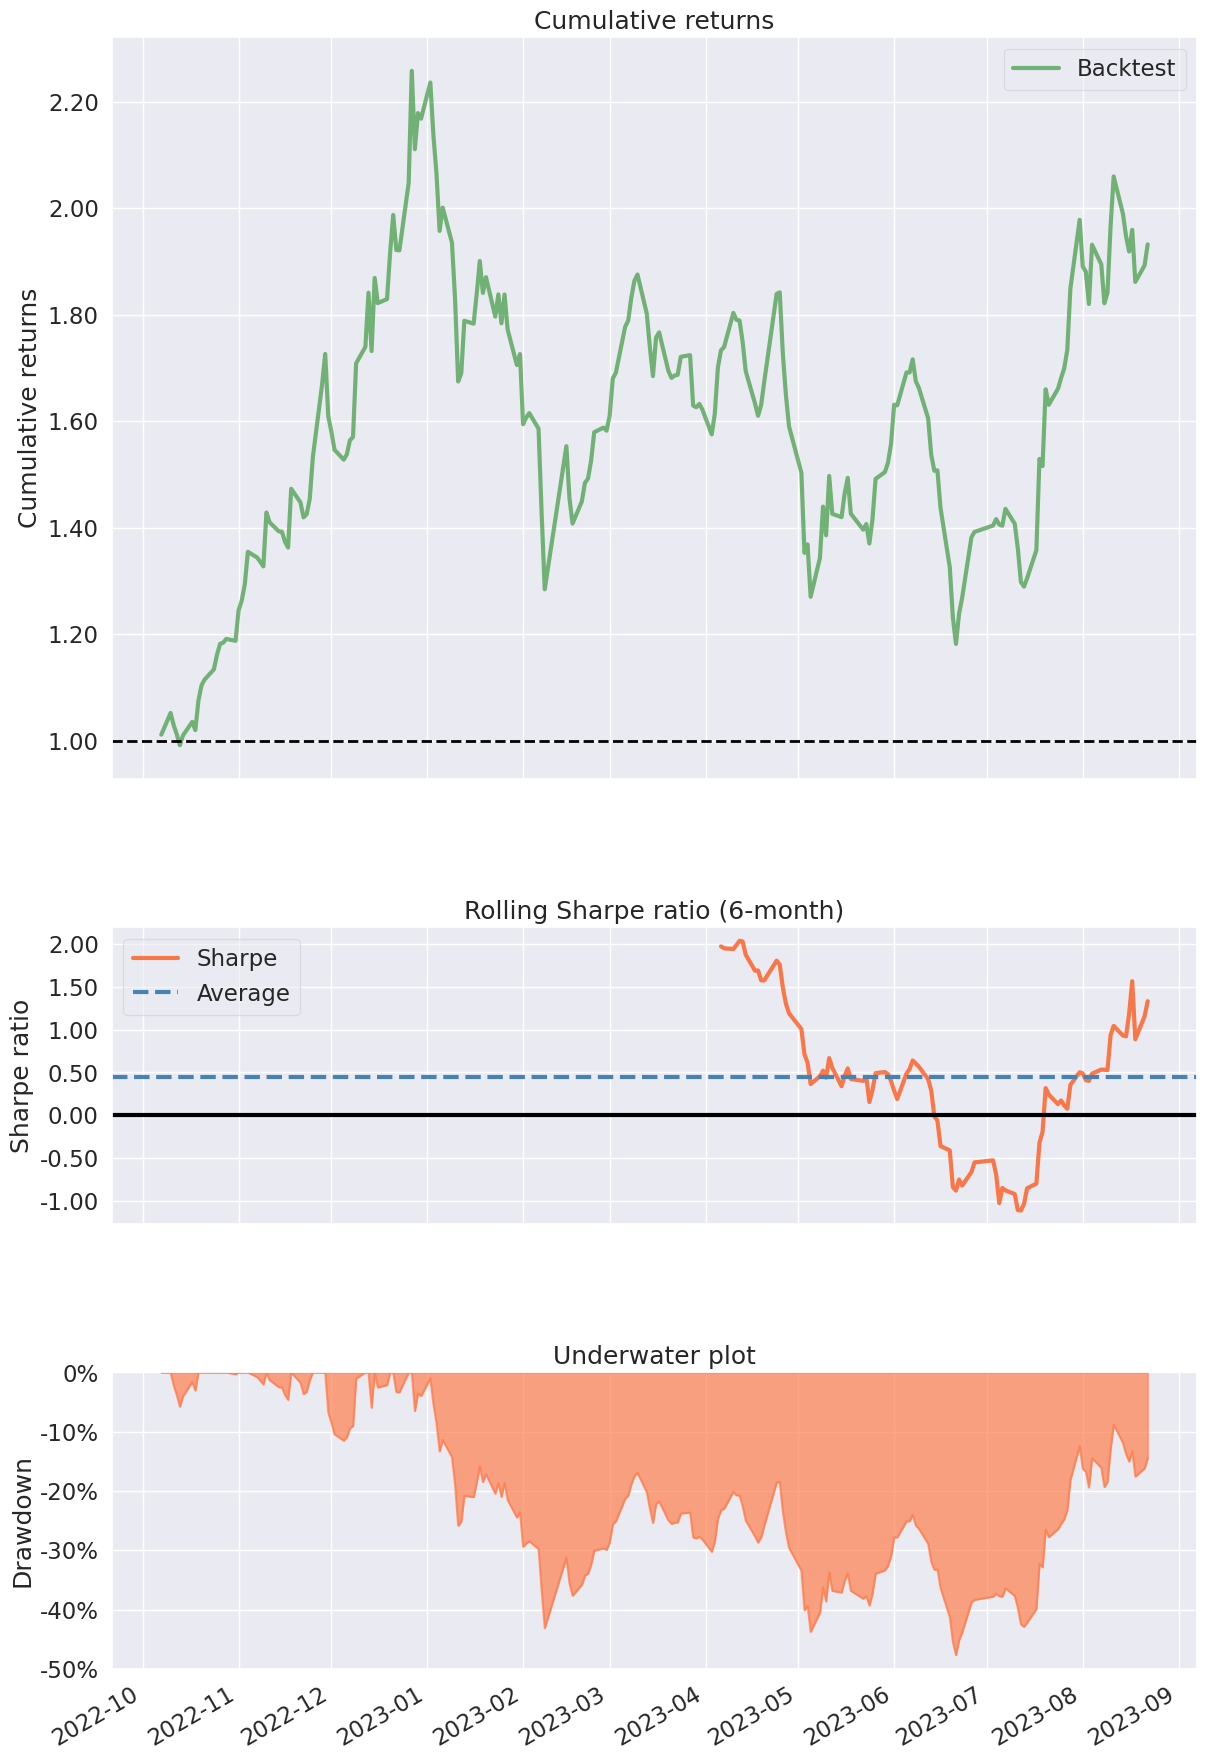

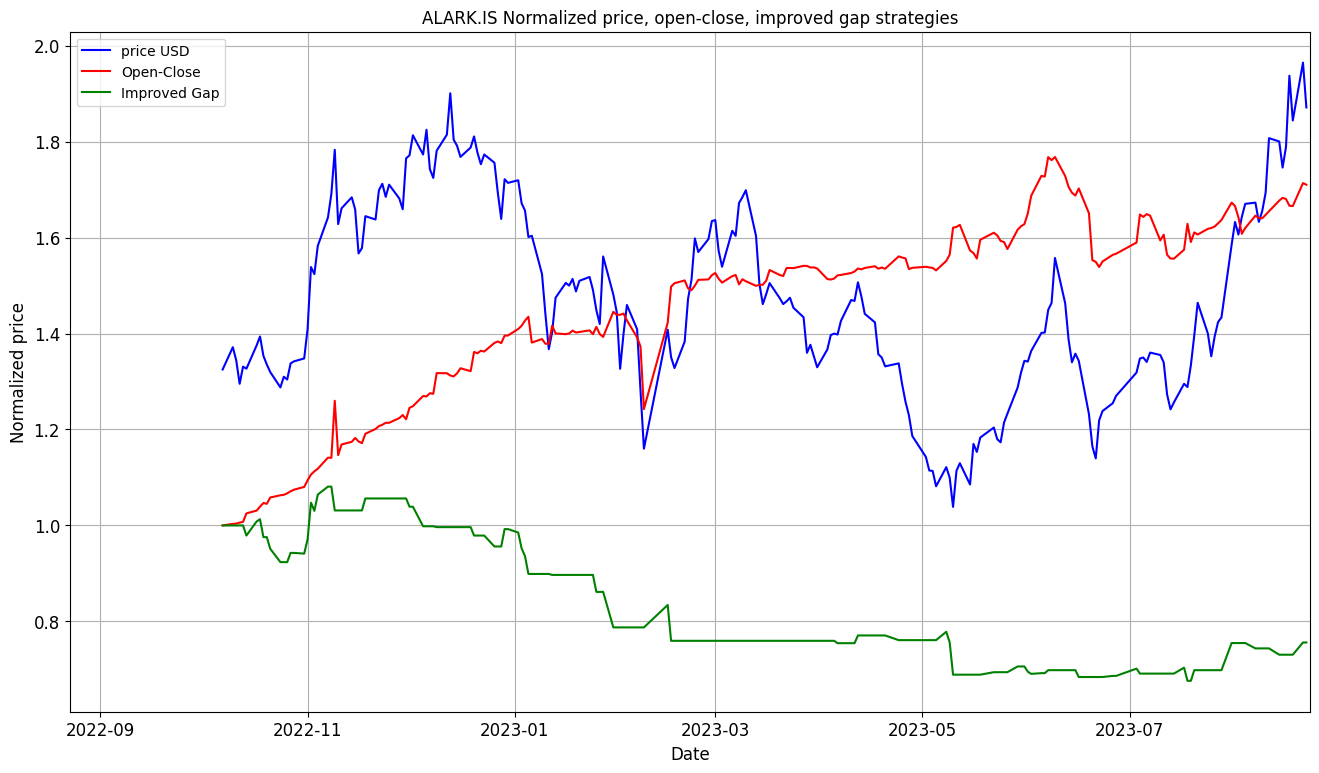


Creating Tear Sheet for ALARK.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for ENKAI.IS : 



Updating data for ENKAI.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for ENKAI.IS

Plotting Open-Close Performance for ENKAI.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


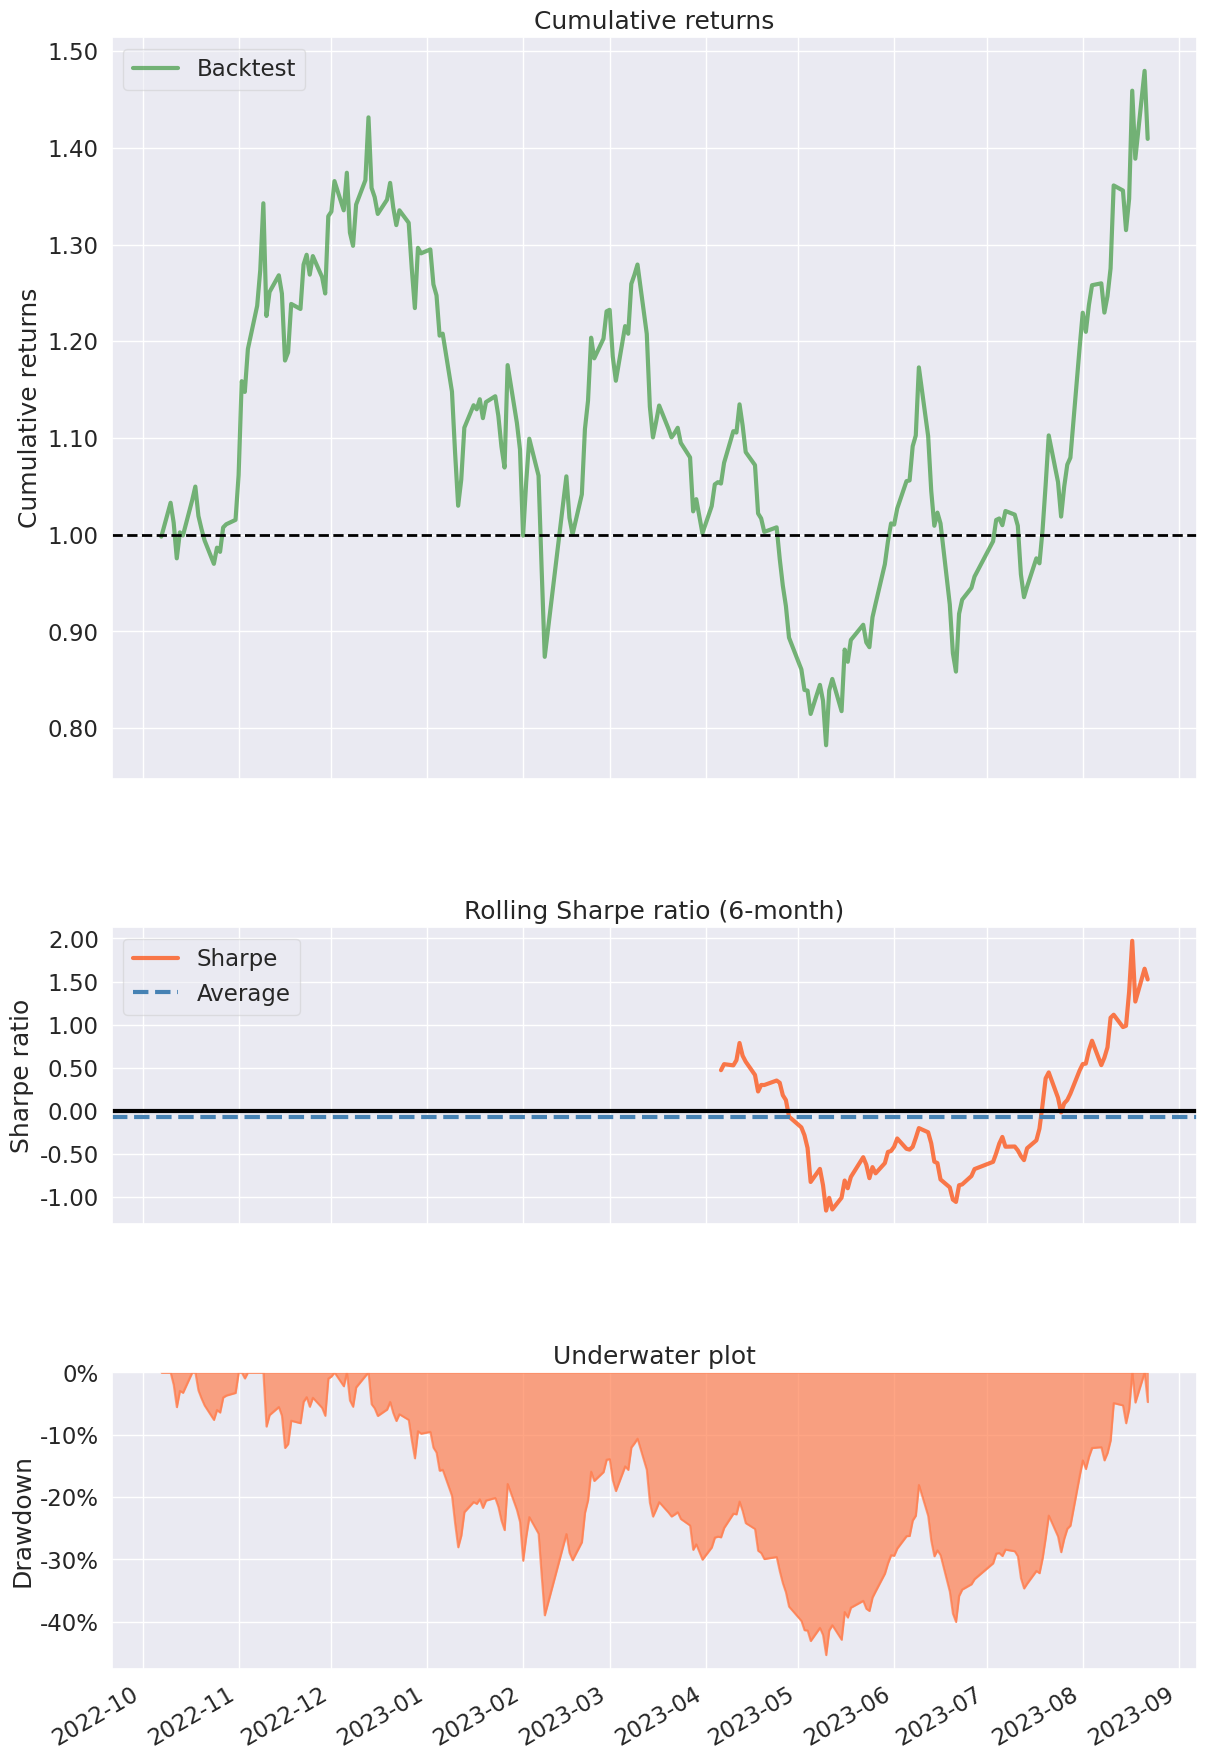

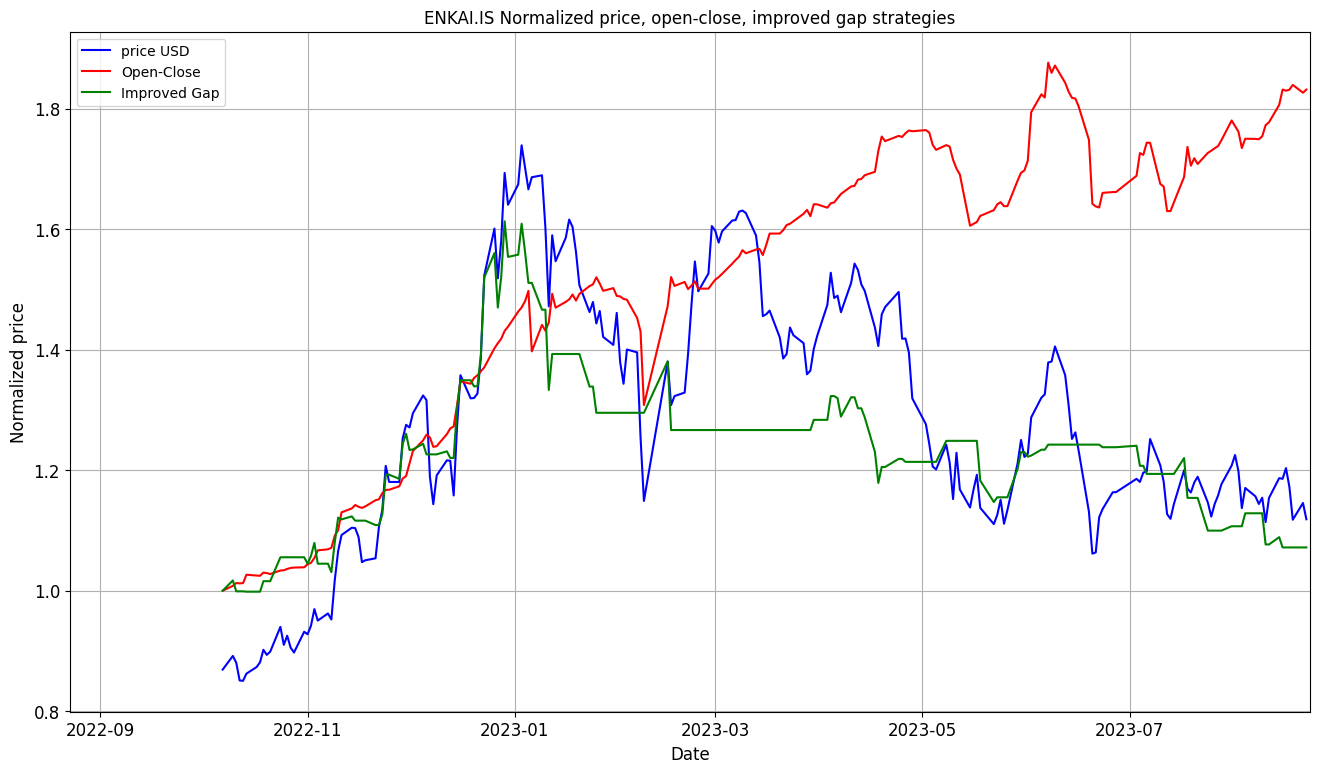


Creating Tear Sheet for ENKAI.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for TCELL.IS : 



Updating data for TCELL.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for TCELL.IS

Plotting Open-Close Performance for TCELL.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


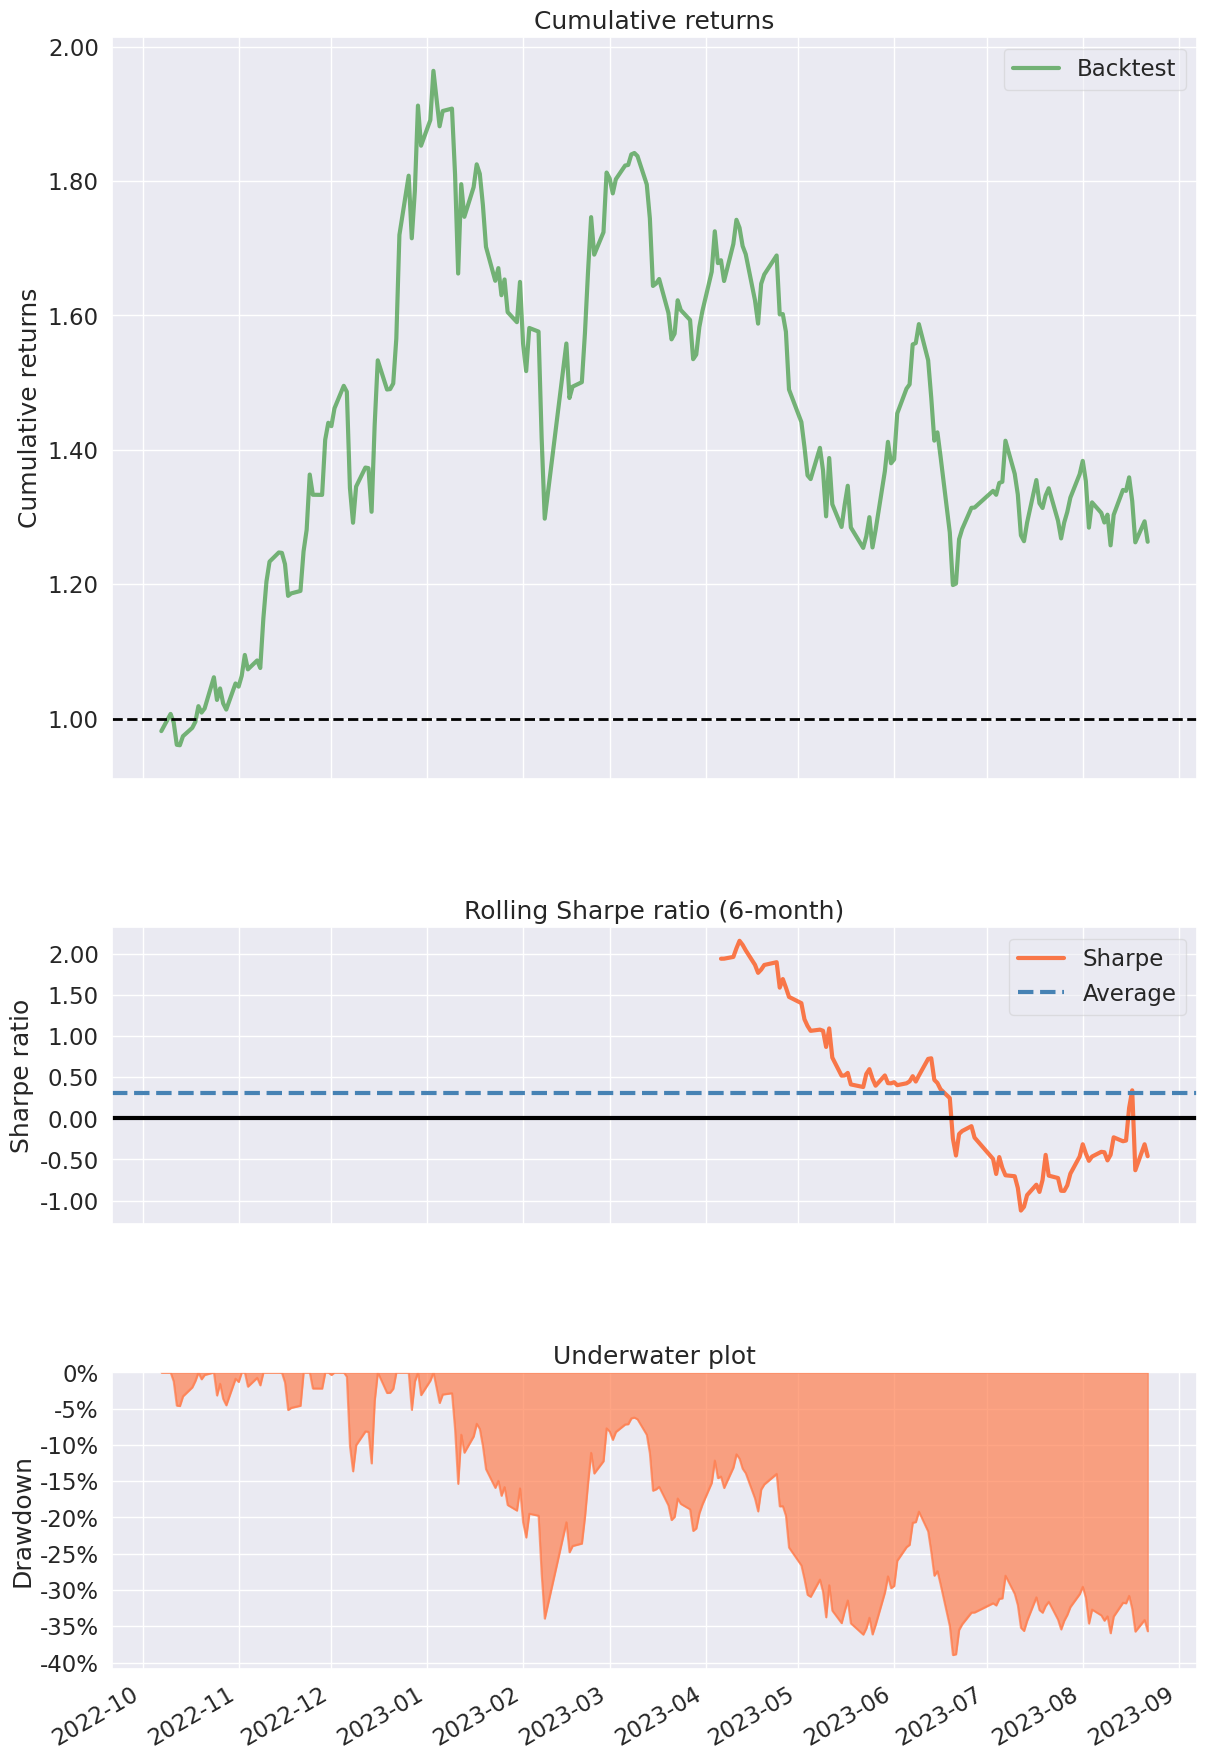

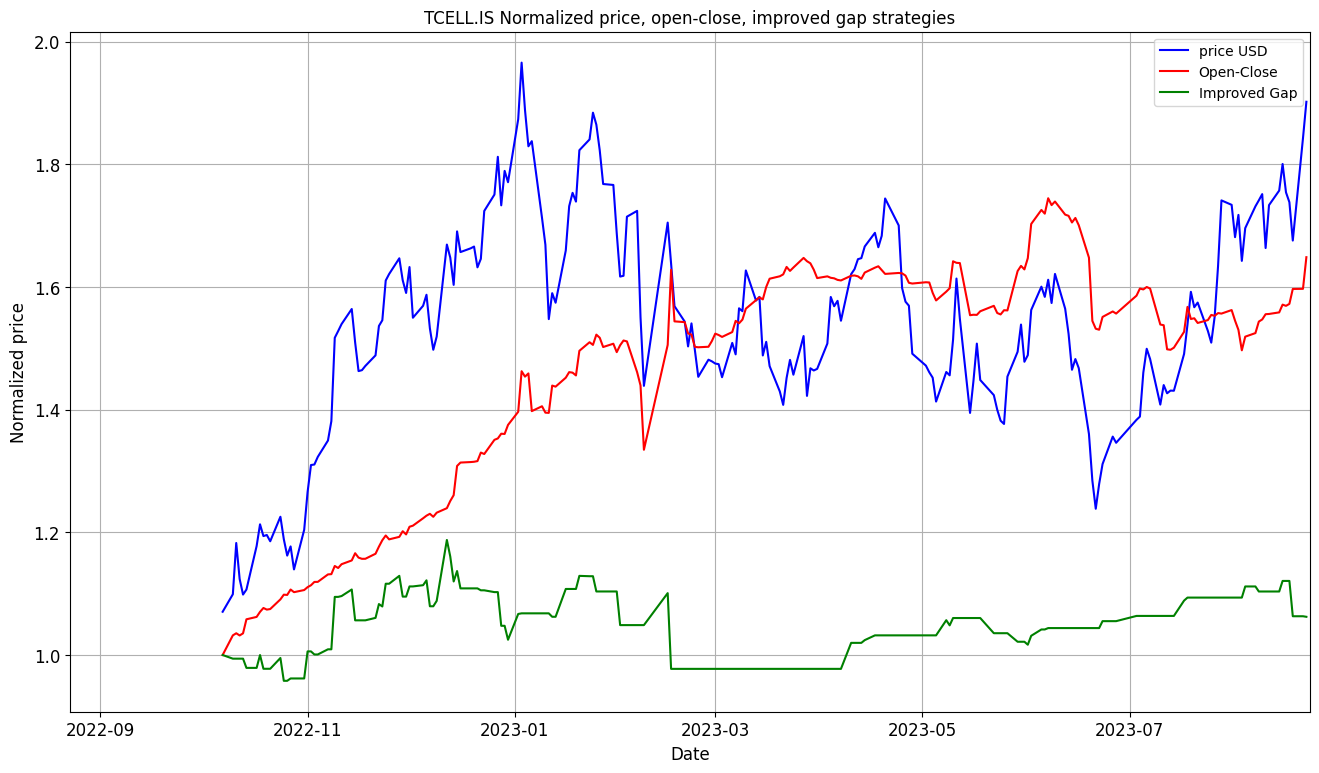


Creating Tear Sheet for TCELL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for GSDHO.IS : 



Updating data for GSDHO.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for GSDHO.IS

Plotting Open-Close Performance for GSDHO.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


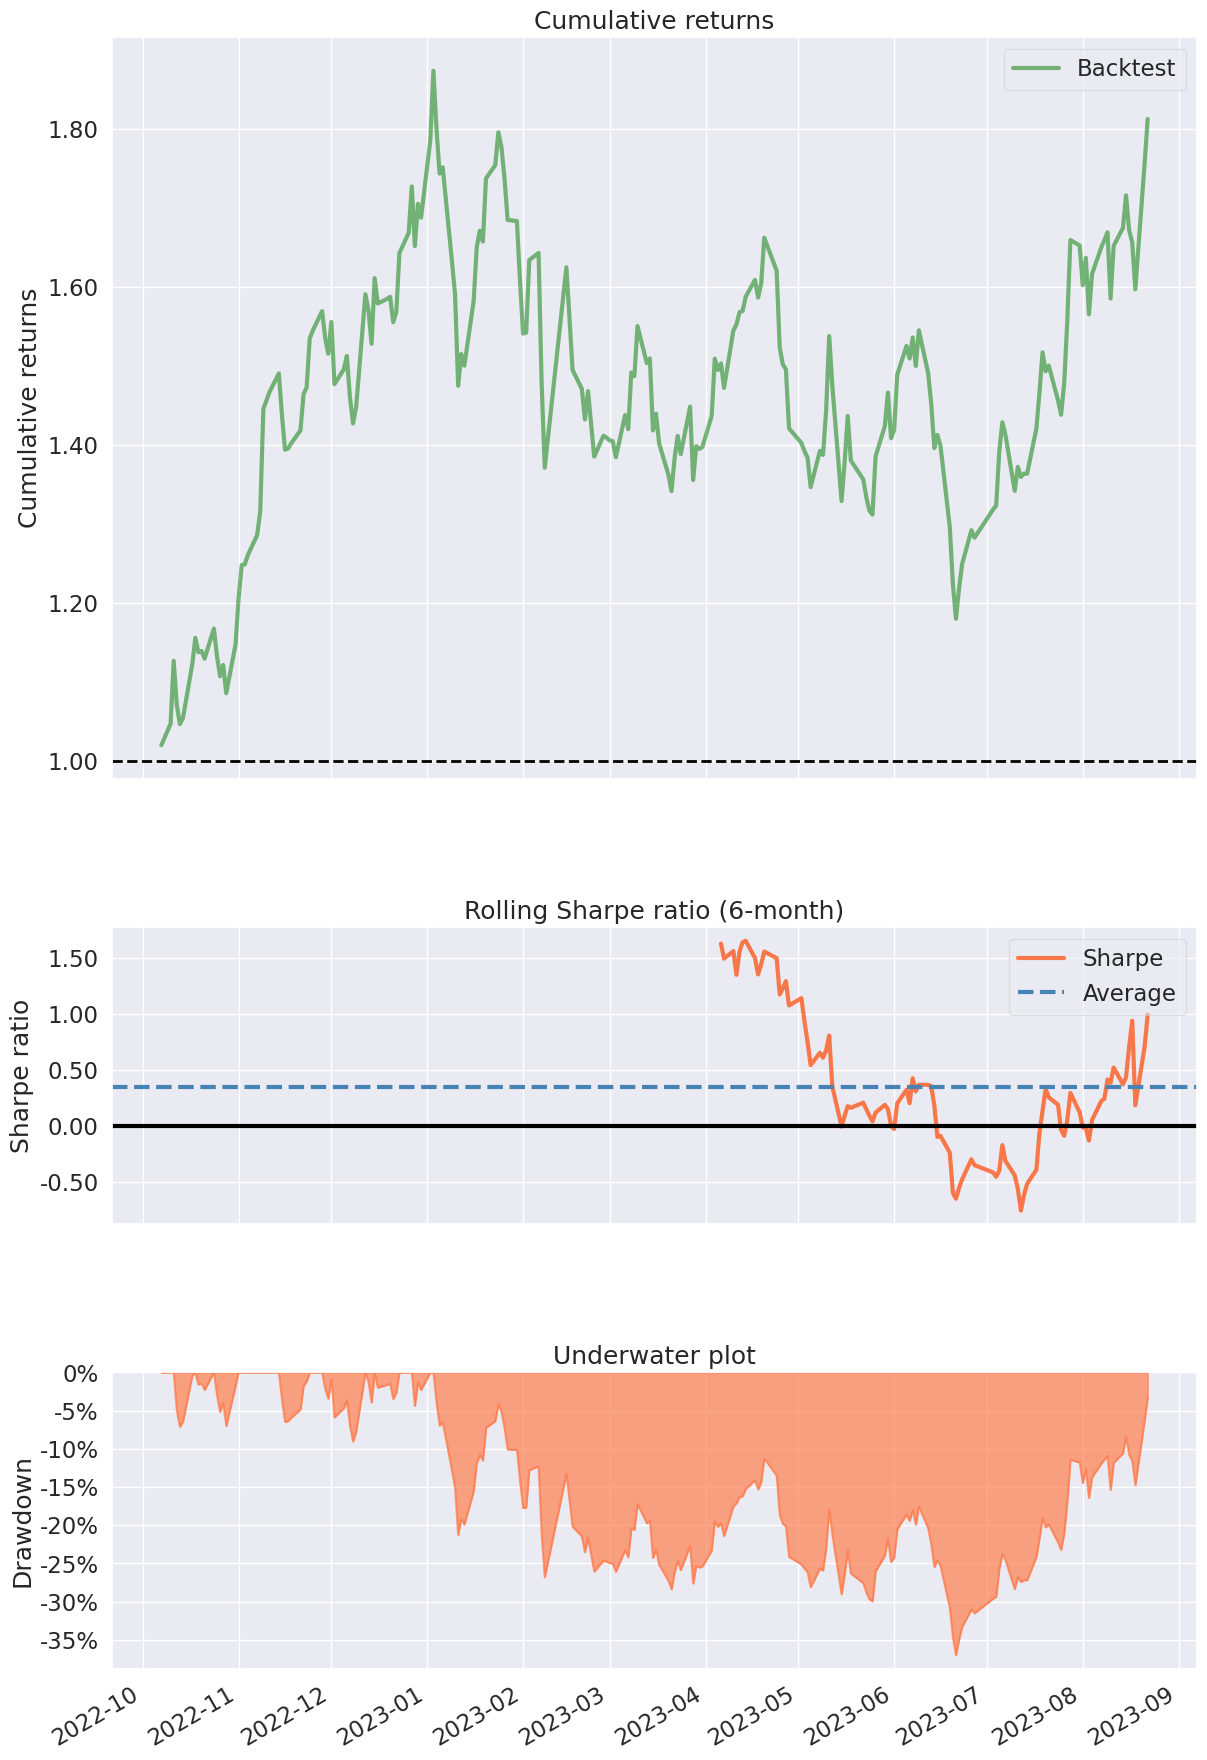

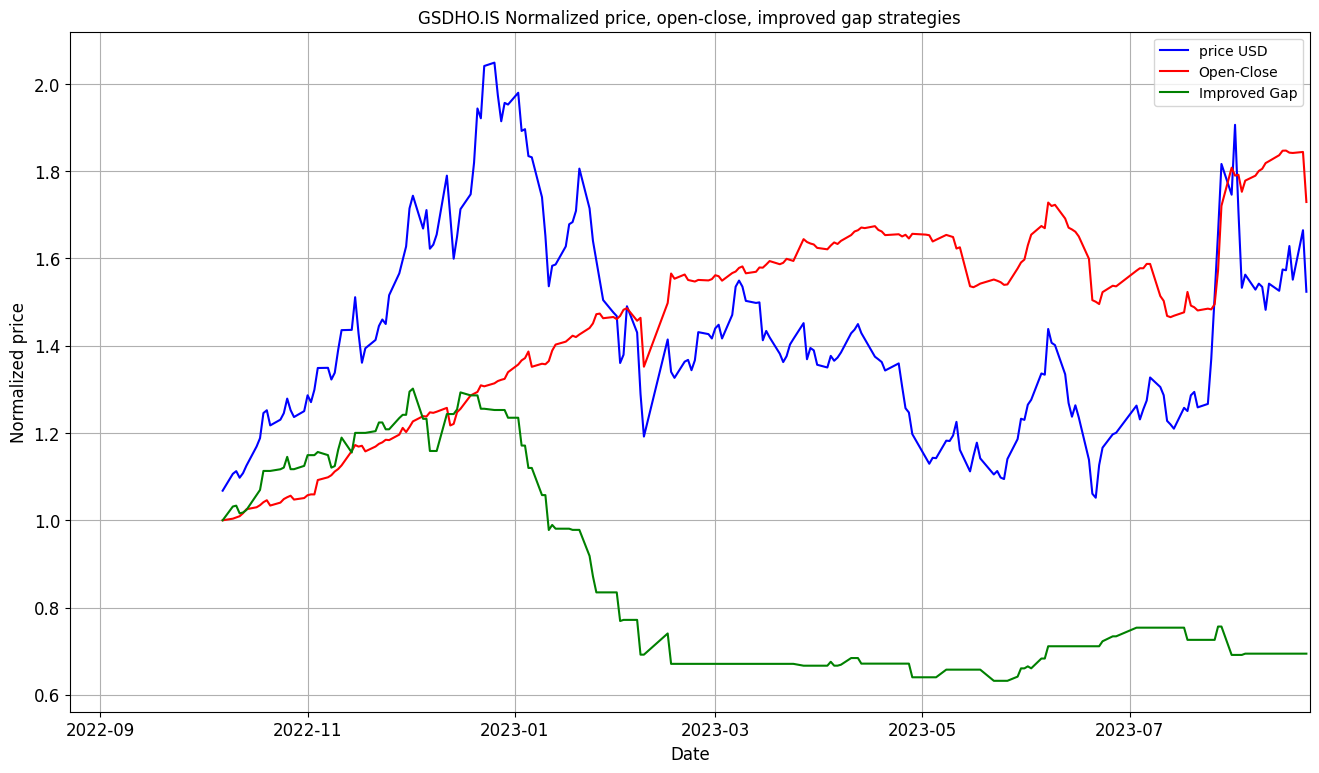


Creating Tear Sheet for GSDHO.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for ISDMR.IS : 



Updating data for ISDMR.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for ISDMR.IS

Plotting Open-Close Performance for ISDMR.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


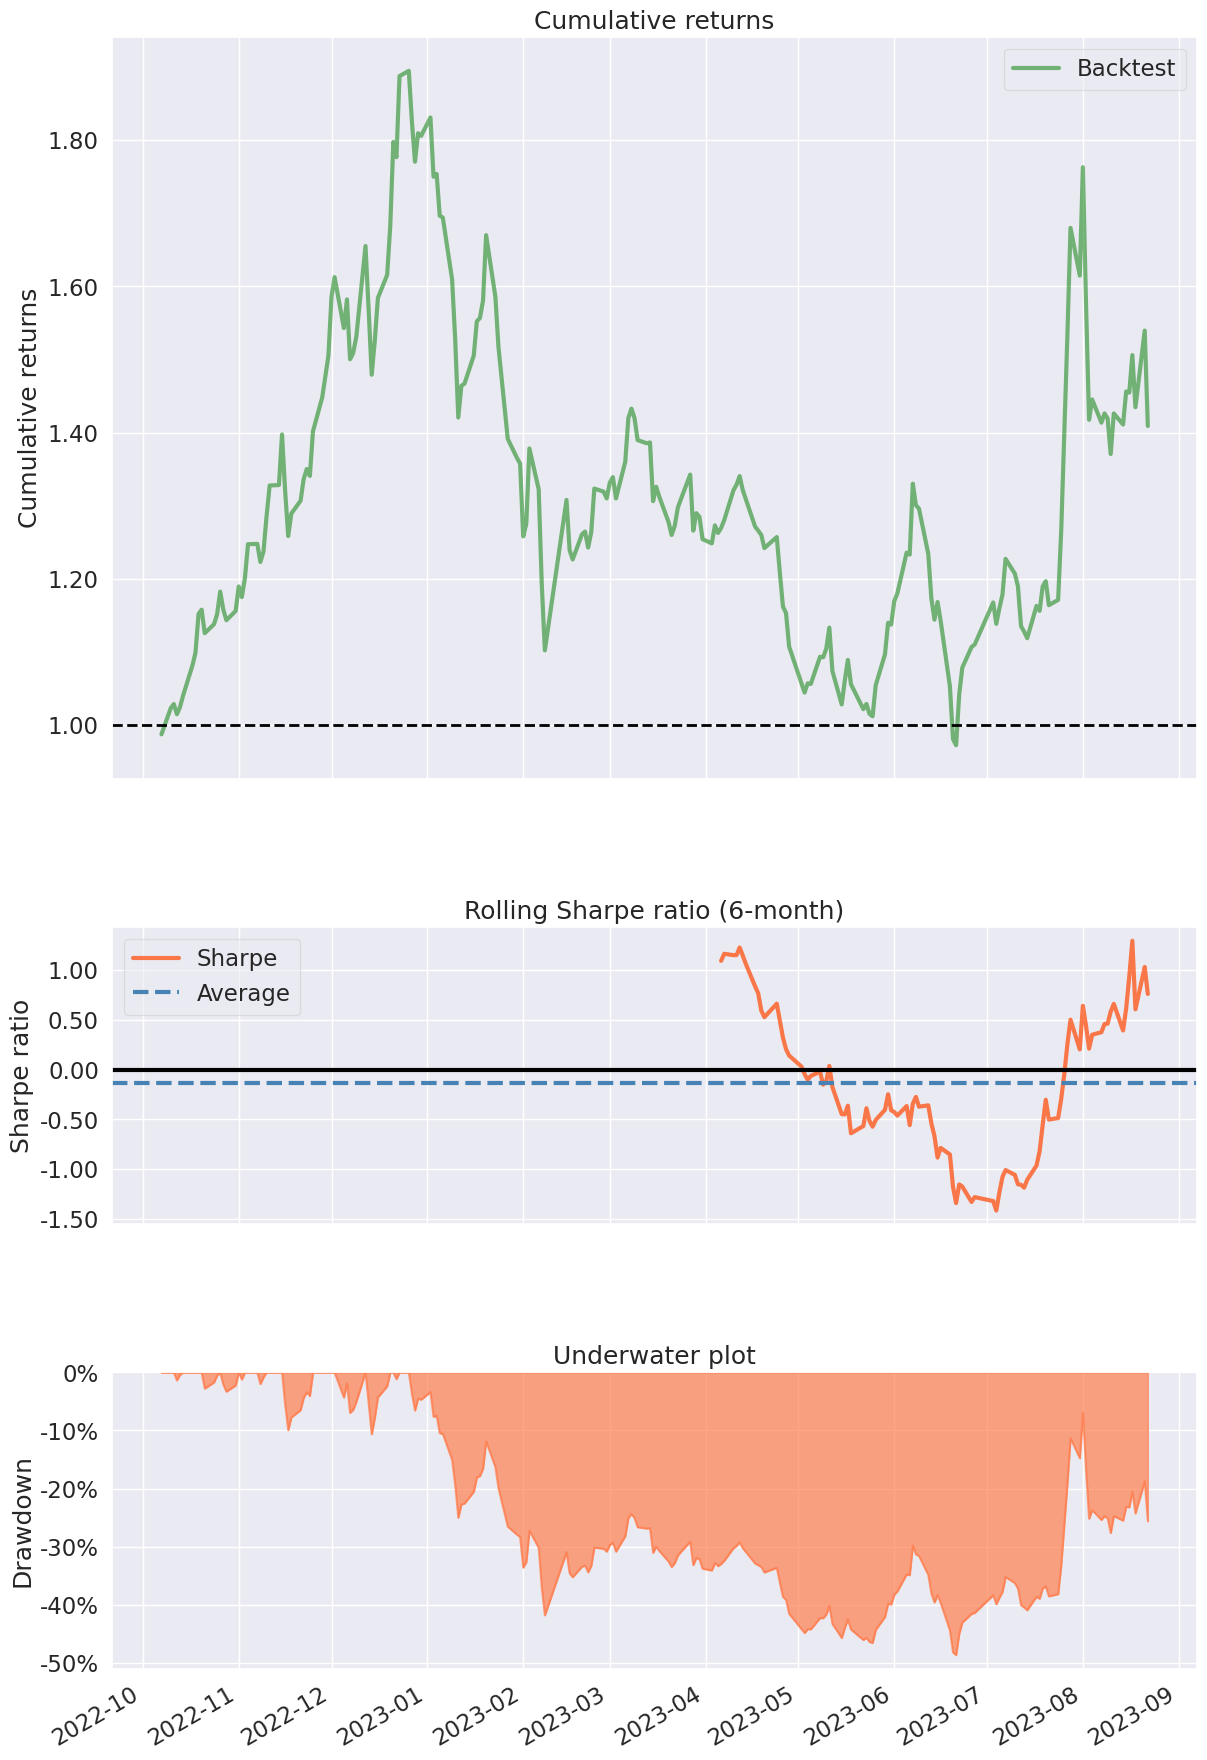

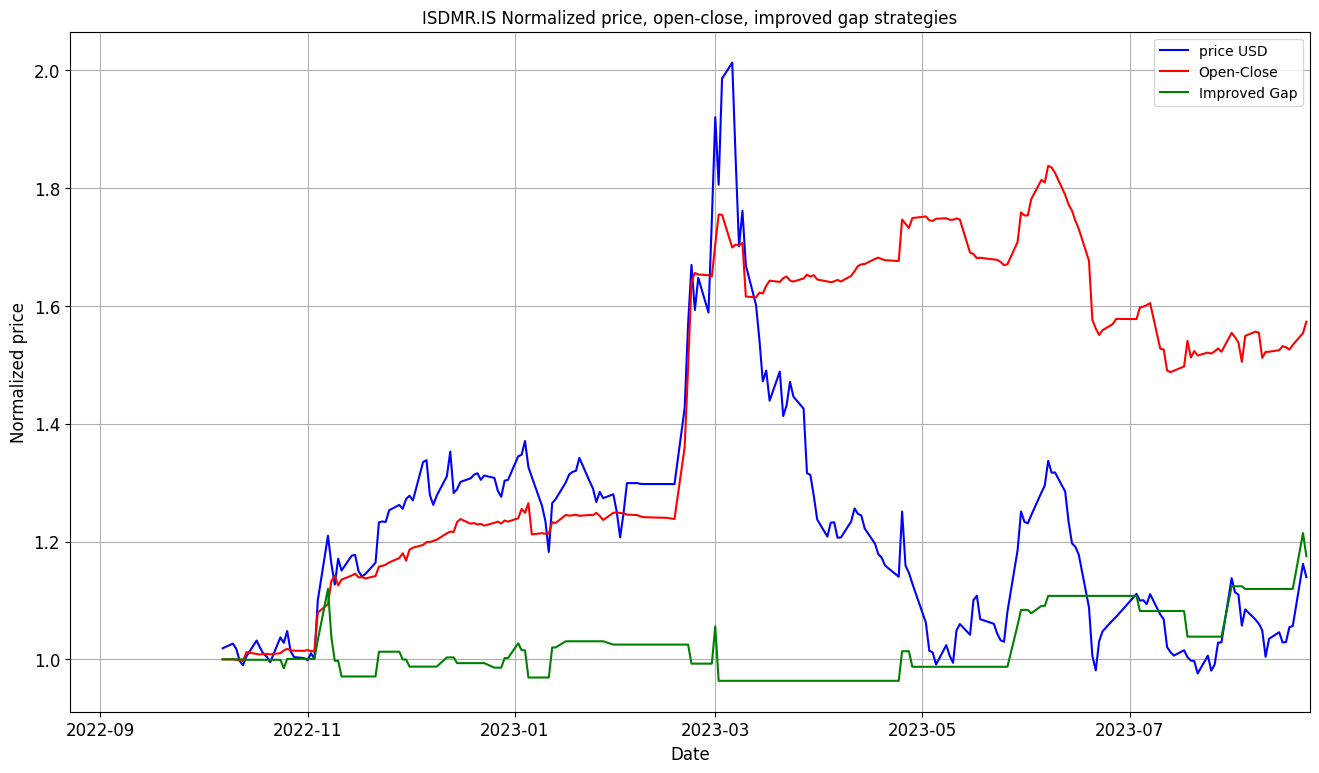


Creating Tear Sheet for ISDMR.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for GENIL.IS : 



Updating data for GENIL.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for GENIL.IS

Plotting Open-Close Performance for GENIL.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


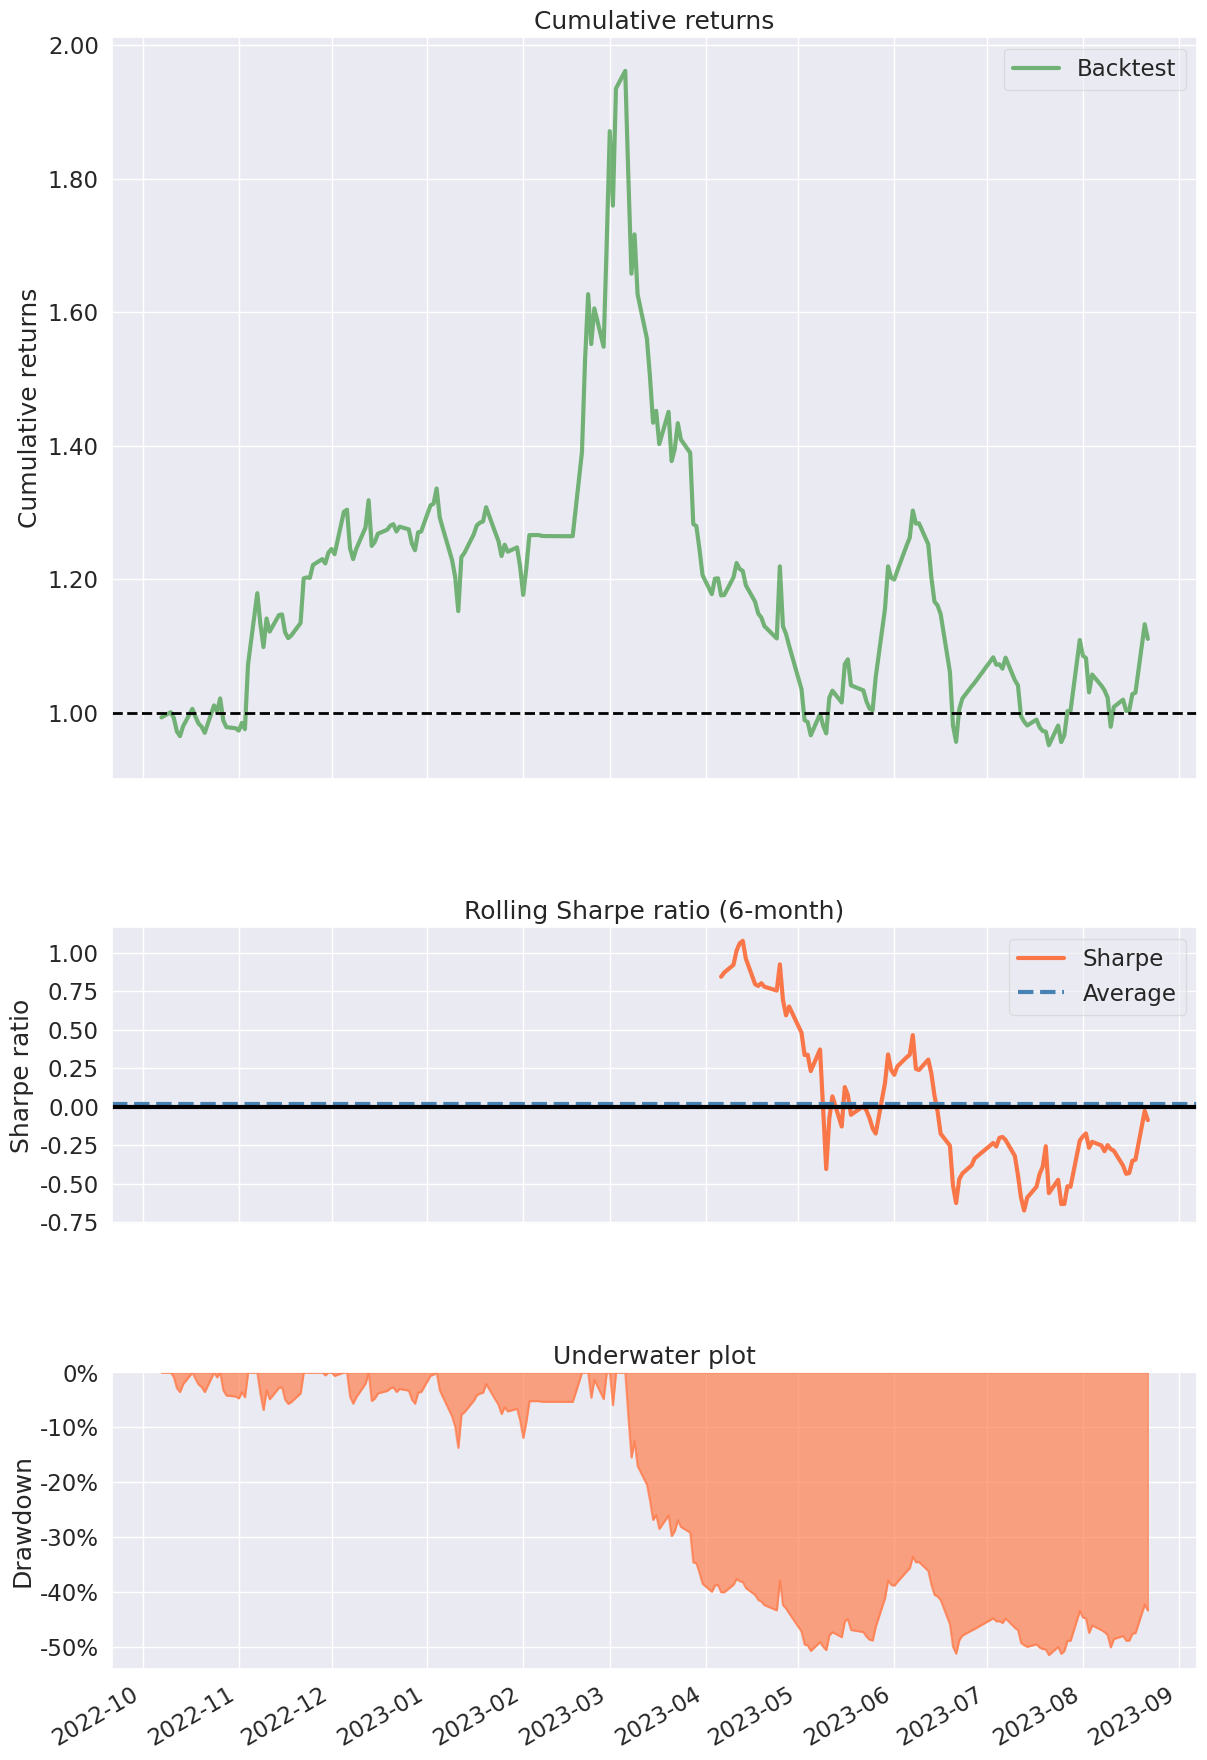

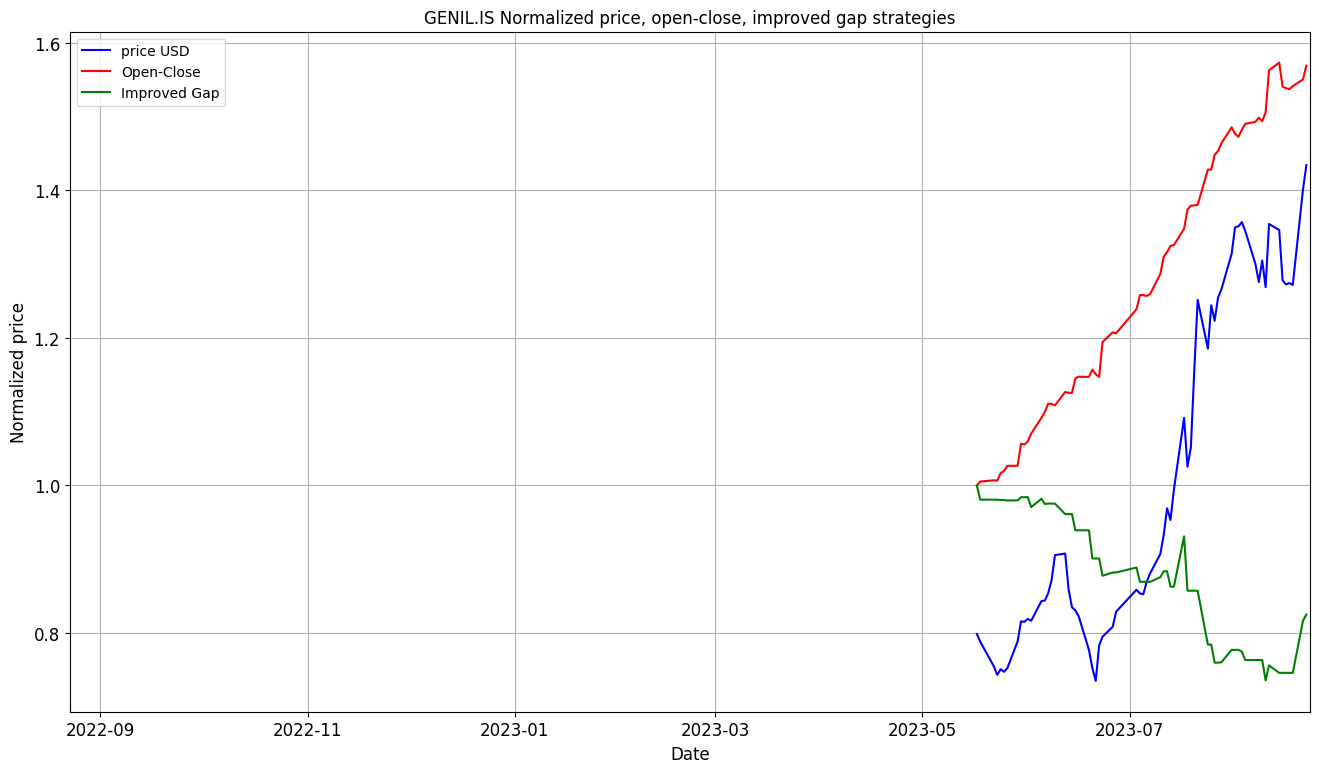


Creating Tear Sheet for GENIL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for TAVHL.IS : 



Updating data for TAVHL.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for TAVHL.IS

Plotting Open-Close Performance for TAVHL.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


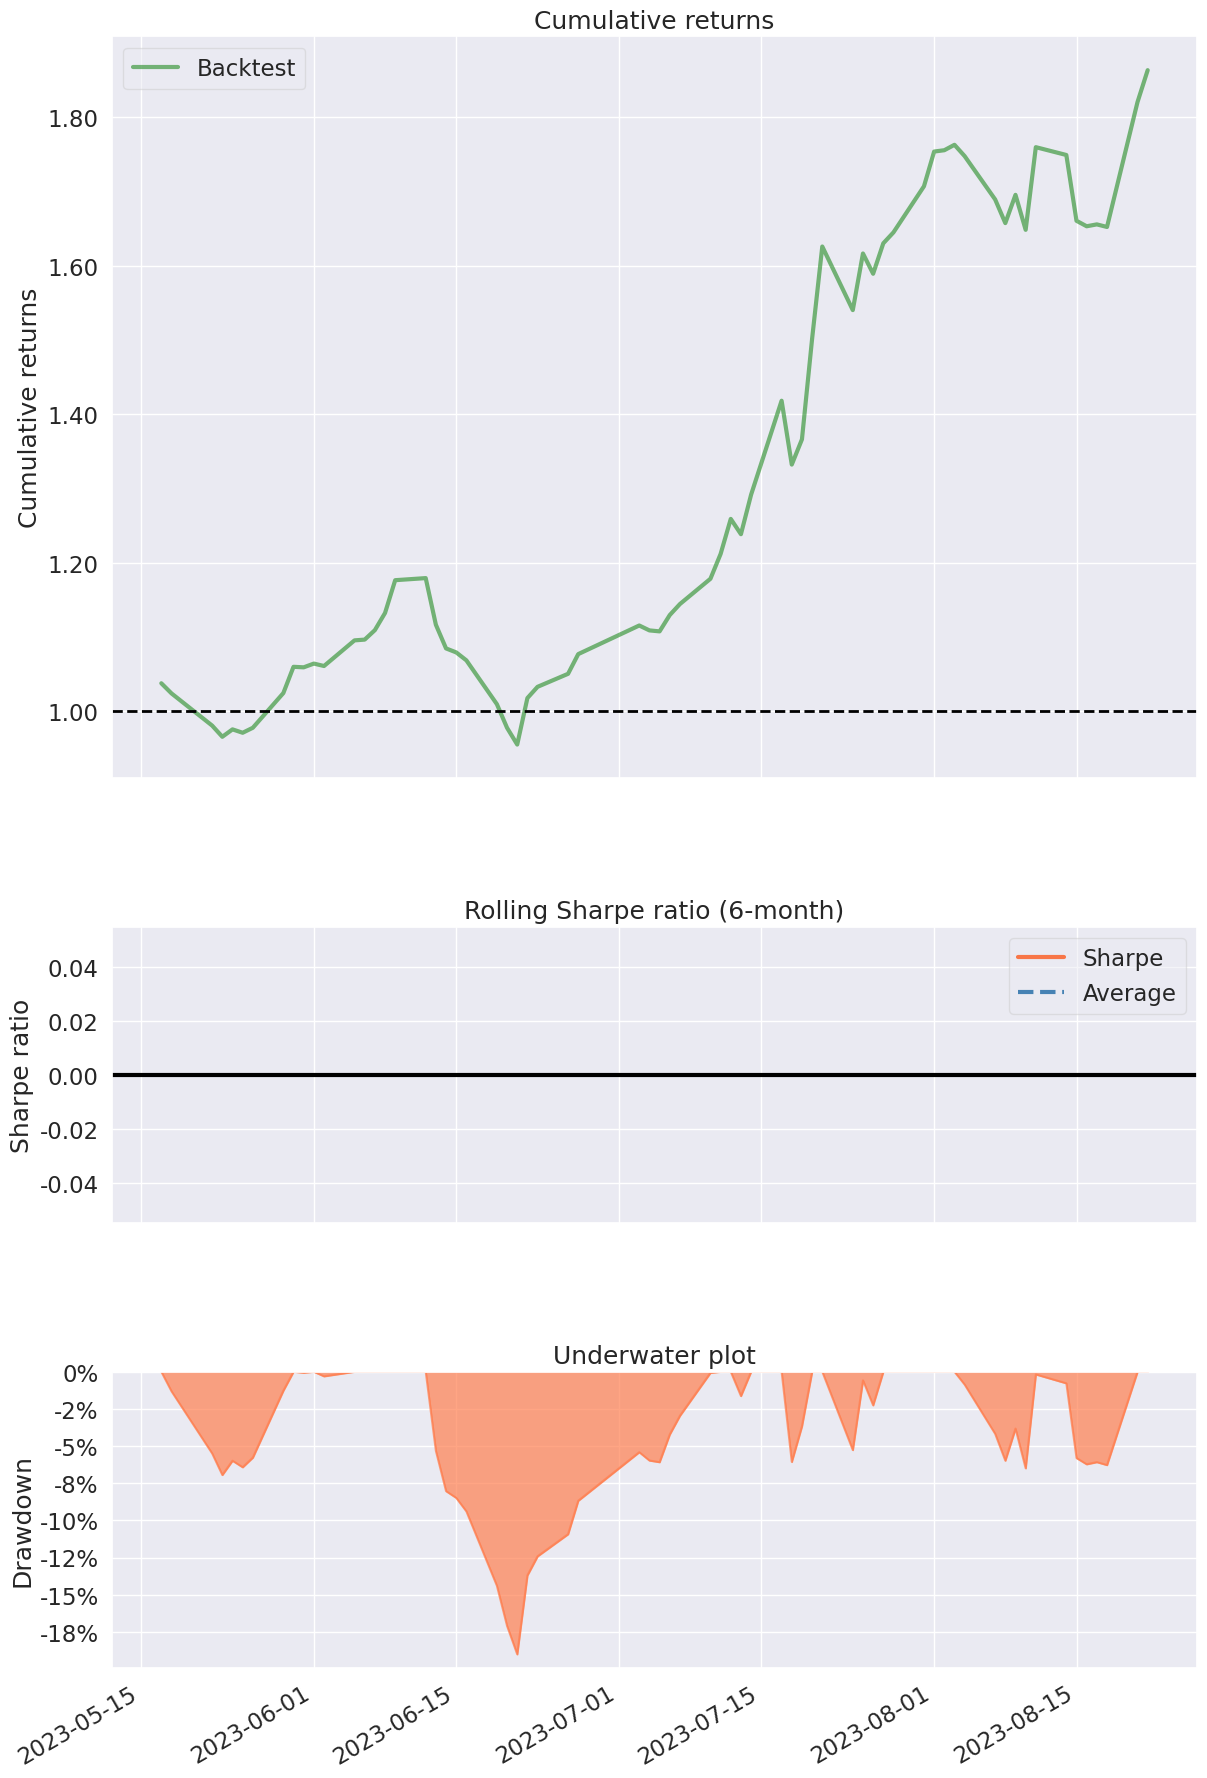

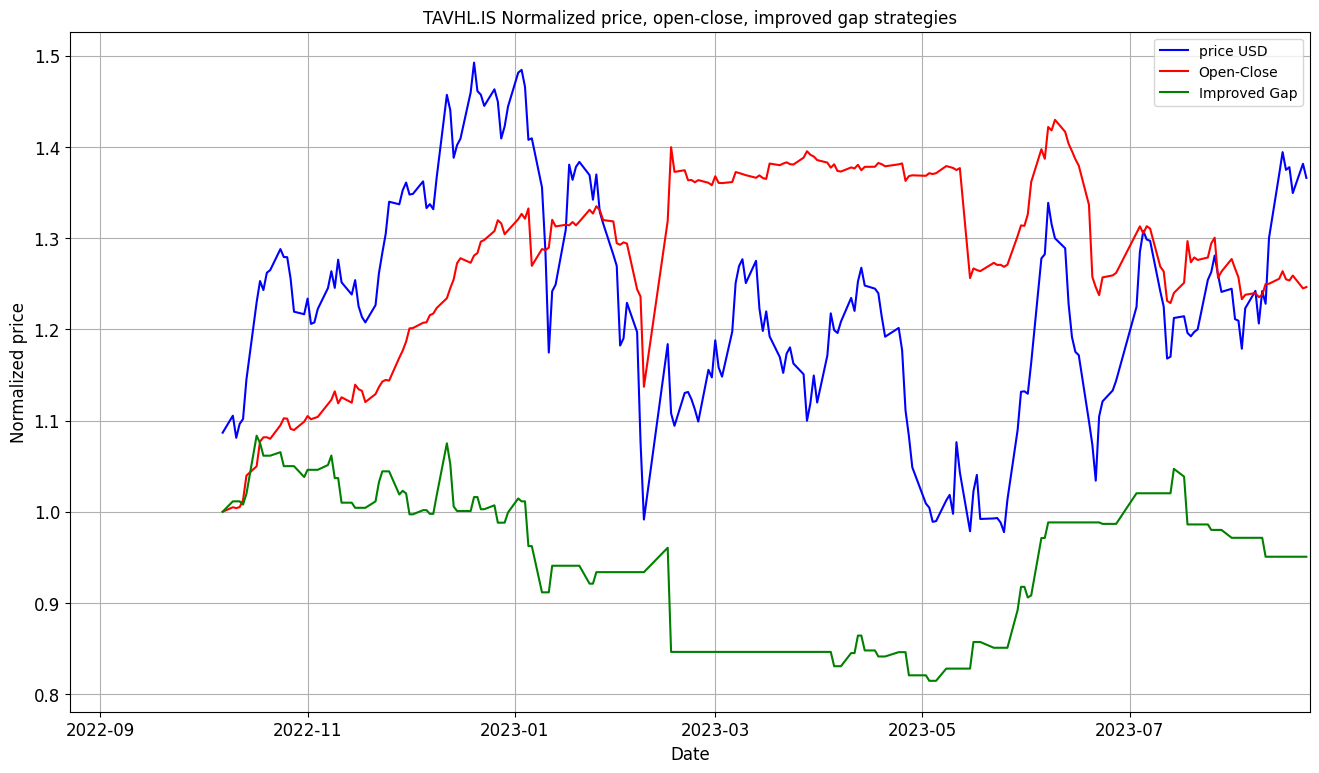


Creating Tear Sheet for TAVHL.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for VESBE.IS : 



Updating data for VESBE.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for VESBE.IS

Plotting Open-Close Performance for VESBE.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


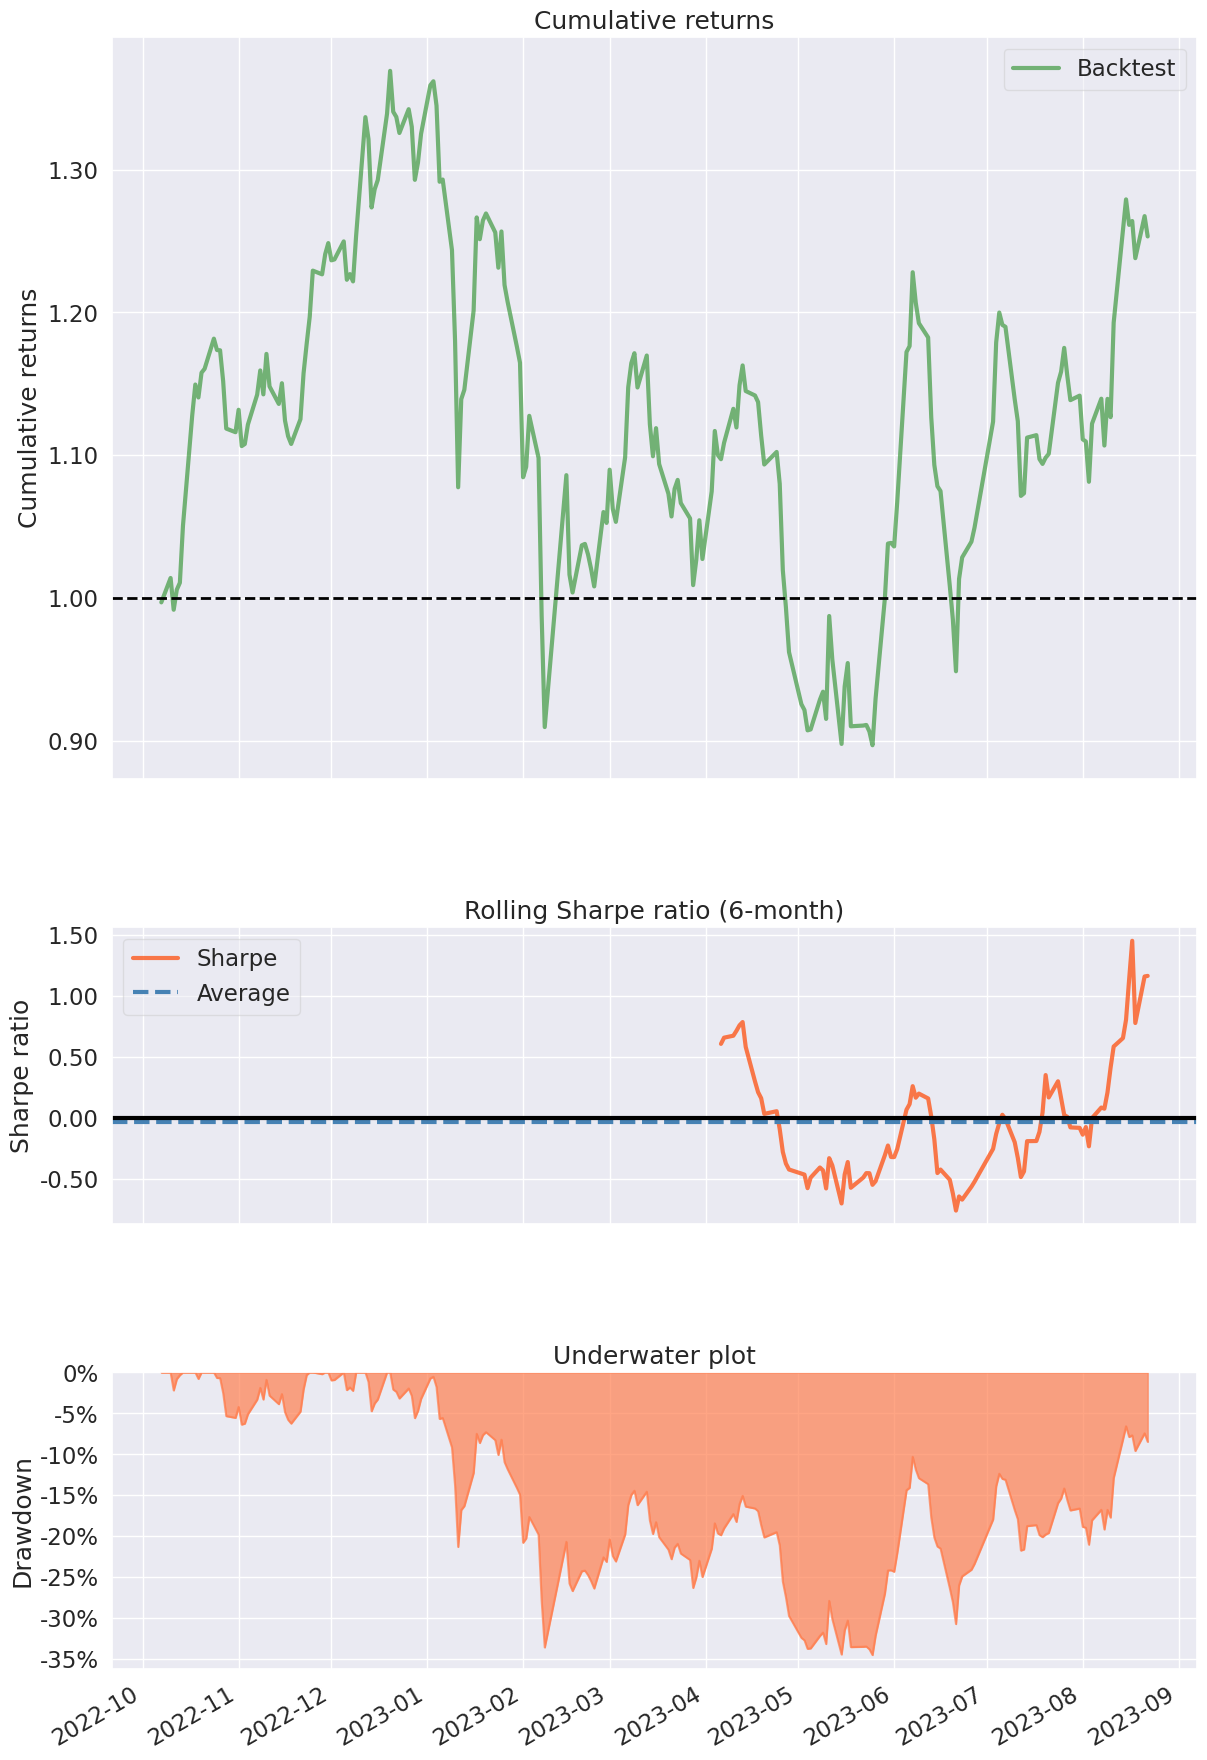

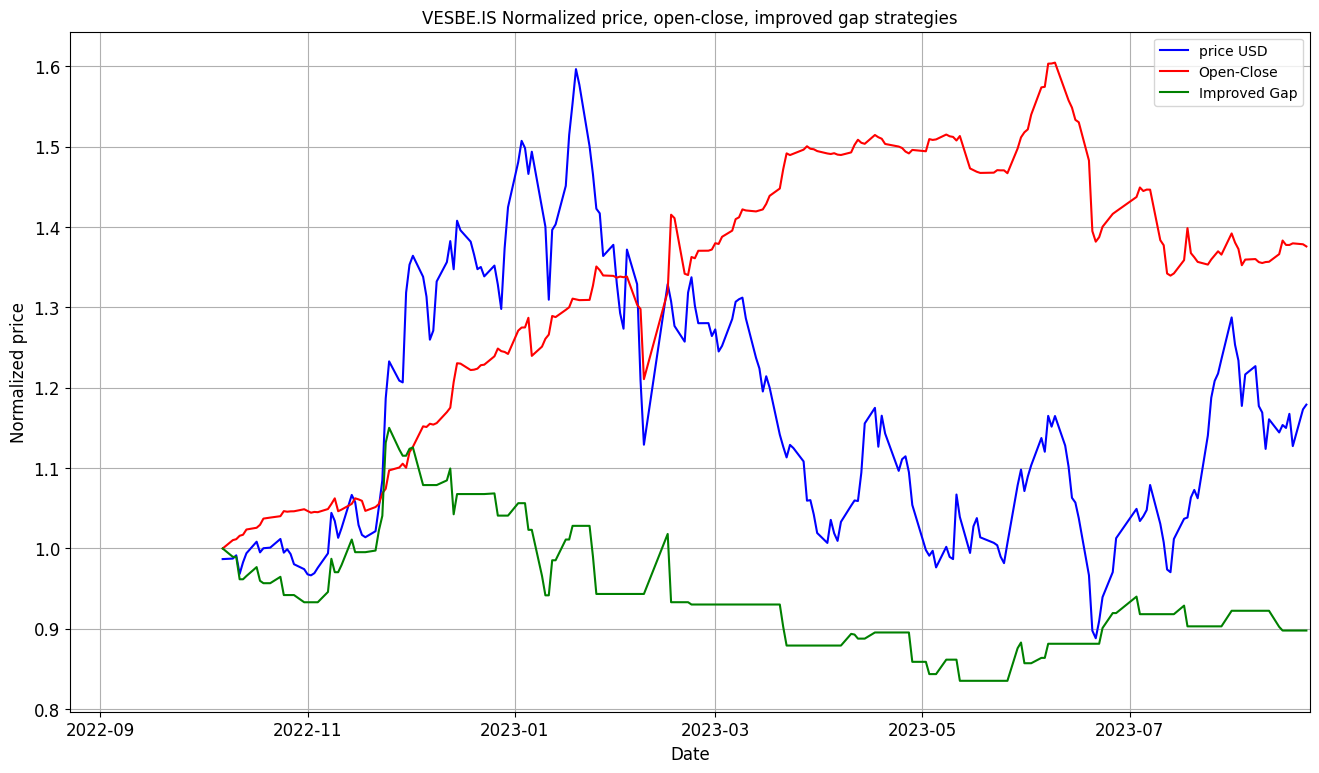


Creating Tear Sheet for VESBE.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():




Showing Ticker Stats for KORDS.IS : 



Updating data for KORDS.IS

[*********************100%%**********************]  1 of 1 completed

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for KORDS.IS

Plotting Open-Close Performance for KORDS.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


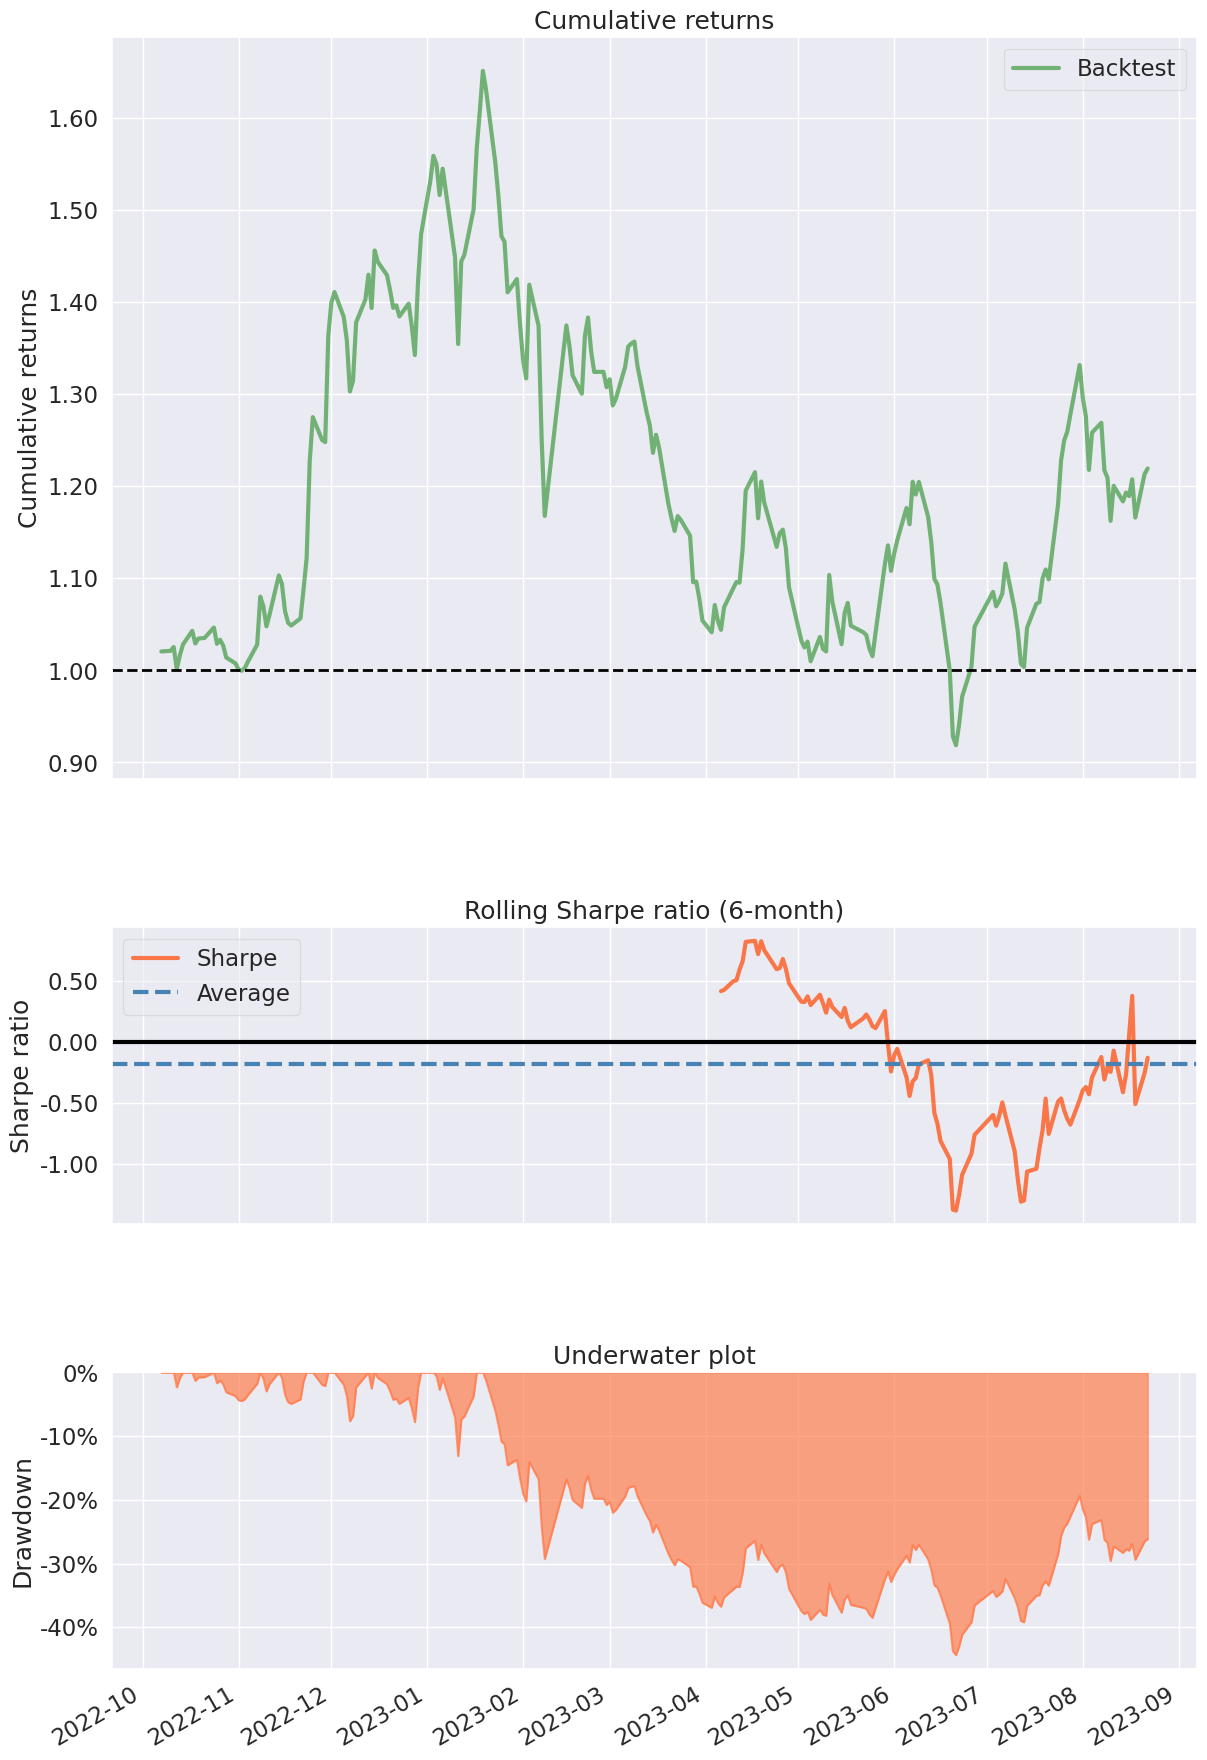

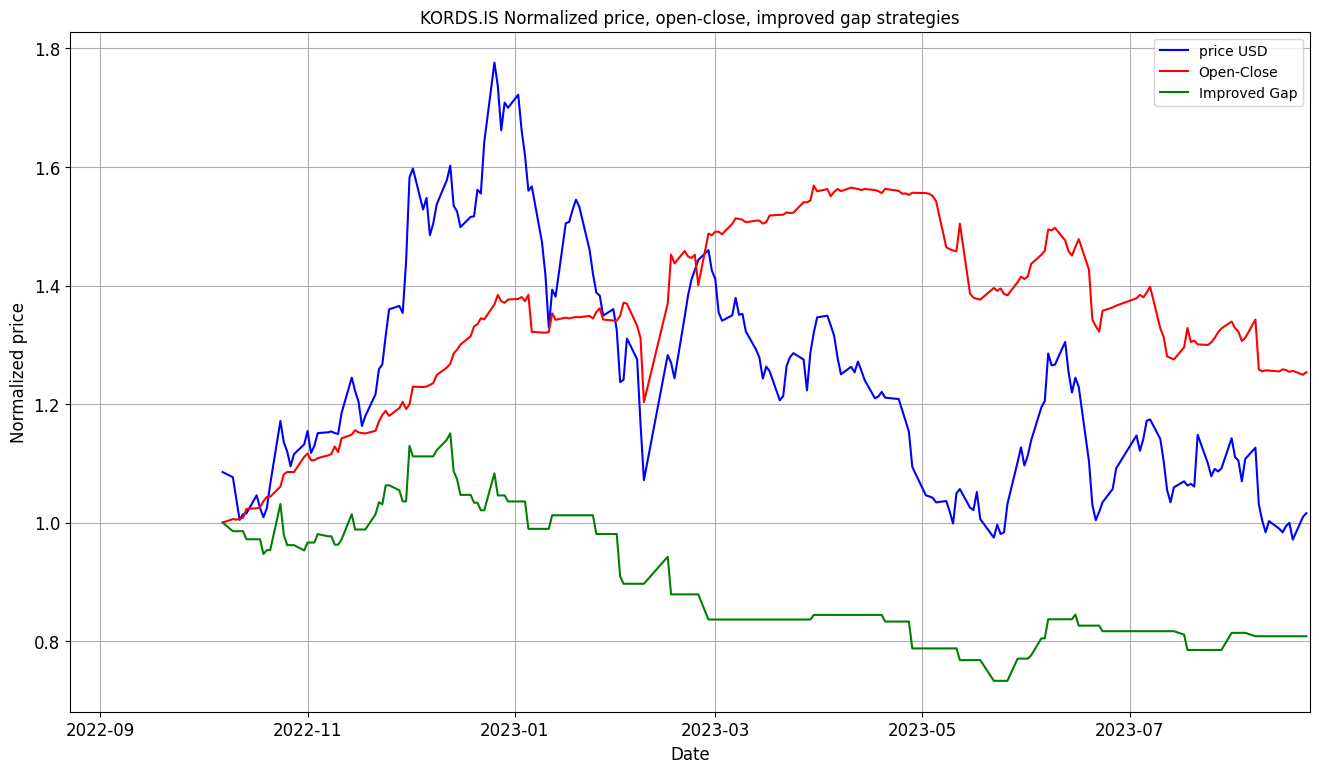


Creating Tear Sheet for KORDS.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for TKFEN.IS : 



Updating data for TKFEN.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for TKFEN.IS

Plotting Open-Close Performance for TKFEN.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


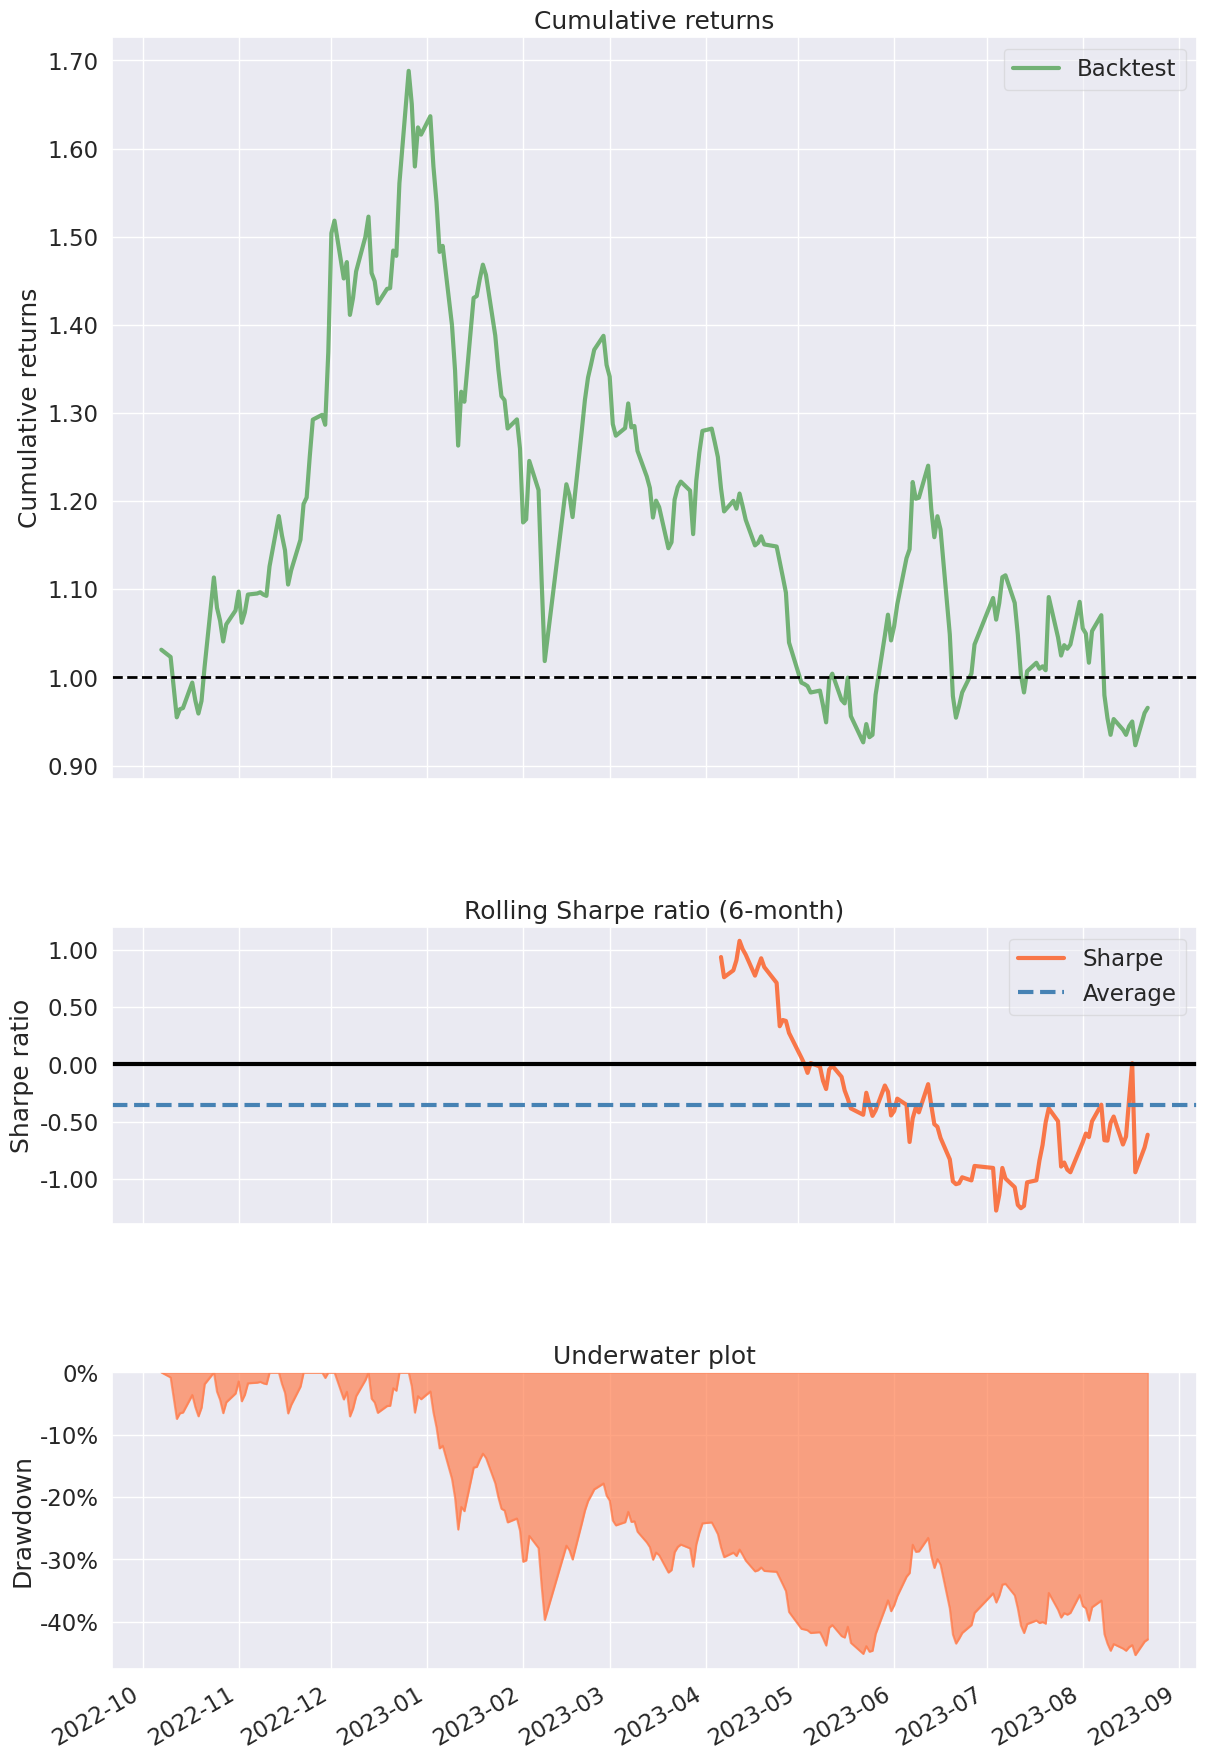

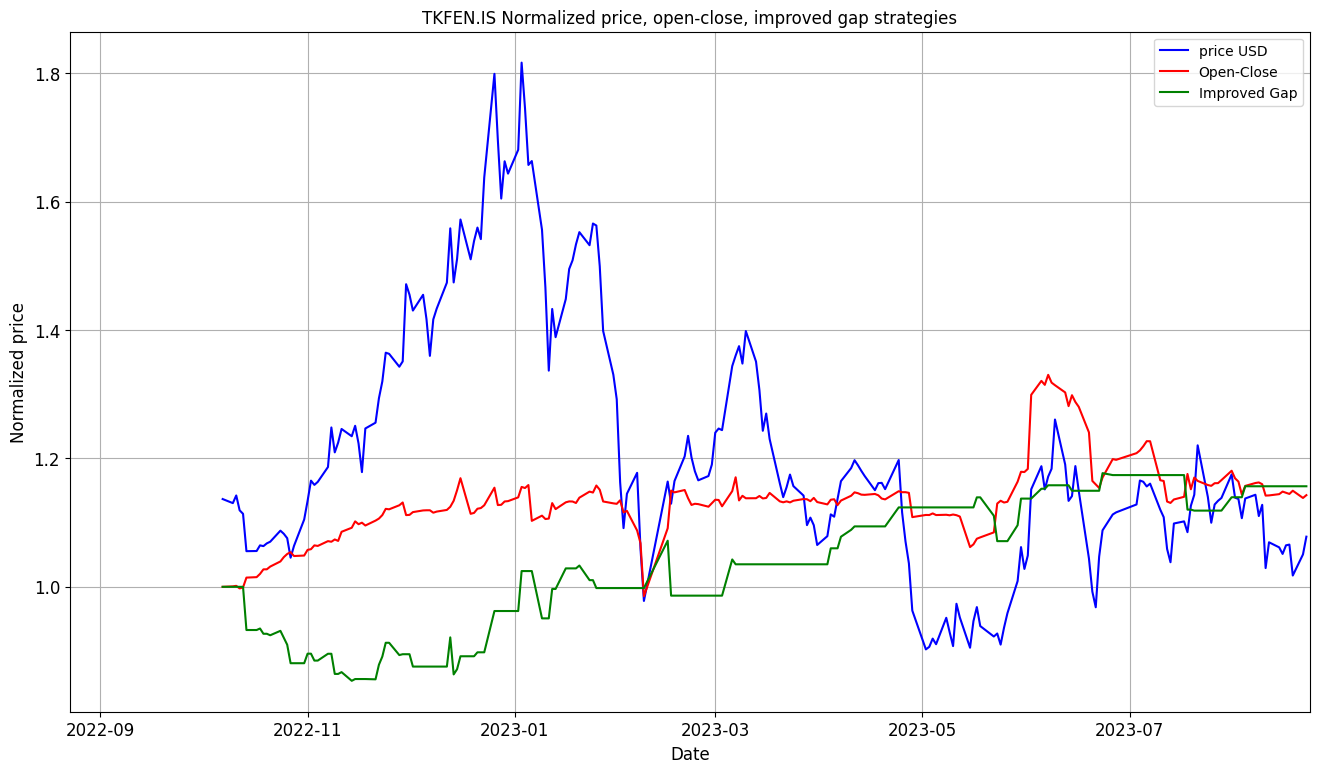


Creating Tear Sheet for TKFEN.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])




Showing Ticker Stats for SNGYO.IS : 



Updating data for SNGYO.IS

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Plotting for SNGYO.IS

Plotting Open-Close Performance for SNGYO.IS


<ipython-input-679-8c1e6da3c7a1>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 1, 1)


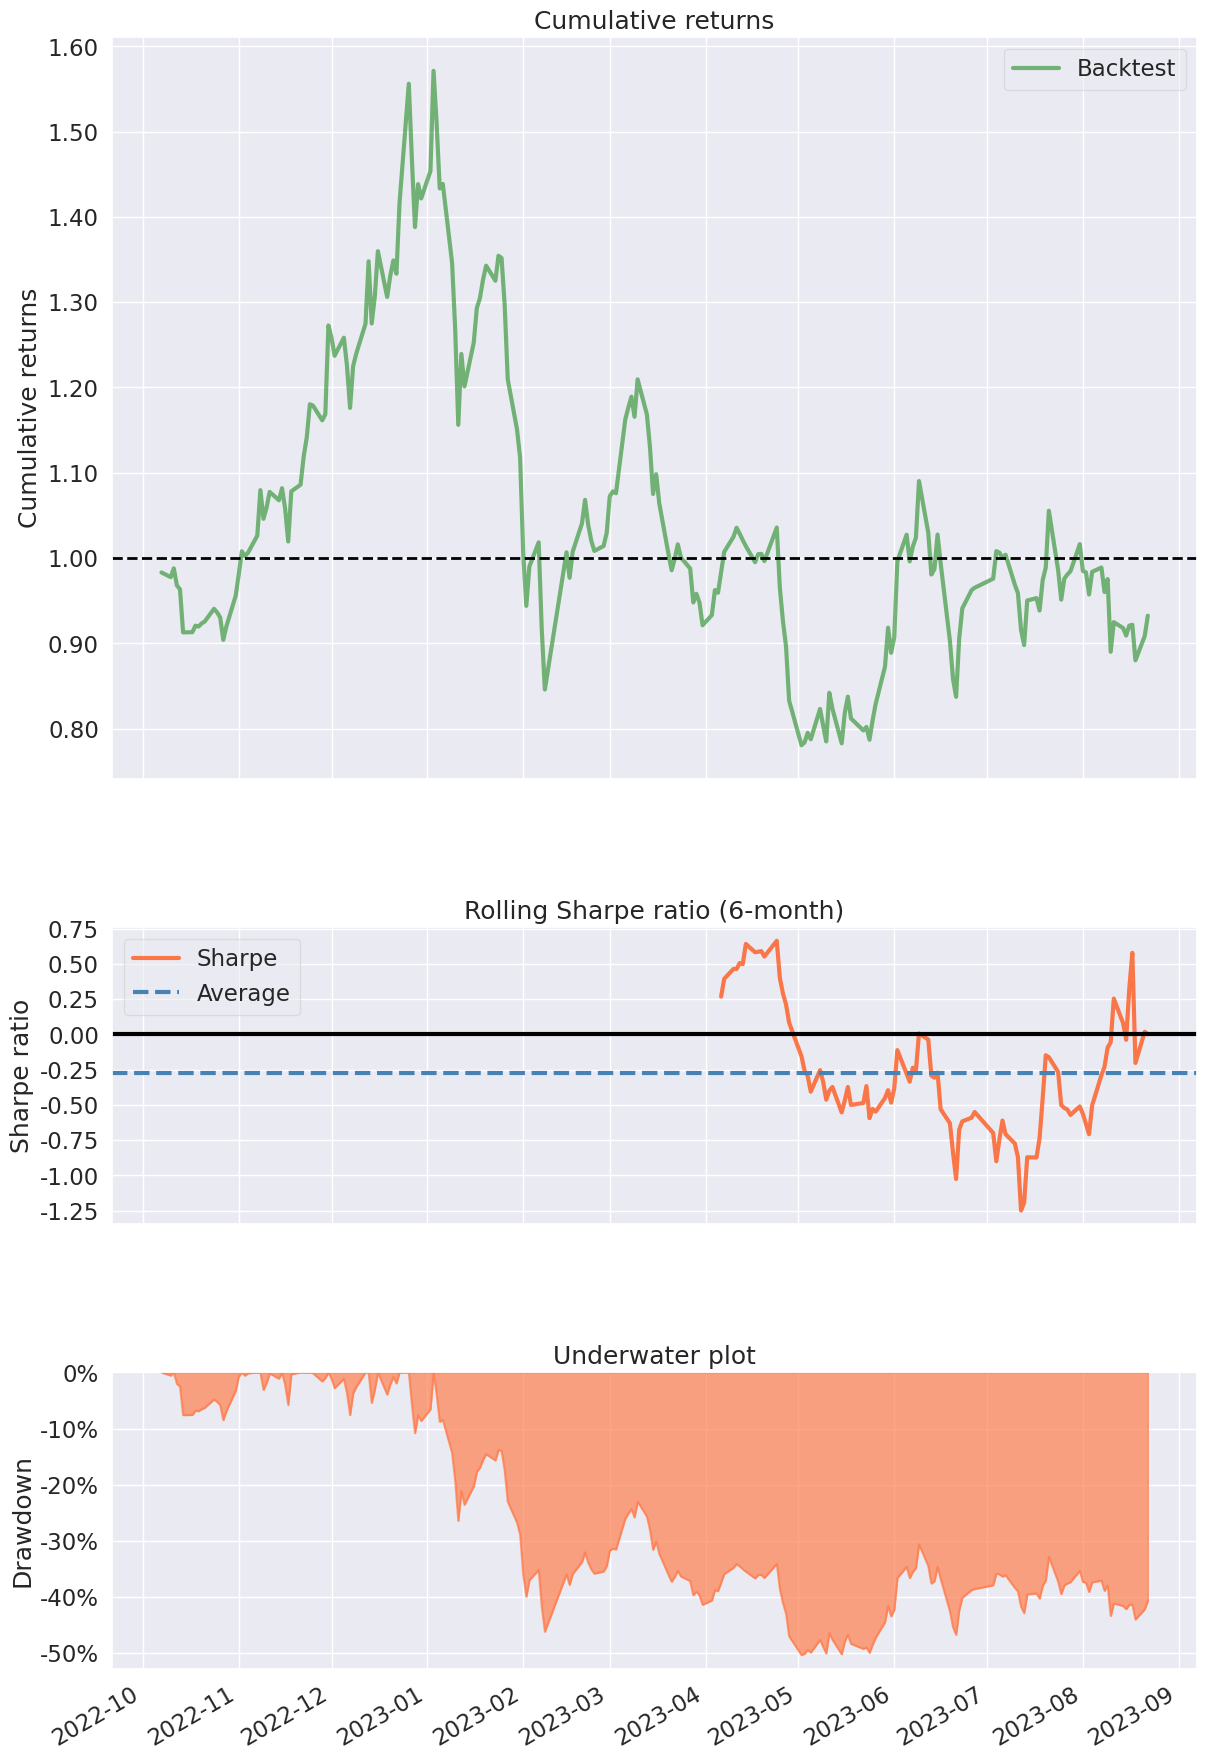

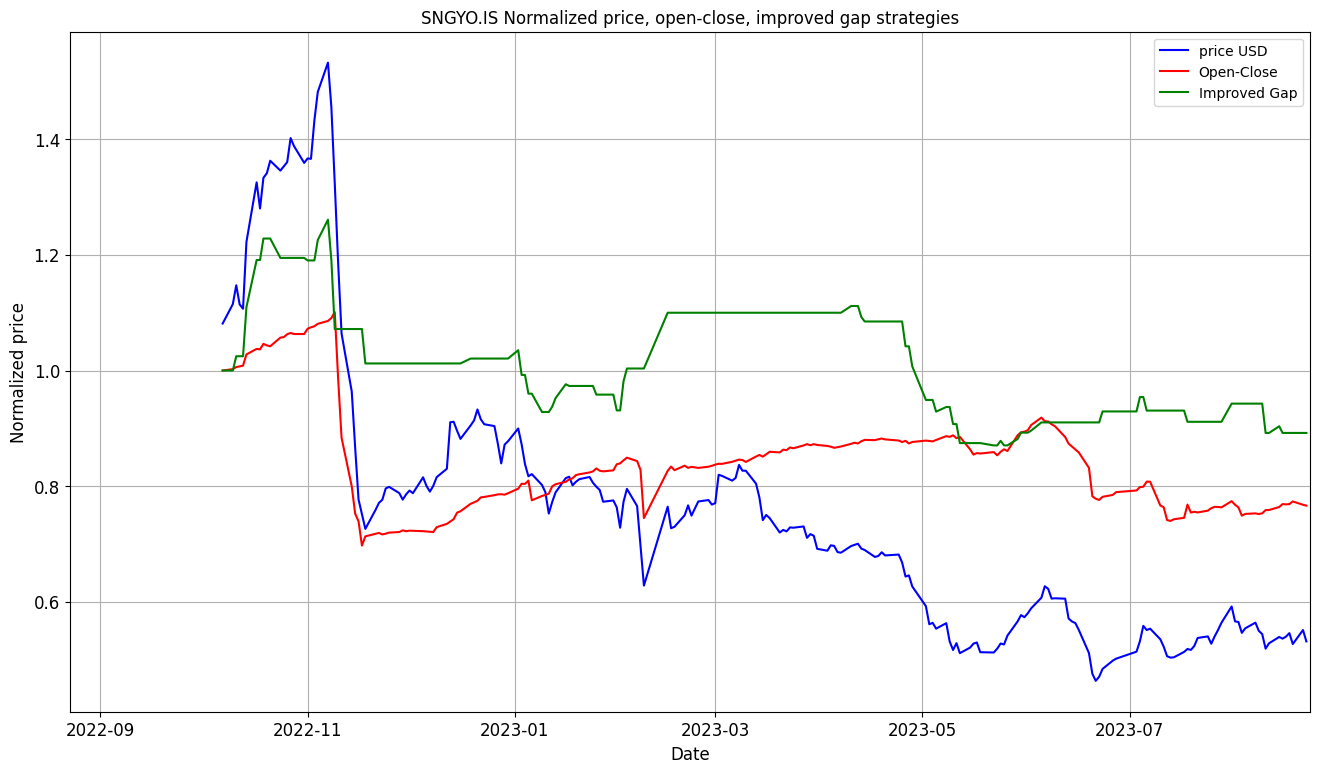


Creating Tear Sheet for SNGYO.IS


If we buy and hold performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():



If we apply open-close strategy, performance would be:



/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

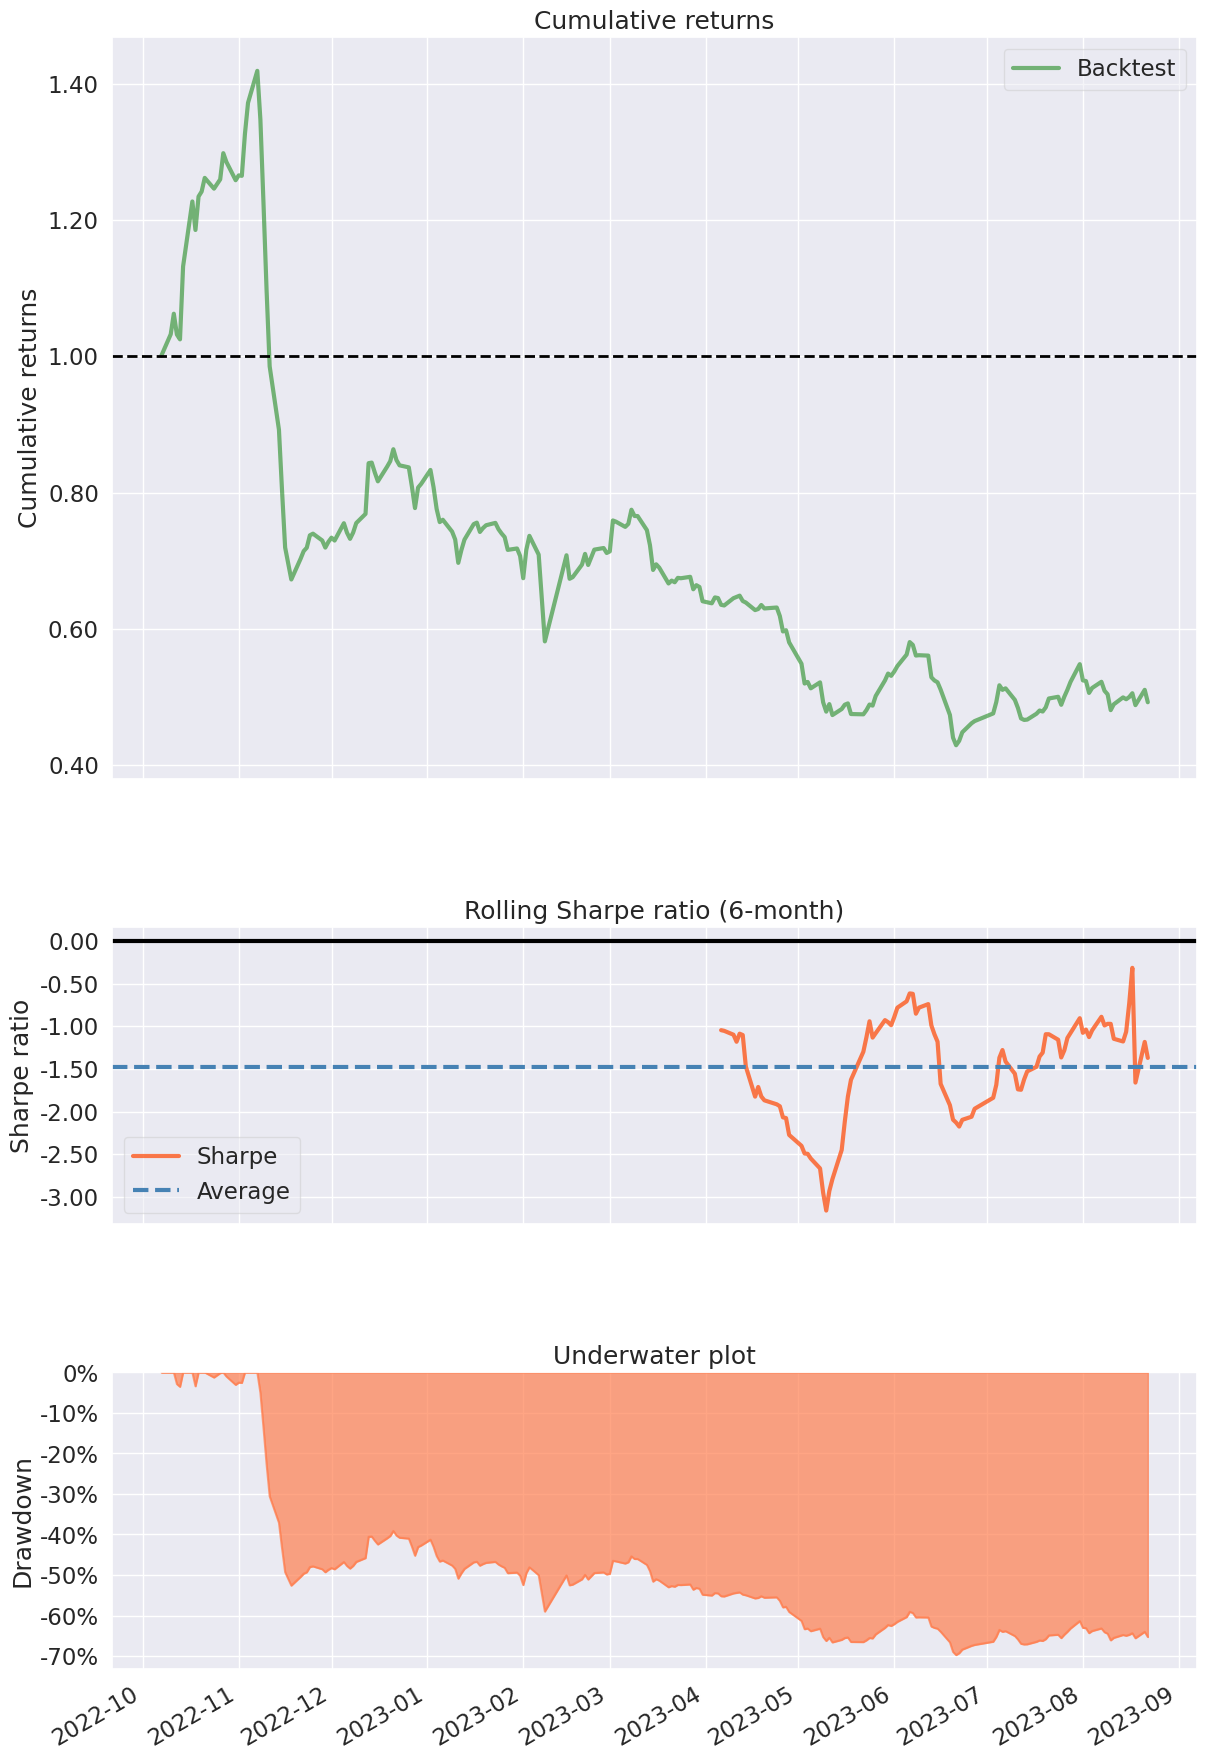

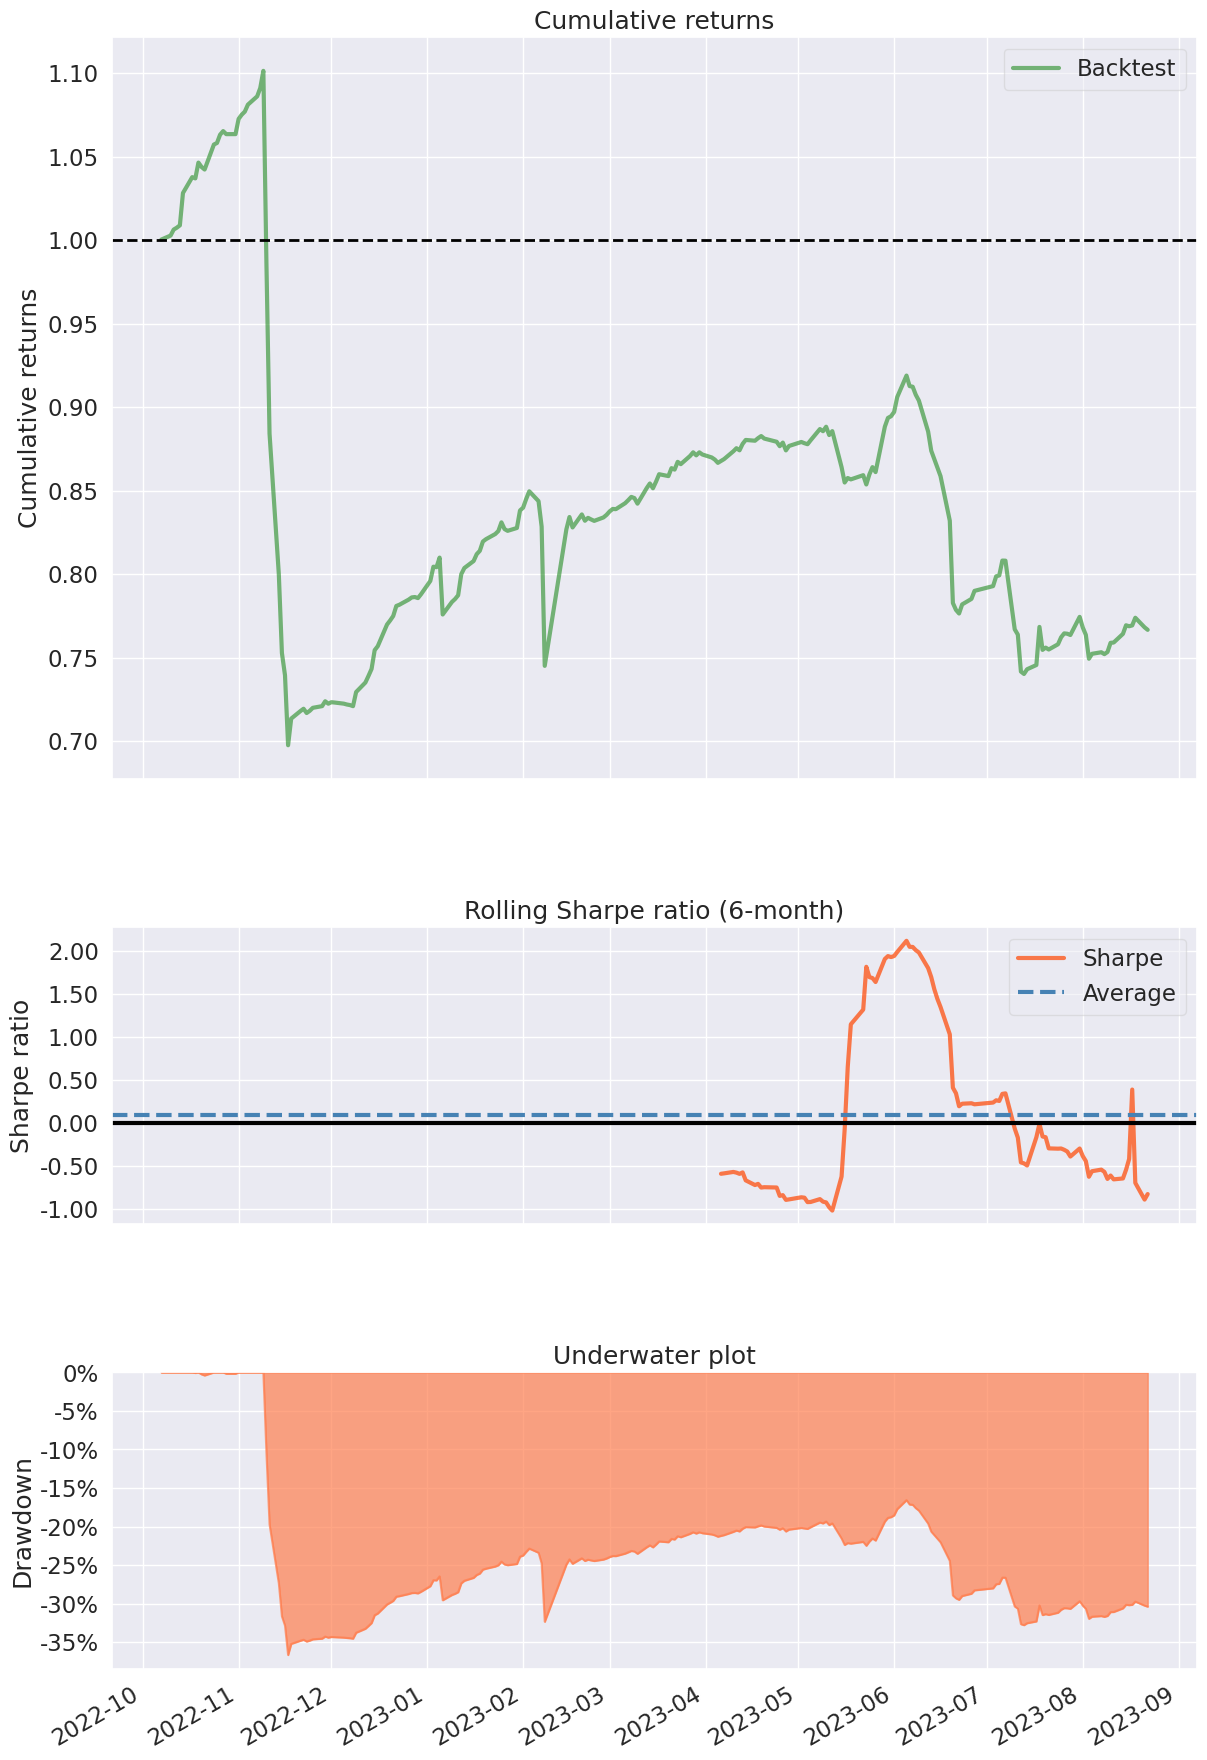

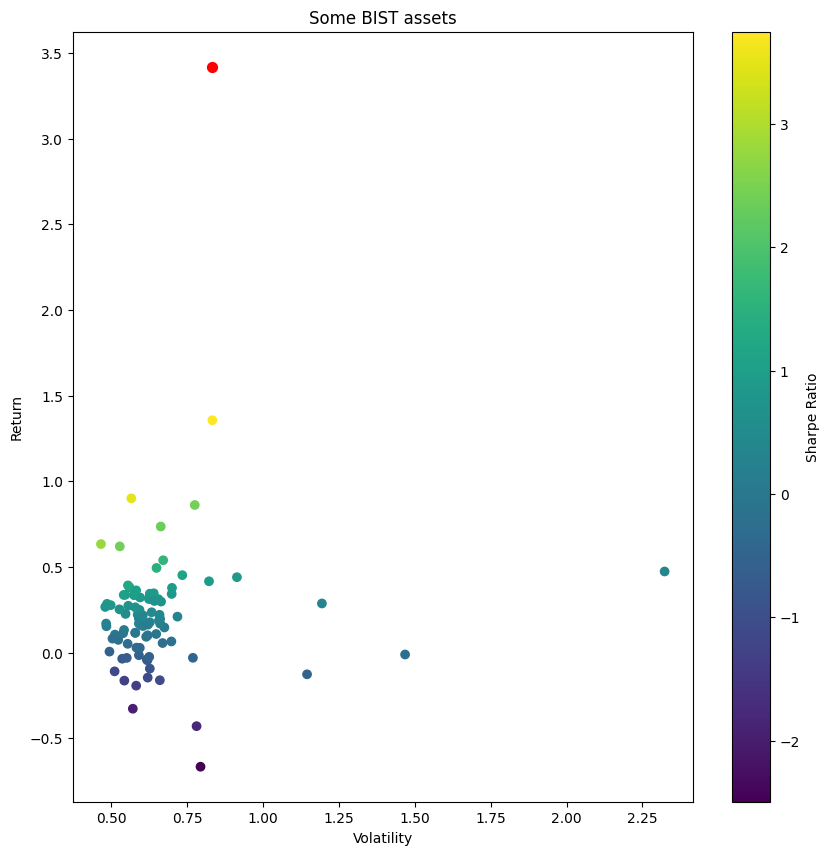

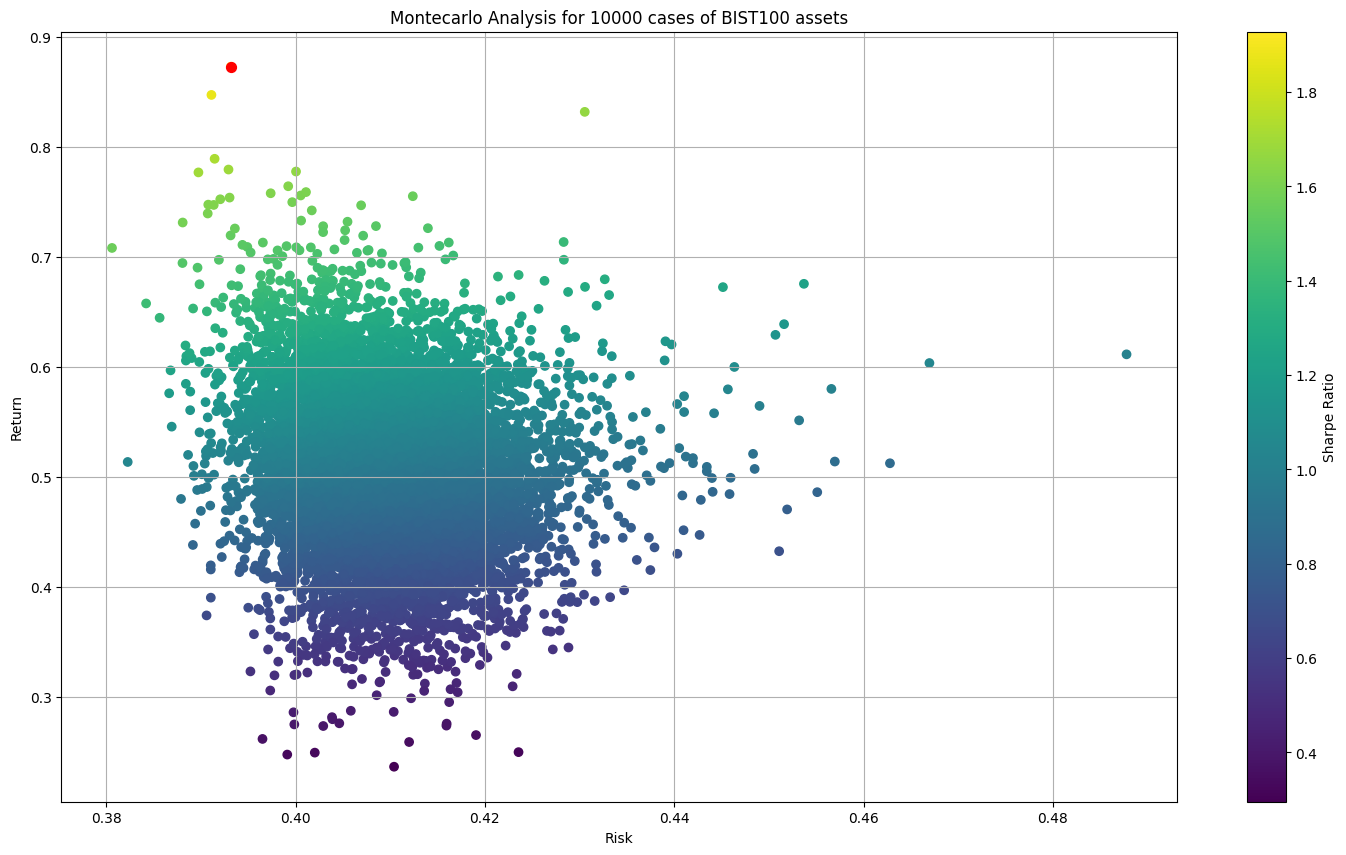

max Sharpe Ratio = 1.928096925542079
max Sharpe Ratio return = 0.8731198618715105
max Sharpe Ratio volatility = 0.39316040530882623
______________________________________________________________________

Performing STEP-4:
Plotting possible R-R of Portfolios...
Optimal_weights_For_Highest_Sharpe_Ratio = [0.00000000e+00 1.49935136e-13 4.14134123e-15 7.10202001e-14
 0.00000000e+00 0.00000000e+00 7.18538844e-14 8.86525448e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51680064e-13
 0.00000000e+00 8.04432496e-14 0.00000000e+00 5.31856572e-14
 2.89583554e-13 8.18267235e-14 0.00000000e+00 0.00000000e+00
 3.60039557e-14 1.13164338e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.33837223e-01 0.00000000e+00 1.04409798e-13
 2.71587347e-13 4.43357826e-13 0.00000000e+00 2.57351201e-13
 4.91228842e-13 2.15622224e-13 4.15860683e-13 1.83437357e-01
 0.00000000e+00 0.00000000e+00 2.92583120e-13 0.00000000e+00
 1.33072158e-13 0.000000

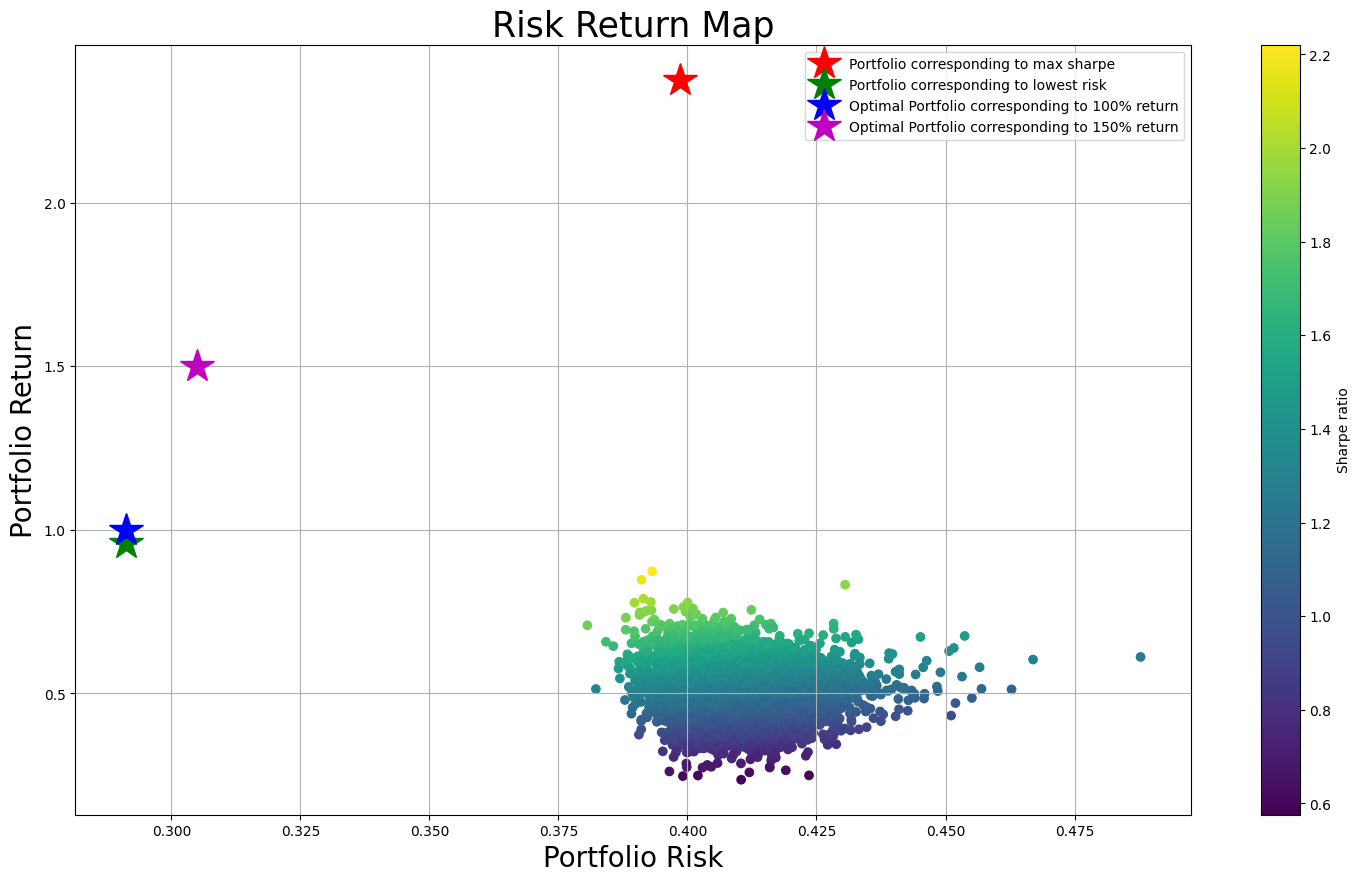

______________________________________________________________________

Performing STEP-5:
Calculating Portfolio Stats...
{'return': 2.375183108814859, 'risk': 0.3985367199234112, 'sharpe': 5.20700604253896}
______________________________________________________________________

Performing STEP-6:
Distribute Amounts in TL...
% weights of BEST PF


NameError: ignored

In [704]:
def main():

  target_return = 0

  bist30_df, bist30_df_long, bist30_log_returns = ShowTRMarket(BIST30, target_return)

  print(f"bist30_log_returns = {bist30_log_returns}")
  print(f"bist30_log_returns.columns = {bist30_log_returns.columns}")
  print(f"bist30_df.Ticker= {bist30_df.Ticker}")
  print(f"bist30_log_returns.columns.isin(bist30_df.Ticker)={bist30_log_returns.columns.isin(bist30_df.Ticker)}")

  bist30_df.to_csv('bist30_selected.csv')

  for ticker in bist30_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"BIST")

  bist100_df, bist100_df_long, bist100_log_returns = ShowTRMarket(BIST100, target_return)
  for ticker in bist100_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"BIST")

  bist100_df.to_csv('bist100_selected.csv')

  dow_df, dow_df_long = ShowUSMarket(DOW30, target_return)
  for ticker in dow_df['Ticker']:
    print("\n====================================================")
    print(f"\nShowing Ticker Stats for {ticker} : ")
    print("\n====================================================")
    ShowTickerStats( ticker,"DOW30")

  # sp500_df, sp500_df_long = ShowUSMarket(sp500_constituents.Symbol, target_return)
  # for ticker in sp500_df['Ticker']:
  #   print("\n====================================================")
  #   print(f"\nShowing Ticker Stats for {ticker} : ")
  #   print("\n====================================================")
  #   ShowTickerStats( ticker,"SP500")

  #EmpyrialPortfolioPerformance()

  print(f"\nHere is our most probable winner list (for TR = {target_return}) :")
  print("\n====================================================")

  pd.set_option('display.max_columns', None)

  bist30_df = bist30_df.reset_index(drop=True)
  bist30_df_long = bist30_df_long.reset_index(drop=True)

  bist100_df = bist100_df.reset_index(drop=True)
  bist100_df_long = bist100_df_long.reset_index(drop=True)

  dow_df = dow_df.reset_index(drop=True)
  dow_df_long = dow_df_long.reset_index(drop=True)

  # sp500_df = sp500_df.reset_index(drop=True)
  # sp500_df_long = sp500_df_long.reset_index(drop=True)

  print(bist30_df)
  print(bist100_df)
  print(dow_df)
  # print(sp500_df)

  # from google.colab import data_table
  # print(data_table.DataTable(bist_df, include_index=False, num_rows_per_page=10))

  cnt_PWin = len(bist30_df[(bist30_df['PWin'] > WINNER_LIMIT_TR)])
  cnt_PWin_OC = len(bist30_df[(bist30_df['PWin_OC'] > WINNER_LIMIT_TR)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(bist30_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_TR}")
  print(f"\nOut of {len(bist30_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_TR}")

  cnt_PWin = len(bist100_df[(bist100_df['PWin'] > WINNER_LIMIT_TR)])
  cnt_PWin_OC = len(bist100_df[(bist100_df['PWin_OC'] > WINNER_LIMIT_TR)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(bist100_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_TR}")
  print(f"\nOut of {len(bist100_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_TR}")

  cnt_PWin = len(dow_df[(dow_df['PWin'] > WINNER_LIMIT_US)])
  cnt_PWin_OC = len(dow_df[(dow_df['PWin_OC'] > WINNER_LIMIT_US)])
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print("\n====================================================")
  print(f"\nOut of {len(dow_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_US}")
  print(f"\nOut of {len(dow_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_US}")


  # cnt_PWin = len(sp500_df[(sp500_df['PWin'] > WINNER_LIMIT_US)])
  # cnt_PWin_OC = len(sp500_df[(sp500_df['PWin_OC'] > WINNER_LIMIT_US)])
  # print("\n====================================================")
  # print("\n====================================================")
  # print("\n====================================================")
  # print("\n====================================================")
  # print("\n====================================================")
  # print(f"\nOut of {len(sp500_df['PWin'])}, there are {cnt_PWin} assets have Pwin > {WINNER_LIMIT_US}")
  # print(f"\nOut of {len(sp500_df['PWin_OC'])}, there are {cnt_PWin_OC} assets have PWin_OC > {WINNER_LIMIT_US}")

  ShowDateAndTime()
  max_sharpe_portfolio = FormMarkowitzPortfolio(bist100_df['Ticker'], bist100_log_returns,"MAX_SHARPE")


if __name__ == "__main__":
  main()